# SARIMAX
This notebook builds on top of <i>Simple_ARIMA</i> and <i>Time Series Regression</i> notebooks. It combines the already identified SARIMAX models with <u>Time Series Regression</u> to develop a dynamic regression solution. It is expected that this approach will be the most superior solution compared to all other approaches applied in this project.
>- Exogenous variables ($X$) are added because they are believed to explain some of the variation in the dependent variable ($Y$). When the $X$ variables enter the model, they will absorb some of the variance that the original SARIMA structure was trying to capture.
>- This means that the appropriate order for the AR and MA components of the SARIMA models might be changed. In other words, re-assessment of orders might be needed.
>- Regression residuals were already found to be <i>stationary</i>, suggesting that differencing may not be required.

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [76]:
# Loading the data
load_long = pd.read_csv(r"C:\Users\singh\Desktop\TUD (All Semesters)\Courses - Semester 6 (TU Dresden)\Thesis Work\Exploratory Code\load_history_long.csv").sort_values(by = "timestamp")

# Filtering for Zone 1, applying log transformation on load (after rescaling)
load_long_z1 = load_long
load_long_z1["load_rs"] = load_long_z1.load / 1000
load_long_z1["log_load_rs"] = np.log(load_long_z1.load_rs)
load_long_z1 = load_long_z1.loc[load_long_z1.zone_id == 1,:].sort_values(by = "timestamp").reset_index(drop=True)
load_long_z1.head()

C:\Users\singh\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


zone_id  year  month  day   hour     load            timestamp  load_rs  \
0        1  2004      1    1  00:30  16853.0  2004-01-01 00:30:00   16.853   
1        1  2004      1    1  01:30  16450.0  2004-01-01 01:30:00   16.450   
2        1  2004      1    1  02:30  16517.0  2004-01-01 02:30:00   16.517   
3        1  2004      1    1  03:30  16873.0  2004-01-01 03:30:00   16.873   
4        1  2004      1    1  04:30  17064.0  2004-01-01 04:30:00   17.064   

   log_load_rs  
0     2.824529  
1     2.800325  
2     2.804390  
3     2.825715  
4     2.836971

Variance stabilisation is already done by rescaling the data and applying <b>log transformation</b> to the load values.<br>
The transformed values are represented by <i>log_load_rs</i> column.

In [77]:
# Loading the temperature data
temperature = pd.read_csv(r"C:\Users\singh\Desktop\TUD (All Semesters)\Courses - Semester 6 (TU Dresden)\Thesis Work\Exploratory Code\weighted_temperature.csv")
temperature.head()

timestamp     1     2     3     4     5     6     7     8     9  \
0  2004-01-01 00:30:00  46.0  38.0  44.0  45.0  42.0  44.0  45.0  43.0  41.0   
1  2004-01-01 01:30:00  46.0  36.0  42.0  43.0  42.0  43.0  44.0  44.0  39.0   
2  2004-01-01 02:30:00  45.0  35.0  40.0  41.0  40.0  42.0  41.0  42.0  36.0   
3  2004-01-01 03:30:00  41.0  30.0  36.0  37.0  39.0  38.0  40.0  34.0  35.0   
4  2004-01-01 04:30:00  39.0  30.0  34.0  33.0  40.0  38.0  35.0  30.0  33.0   

     10    11  temp_weighted  
0  42.0  36.0      42.338937  
1  43.0  32.0      41.239284  
2  43.0  31.0      39.591442  
3  39.0  30.0      36.243296  
4  35.0  34.0      34.600850

In [78]:
# Importing holiday dataframe
holiday_df = pd.read_csv(r"C:\Users\singh\Desktop\TUD (All Semesters)\Courses - Semester 6 (TU Dresden)\Thesis Work\Dataset\GEFCom2012\GEFCOM2012_Data\Load\Holiday_List.csv")

# Holidays in 2004
holiday_df["2004"]

0      Thursday, January 1
1       Monday, January 19
2      Monday, February 16
3           Monday, May 31
4           Monday, July 5
5      Monday, September 6
6       Monday, October 11
7    Thursday, November 11
8    Thursday, November 25
9      Friday, December 24
Name: 2004, dtype: object

## Processing the Data

In [79]:
# Filtering load for 2004
load_long_z1_2004 = load_long_z1.loc[load_long_z1.year == 2004, ['timestamp','year','month','day','hour','log_load_rs']]

# Filtering temperature for 2004
temperature_2004 = temperature.loc[temperature.timestamp <= '2004-12-31 23:30:00', ['timestamp', 'temp_weighted']]

# Combining load and temperature information
mul_df = load_long_z1_2004.merge(temperature_2004, on='timestamp', how='left')
mul_df.head()

timestamp  year  month  day   hour  log_load_rs  temp_weighted
0  2004-01-01 00:30:00  2004      1    1  00:30     2.824529      42.338937
1  2004-01-01 01:30:00  2004      1    1  01:30     2.800325      41.239284
2  2004-01-01 02:30:00  2004      1    1  02:30     2.804390      39.591442
3  2004-01-01 03:30:00  2004      1    1  03:30     2.825715      36.243296
4  2004-01-01 04:30:00  2004      1    1  04:30     2.836971      34.600850

In [80]:
# Adding holiday column
mul_df["holiday"] = 0

# Adding holiday information - for 2004
mul_df.loc[mul_df.timestamp <= "2004-01-01 23:30:00","holiday"] = 1
mul_df.loc[(mul_df.timestamp <= "2004-01-19 23:30:00") & (mul_df.timestamp >= "2004-01-19 00:30:00"),"holiday"] = 1
mul_df.loc[(mul_df.timestamp <= "2004-02-16 23:30:00") & (mul_df.timestamp >= "2004-02-16 00:30:00"),"holiday"] = 1
mul_df.loc[(mul_df.timestamp <= "2004-05-31 23:30:00") & (mul_df.timestamp >= "2004-05-31 00:30:00"),"holiday"] = 1
mul_df.loc[(mul_df.timestamp <= "2004-07-05 23:30:00") & (mul_df.timestamp >= "2004-07-05 00:30:00"),"holiday"] = 1
mul_df.loc[(mul_df.timestamp <= "2004-09-06 23:30:00") & (mul_df.timestamp >= "2004-09-06 00:30:00"),"holiday"] = 1
mul_df.loc[(mul_df.timestamp <= "2004-10-11 23:30:00") & (mul_df.timestamp >= "2004-10-11 00:30:00"),"holiday"] = 1
mul_df.loc[(mul_df.timestamp <= "2004-11-11 23:30:00") & (mul_df.timestamp >= "2004-11-11 00:30:00"),"holiday"] = 1
mul_df.loc[(mul_df.timestamp <= "2004-11-25 23:30:00") & (mul_df.timestamp >= "2004-11-25 00:30:00"),"holiday"] = 1
mul_df.loc[(mul_df.timestamp <= "2004-12-24 23:30:00") & (mul_df.timestamp >= "2004-12-24 00:30:00"),"holiday"] = 1
mul_df.head()

timestamp  year  month  day   hour  log_load_rs  temp_weighted  \
0  2004-01-01 00:30:00  2004      1    1  00:30     2.824529      42.338937   
1  2004-01-01 01:30:00  2004      1    1  01:30     2.800325      41.239284   
2  2004-01-01 02:30:00  2004      1    1  02:30     2.804390      39.591442   
3  2004-01-01 03:30:00  2004      1    1  03:30     2.825715      36.243296   
4  2004-01-01 04:30:00  2004      1    1  04:30     2.836971      34.600850   

   holiday  
0        1  
1        1  
2        1  
3        1  
4        1

Fourier terms are made differently for each portion of 2004. Hence they will be defined while testing for that particular period.

In [81]:
# Adding temperature knots for PLR

T_H = 55  # Heating Threshold
T_C = 65  # Cooling Threshold

# Construct the Heating Demand Knot: HDK = max(0, T_H - Temp)
## This captures load increase when temp is below T_H.
mul_df["HDK"] = np.where(
    mul_df["temp_weighted"] < T_H,  
    T_H - mul_df["temp_weighted"],  # Value if True: The positive difference
    0                               # Value if False: Zero
)

# Construct the Cooling Demand Knot; CDK = max(0, Temp - T_C)
## This captures load increase when temp is above T_C.
mul_df["CDK"] = np.where(
    mul_df["temp_weighted"] > T_C,  
    mul_df["temp_weighted"] - T_C,  # Value if True: The positive difference
    0                               # Value if False: Zero
)

mul_df.head()

timestamp  year  month  day   hour  log_load_rs  temp_weighted  \
0  2004-01-01 00:30:00  2004      1    1  00:30     2.824529      42.338937   
1  2004-01-01 01:30:00  2004      1    1  01:30     2.800325      41.239284   
2  2004-01-01 02:30:00  2004      1    1  02:30     2.804390      39.591442   
3  2004-01-01 03:30:00  2004      1    1  03:30     2.825715      36.243296   
4  2004-01-01 04:30:00  2004      1    1  04:30     2.836971      34.600850   

   holiday        HDK  CDK  
0        1  12.661063  0.0  
1        1  13.760716  0.0  
2        1  15.408558  0.0  
3        1  18.756704  0.0  
4        1  20.399150  0.0

## Combining Fourier Terms with SARIMAX
The model combines regressors in addition to fourier terms, as used in time series regression. Together thez make all exogenous regressors. This is then combined with SARIMAX, where seasonal AR\MA components are also defined.

##### Testing on Last Week of Jan 2004 (Zone 1)
Last week of Jan 2004 is used for testing. Multiple SARIMAX models are evaluated and compared. 

In [102]:
# Creating training data
load_long_z1_2004_jan_train = mul_df.loc[mul_df.month == 1,:]
load_long_z1_2004_jan_train = load_long_z1_2004_jan_train.set_index("timestamp")
load_long_z1_2004_jan_train = load_long_z1_2004_jan_train[:'2004-01-24 23:30:00']
load_long_z1_2004_jan_train.index = pd.to_datetime(load_long_z1_2004_jan_train.index)
load_long_z1_2004_jan_train.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-01-01 00:30:00  2004      1    1  00:30     2.824529      42.338937   
2004-01-01 01:30:00  2004      1    1  01:30     2.800325      41.239284   
2004-01-01 02:30:00  2004      1    1  02:30     2.804390      39.591442   
2004-01-01 03:30:00  2004      1    1  03:30     2.825715      36.243296   
2004-01-01 04:30:00  2004      1    1  04:30     2.836971      34.600850   

                     holiday        HDK  CDK  
timestamp                                     
2004-01-01 00:30:00        1  12.661063  0.0  
2004-01-01 01:30:00        1  13.760716  0.0  
2004-01-01 02:30:00        1  15.408558  0.0  
2004-01-01 03:30:00        1  18.756704  0.0  
2004-01-01 04:30:00        1  20.399150  0.0

From time series regression notebook, 2 harmonics with daily periodicity were found to be appropriate.

In [103]:
# Adding periodicities
from statsmodels.tsa.deterministic import Fourier
from statsmodels.tsa.deterministic import DeterministicProcess
periodicity = Fourier(period=24, order=2) # daily cycle i.e. 24 hours, 2 harmonics

# Defining the sine wave
dp = DeterministicProcess(
    index=load_long_z1_2004_jan_train.index,
    period=None,         # It's not defined so that frequency can be read from the index
    constant=False,      # defined later
    order=1,             # trend defined here (linear)
    seasonal=False,      # no seasonal dummies
    additional_terms=[periodicity], # 2 seperate waves will be generated
    drop=True            # if perfect collinearity exists, the terms can be dropped
)

waves = dp.in_sample()
waves.head()

trend  sin(1,24)  cos(1,24)  sin(2,24)     cos(2,24)
timestamp                                                                
2004-01-01 00:30:00    1.0   0.000000   1.000000   0.000000  1.000000e+00
2004-01-01 01:30:00    2.0   0.258819   0.965926   0.500000  8.660254e-01
2004-01-01 02:30:00    3.0   0.500000   0.866025   0.866025  5.000000e-01
2004-01-01 03:30:00    4.0   0.707107   0.707107   1.000000  6.123234e-17
2004-01-01 04:30:00    5.0   0.866025   0.500000   0.866025 -5.000000e-01

In [104]:
# Combining fourier terms with other variables
load_long_z1_2004_jan_train = load_long_z1_2004_jan_train.merge(waves, on='timestamp', how='left')
load_long_z1_2004_jan_train.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-01-01 00:30:00  2004      1    1  00:30     2.824529      42.338937   
2004-01-01 01:30:00  2004      1    1  01:30     2.800325      41.239284   
2004-01-01 02:30:00  2004      1    1  02:30     2.804390      39.591442   
2004-01-01 03:30:00  2004      1    1  03:30     2.825715      36.243296   
2004-01-01 04:30:00  2004      1    1  04:30     2.836971      34.600850   

                     holiday        HDK  CDK  trend  sin(1,24)  cos(1,24)  \
timestamp                                                                   
2004-01-01 00:30:00        1  12.661063  0.0    1.0   0.000000   1.000000   
2004-01-01 01:30:00        1  13.760716  0.0    2.0   0.258819   0.965926   
2004-01-01 02:30:00        1  15.408558  0.0    3.0   0.500000   0.866025   
2004-01-01 03:30:00        1  18.756704  0.0    4.0   0.707107   0.707107   
2004-01-01 04:30:00        1  20.399150  0.0    5.0   0.866025   0.500000   

                     sin(2,24)     cos(2,24)  
timestamp                                     
2004-01-01 00:30:00   0.000000  1.000000e+00  
2004-01-01 01:30:00   0.500000  8.660254e-01  
2004-01-01 02:30:00   0.866025  5.000000e-01  
2004-01-01 03:30:00   1.000000  6.123234e-17  
2004-01-01 04:30:00   0.866025 -5.000000e-01

In [105]:
# Comparing models - auto_arima (no differencing since regr res are stationary)

import pmdarima as pm
smodel_jan = pm.auto_arima(y = load_long_z1_2004_jan_train["log_load_rs"].asfreq('h'), 
                           X = load_long_z1_2004_jan_train[["HDK", "CDK", "holiday", "trend", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h'),
                           start_p=0, start_q=0,test='adf',
                           max_p=3, max_q=3, m=24,
                           start_P=0, start_Q=0, max_P=2, max_Q=2, seasonal=True,
                           d=0, D=0, trace=True,
                           trend="c",
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=-1025.223, Time=0.64 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=-2049.888, Time=6.24 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=inf, Time=8.01 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=-1025.223, Time=0.69 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=-1954.016, Time=0.64 sec
 ARIMA(1,0,0)(2,0,0)[24] intercept   : AIC=-2033.538, Time=18.05 sec
 ARIMA(1,0,0)(1,0,1)[24] intercept   : AIC=-2055.411, Time=7.13 sec
 ARIMA(1,0,0)(0,0,1)[24] intercept   : AIC=inf, Time=6.42 sec
 ARIMA(1,0,0)(2,0,1)[24] intercept   : AIC=-2049.671, Time=19.48 sec
 ARIMA(1,0,0)(1,0,2)[24] intercept   : AIC=-2042.383, Time=17.90 sec
 ARIMA(1,0,0)(0,0,2)[24] intercept   : AIC=-2042.631, Time=16.21 sec
 ARIMA(1,0,0)(2,0,2)[24] intercept   : AIC=-2052.878, Time=20.94 sec
 ARIMA(0,0,0)(1,0,1)[24] intercept   : AIC=-886.686, Time=6.48 sec
 ARIMA(2,0,0)(1,0,1)[24] intercept   : AIC=-2093.211, Time=7.58 sec
 ARIMA(2,0,0)

The order of the seasonal and non-seasonal AR/MA components has now changed, compared to the case of using SARIMAX without external regressors.

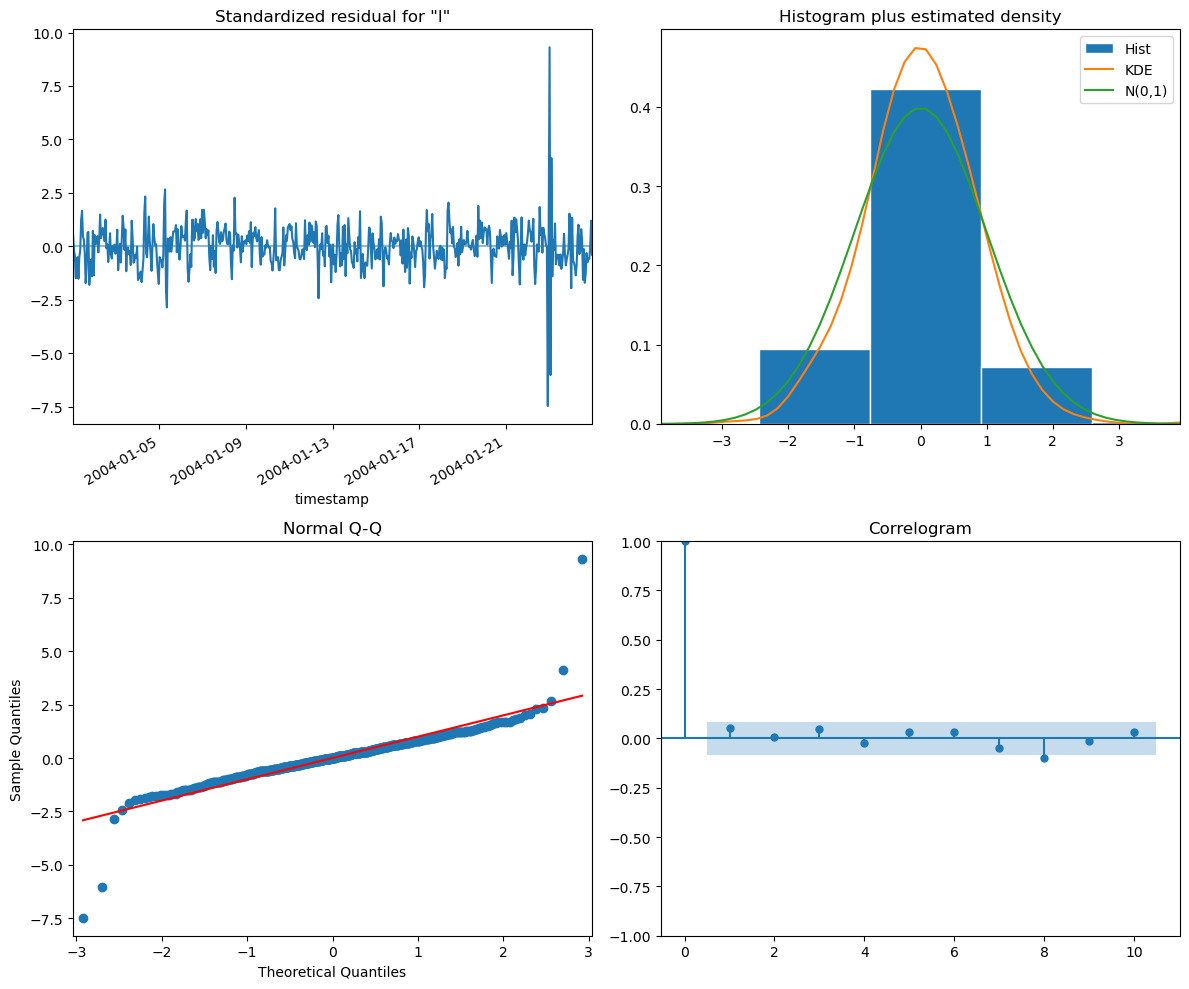

In [107]:
# Diagnostics (for (2,2,2,2)) - (no differencing since regr res are stationary)

import statsmodels.api as sm
SARIMA_model = sm.tsa.statespace.SARIMAX(
        endog = load_long_z1_2004_jan_train["log_load_rs"].asfreq('h'), 
        exog = load_long_z1_2004_jan_train[["HDK", "CDK", "holiday", "trend", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h'), 
        order=(2,0,2),  # non-seasonal: with no differencing
        seasonal_order=(2,0,2,24), # seasonal: with seasonal differencing
        trend="c")

SARIMA_model_fit = SARIMA_model.fit(disp=False, maxiter=400)
SARIMA_model_fit.plot_diagnostics(figsize=(12,10))
plt.tight_layout()
plt.show()

Residual plot appears to have slightly improved, but deviation is still heavy at tails.
> Distribution more similar to Gaussian dist.

In [108]:
# Creating test data
load_long_z1_2004_jan_test = mul_df.loc[mul_df.month == 1,:]
load_long_z1_2004_jan_test = load_long_z1_2004_jan_test.set_index("timestamp")
load_long_z1_2004_jan_test = load_long_z1_2004_jan_test['2004-01-25 00:30:00':]
load_long_z1_2004_jan_test.index = pd.to_datetime(load_long_z1_2004_jan_test.index)
load_long_z1_2004_jan_test.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-01-25 00:30:00  2004      1   25  00:30     3.094174      21.155292   
2004-01-25 01:30:00  2004      1   25  01:30     3.101713      20.058817   
2004-01-25 02:30:00  2004      1   25  02:30     3.144626      19.051006   
2004-01-25 03:30:00  2004      1   25  03:30     3.160441      18.246300   
2004-01-25 04:30:00  2004      1   25  04:30     3.197407      17.700175   

                     holiday        HDK  CDK  
timestamp                                     
2004-01-25 00:30:00        0  33.844708  0.0  
2004-01-25 01:30:00        0  34.941183  0.0  
2004-01-25 02:30:00        0  35.948994  0.0  
2004-01-25 03:30:00        0  36.753700  0.0  
2004-01-25 04:30:00        0  37.299825  0.0

In [109]:
# Defining the sine wave
dp = DeterministicProcess(
    index=load_long_z1_2004_jan_test.index,
    period=None,         # It's not defined so that frequency can be read from the index
    constant=False,      # Let regression model define this intercept later on
    order=1,             # allows trend to be included so that the level of the wave is allowed to change with time, linearly 
    seasonal=False,      # no seasonal dummies
    additional_terms=[periodicity], # 2 seperate waves will be generated
    drop=True            # if perfect collinearity exists, the terms can be dropped
)

waves = dp.in_sample()
waves.head()

trend  sin(1,24)  cos(1,24)  sin(2,24)     cos(2,24)
timestamp                                                                
2004-01-25 00:30:00    1.0   0.000000   1.000000   0.000000  1.000000e+00
2004-01-25 01:30:00    2.0   0.258819   0.965926   0.500000  8.660254e-01
2004-01-25 02:30:00    3.0   0.500000   0.866025   0.866025  5.000000e-01
2004-01-25 03:30:00    4.0   0.707107   0.707107   1.000000  6.123234e-17
2004-01-25 04:30:00    5.0   0.866025   0.500000   0.866025 -5.000000e-01

In [110]:
# Combining fourier terms with other variables - test set
load_long_z1_2004_jan_test = load_long_z1_2004_jan_test.merge(waves, on='timestamp', how='left')
load_long_z1_2004_jan_test.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-01-25 00:30:00  2004      1   25  00:30     3.094174      21.155292   
2004-01-25 01:30:00  2004      1   25  01:30     3.101713      20.058817   
2004-01-25 02:30:00  2004      1   25  02:30     3.144626      19.051006   
2004-01-25 03:30:00  2004      1   25  03:30     3.160441      18.246300   
2004-01-25 04:30:00  2004      1   25  04:30     3.197407      17.700175   

                     holiday        HDK  CDK  trend  sin(1,24)  cos(1,24)  \
timestamp                                                                   
2004-01-25 00:30:00        0  33.844708  0.0    1.0   0.000000   1.000000   
2004-01-25 01:30:00        0  34.941183  0.0    2.0   0.258819   0.965926   
2004-01-25 02:30:00        0  35.948994  0.0    3.0   0.500000   0.866025   
2004-01-25 03:30:00        0  36.753700  0.0    4.0   0.707107   0.707107   
2004-01-25 04:30:00        0  37.299825  0.0    5.0   0.866025   0.500000   

                     sin(2,24)     cos(2,24)  
timestamp                                     
2004-01-25 00:30:00   0.000000  1.000000e+00  
2004-01-25 01:30:00   0.500000  8.660254e-01  
2004-01-25 02:30:00   0.866025  5.000000e-01  
2004-01-25 03:30:00   1.000000  6.123234e-17  
2004-01-25 04:30:00   0.866025 -5.000000e-01

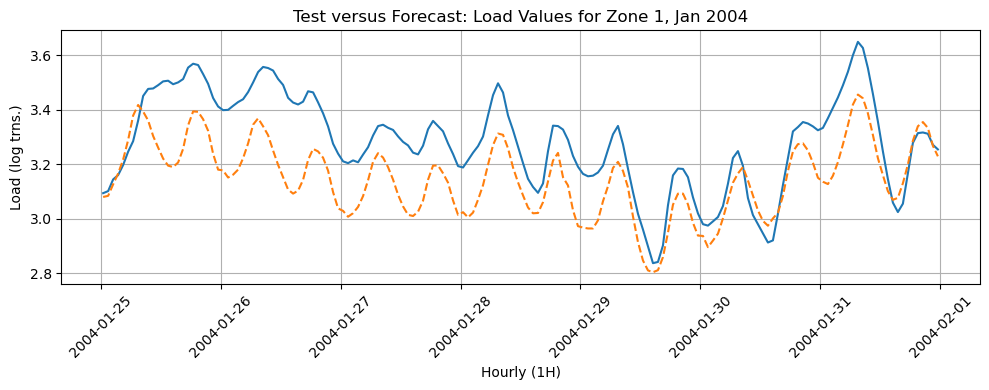

In [111]:
# Predicting 24*7 steps ahead
forecast_jan04 = SARIMA_model_fit.get_forecast(
    steps=24*7, 
    exog = load_long_z1_2004_jan_test[["HDK", "CDK", "holiday", "trend", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h')
).predicted_mean

# Fit on the test data
import seaborn as sns
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=load_long_z1_2004_jan_test, x=load_long_z1_2004_jan_test.index, y=load_long_z1_2004_jan_test["log_load_rs"].asfreq('h'), ax=ax)
sns.lineplot(forecast_jan04, linestyle = '--')
ax.set_title("Test versus Forecast: Load Values for Zone 1, Jan 2004")
ax.set_xlabel("Hourly (1H)")
ax.set_ylabel("Load (log trns.)")
ax.grid(True)
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

In [112]:
# Performance on test set

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print(f"R2 score: {r2_score(load_long_z1_2004_jan_test.log_load_rs, forecast_jan04)}")
print(f'MSE score: {mean_squared_error(load_long_z1_2004_jan_test.log_load_rs, forecast_jan04)}')
print(f'MAE score: {mean_absolute_error(load_long_z1_2004_jan_test.log_load_rs, forecast_jan04)}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_2004_jan_test.log_load_rs, forecast_jan04)}')

R2 score: 0.11227321687585246
MSE score: 0.027112542380149204
MAE score: 0.14350172400023004
MAPE score: 0.04300631956860842


Performance improvement is significant and much better that ES.

##### Testing on Last Week of Apr 2004 (Zone 1)
Last week of Apr 2004 is used for testing. Multiple SARIMAX models are evaluated and compared. 

In [113]:
# Creating training data
load_long_z1_2004_apr_train = mul_df.loc[mul_df.month == 4,:]
load_long_z1_2004_apr_train = load_long_z1_2004_apr_train.set_index("timestamp")
load_long_z1_2004_apr_train = load_long_z1_2004_apr_train[:'2004-04-23 23:30:00']
load_long_z1_2004_apr_train.index = pd.to_datetime(load_long_z1_2004_apr_train.index)
load_long_z1_2004_apr_train.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-04-01 00:30:00  2004      4    1  00:30     2.645820      45.453562   
2004-04-01 01:30:00  2004      4    1  01:30     2.633901      45.547368   
2004-04-01 02:30:00  2004      4    1  02:30     2.633039      45.454863   
2004-04-01 03:30:00  2004      4    1  03:30     2.646246      45.454863   
2004-04-01 04:30:00  2004      4    1  04:30     2.688528      45.191047   

                     holiday       HDK  CDK  
timestamp                                    
2004-04-01 00:30:00        0  9.546438  0.0  
2004-04-01 01:30:00        0  9.452632  0.0  
2004-04-01 02:30:00        0  9.545137  0.0  
2004-04-01 03:30:00        0  9.545137  0.0  
2004-04-01 04:30:00        0  9.808953  0.0

In [114]:
# Defining the sine wave
dp = DeterministicProcess(
    index=load_long_z1_2004_apr_train.index,
    period=None,         # It's not defined so that frequency can be read from the index
    constant=False,      # Let regression model define this intercept later on
    order=1,             # allows trend to be included so that the level of the wave is allowed to change with time, linearly 
    seasonal=False,      # no seasonal dummies
    additional_terms=[periodicity], # 2 seperate waves will be generated
    drop=True            # if perfect collinearity exists, the terms can be dropped
)

waves = dp.in_sample()

# Combining fourier terms with other variables
load_long_z1_2004_apr_train = load_long_z1_2004_apr_train.merge(waves, on='timestamp', how='left')
load_long_z1_2004_apr_train.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-04-01 00:30:00  2004      4    1  00:30     2.645820      45.453562   
2004-04-01 01:30:00  2004      4    1  01:30     2.633901      45.547368   
2004-04-01 02:30:00  2004      4    1  02:30     2.633039      45.454863   
2004-04-01 03:30:00  2004      4    1  03:30     2.646246      45.454863   
2004-04-01 04:30:00  2004      4    1  04:30     2.688528      45.191047   

                     holiday       HDK  CDK  trend  sin(1,24)  cos(1,24)  \
timestamp                                                                  
2004-04-01 00:30:00        0  9.546438  0.0    1.0   0.000000   1.000000   
2004-04-01 01:30:00        0  9.452632  0.0    2.0   0.258819   0.965926   
2004-04-01 02:30:00        0  9.545137  0.0    3.0   0.500000   0.866025   
2004-04-01 03:30:00        0  9.545137  0.0    4.0   0.707107   0.707107   
2004-04-01 04:30:00        0  9.808953  0.0    5.0   0.866025   0.500000   

                     sin(2,24)     cos(2,24)  
timestamp                                     
2004-04-01 00:30:00   0.000000  1.000000e+00  
2004-04-01 01:30:00   0.500000  8.660254e-01  
2004-04-01 02:30:00   0.866025  5.000000e-01  
2004-04-01 03:30:00   1.000000  6.123234e-17  
2004-04-01 04:30:00   0.866025 -5.000000e-01

In [115]:
# Comparing models - auto_arima (no differencing since regr residuals are stationary)

smodel_apr = pm.auto_arima(y = load_long_z1_2004_apr_train["log_load_rs"].asfreq('h'), 
                           X = load_long_z1_2004_apr_train[["HDK", "CDK", "holiday", "trend", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h'),
                           start_p=0, start_q=0,test='adf',
                           max_p=3, max_q=3, m=24,
                           start_P=0, start_Q=0, max_P=2, max_Q=2, seasonal=True,
                           d=0, D=0, trace=True,
                           trend = 'c',
                           error_action='trace',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=-834.394, Time=0.92 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=-2028.655, Time=6.28 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=inf, Time=7.00 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=-834.394, Time=1.31 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=-1736.556, Time=0.83 sec
 ARIMA(1,0,0)(2,0,0)[24] intercept   : AIC=-2026.757, Time=16.11 sec
 ARIMA(1,0,0)(1,0,1)[24] intercept   : AIC=-2022.687, Time=6.51 sec
 ARIMA(1,0,0)(0,0,1)[24] intercept   : AIC=-1803.268, Time=5.96 sec
 ARIMA(1,0,0)(2,0,1)[24] intercept   : AIC=-2015.945, Time=15.80 sec
 ARIMA(0,0,0)(1,0,0)[24] intercept   : AIC=-566.769, Time=4.83 sec
 ARIMA(2,0,0)(1,0,0)[24] intercept   : AIC=-2114.158, Time=6.55 sec
 ARIMA(2,0,0)(0,0,0)[24] intercept   : AIC=-1860.205, Time=0.73 sec
 ARIMA(2,0,0)(2,0,0)[24] intercept   : AIC=-2142.318, Time=17.09 sec
 ARIMA(2,0,0)(2,0,1)[24] intercept   : AIC=-2105.974, Time=20.14 sec
 ARIMA(2,0

The best order for AR/MA components (seasonal and non-seasonal) has again changed, compared to SARIMAX without external regressors.

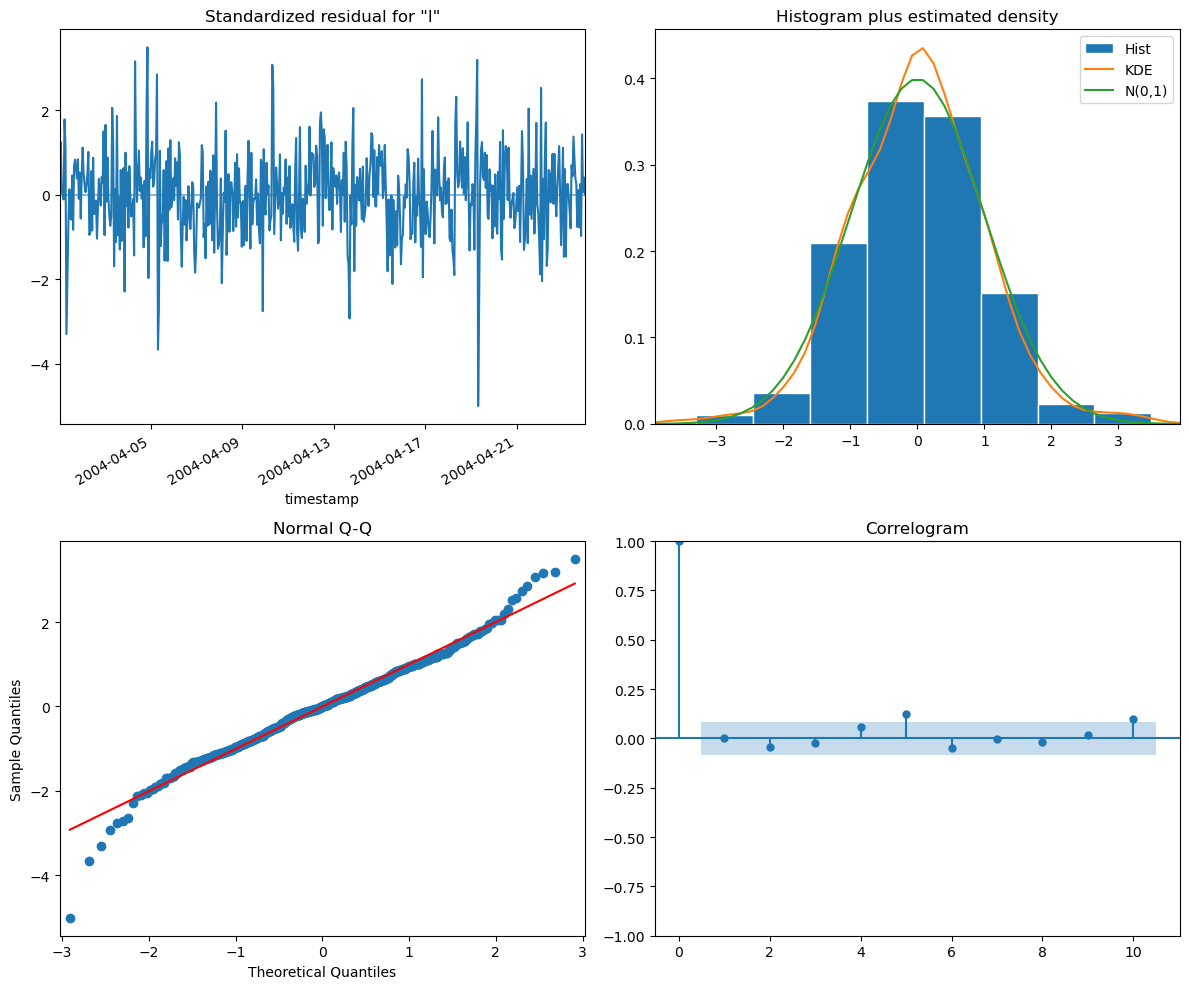

In [116]:
# Diagnostics (for (1,2,1,0)) - no differencing

import statsmodels.api as sm
SARIMA_model = sm.tsa.statespace.SARIMAX(
        endog = load_long_z1_2004_apr_train["log_load_rs"].asfreq('h'), 
        exog = load_long_z1_2004_apr_train[["HDK", "CDK", "holiday", "trend", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h'), 
        order=(1,0,2),  # non-seasonal: with no differencing
        seasonal_order=(1,0,0,24), # seasonal: with seasonal differencing
        trend='c'
        )

SARIMA_model_fit = SARIMA_model.fit(disp=False, maxiter=500)
SARIMA_model_fit.plot_diagnostics(figsize=(12,10))
plt.tight_layout()
plt.show()

In [117]:
# Creating test data
load_long_z1_2004_apr_test = mul_df.loc[mul_df.month == 4,:]
load_long_z1_2004_apr_test = load_long_z1_2004_apr_test.set_index("timestamp")
load_long_z1_2004_apr_test = load_long_z1_2004_apr_test['2004-04-24 00:30:00':]
load_long_z1_2004_apr_test.index = pd.to_datetime(load_long_z1_2004_apr_test.index)
load_long_z1_2004_apr_test.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-04-24 00:30:00  2004      4   24  00:30     2.437728      62.266565   
2004-04-24 01:30:00  2004      4   24  01:30     2.328643      62.708075   
2004-04-24 02:30:00  2004      4   24  02:30     2.279316      61.449205   
2004-04-24 03:30:00  2004      4   24  03:30     2.249290      60.634717   
2004-04-24 04:30:00  2004      4   24  04:30     2.248657      59.824237   

                     holiday  HDK  CDK  
timestamp                               
2004-04-24 00:30:00        0  0.0  0.0  
2004-04-24 01:30:00        0  0.0  0.0  
2004-04-24 02:30:00        0  0.0  0.0  
2004-04-24 03:30:00        0  0.0  0.0  
2004-04-24 04:30:00        0  0.0  0.0

In [118]:
# Defining the sine wave
dp = DeterministicProcess(
    index=load_long_z1_2004_apr_test.index,
    period=None,         # It's not defined so that frequency can be read from the index
    constant=False,      # Let regression model define this intercept later on
    order=1,             # allows trend to be included so that the level of the wave is allowed to change with time, linearly 
    seasonal=False,      # no seasonal dummies
    additional_terms=[periodicity], # 2 seperate waves will be generated
    drop=True            # if perfect collinearity exists, the terms can be dropped
)

waves = dp.in_sample()

# Combining fourier terms with other variables - test set
load_long_z1_2004_apr_test = load_long_z1_2004_apr_test.merge(waves, on='timestamp', how='left')
load_long_z1_2004_apr_test.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-04-24 00:30:00  2004      4   24  00:30     2.437728      62.266565   
2004-04-24 01:30:00  2004      4   24  01:30     2.328643      62.708075   
2004-04-24 02:30:00  2004      4   24  02:30     2.279316      61.449205   
2004-04-24 03:30:00  2004      4   24  03:30     2.249290      60.634717   
2004-04-24 04:30:00  2004      4   24  04:30     2.248657      59.824237   

                     holiday  HDK  CDK  trend  sin(1,24)  cos(1,24)  \
timestamp                                                             
2004-04-24 00:30:00        0  0.0  0.0    1.0   0.000000   1.000000   
2004-04-24 01:30:00        0  0.0  0.0    2.0   0.258819   0.965926   
2004-04-24 02:30:00        0  0.0  0.0    3.0   0.500000   0.866025   
2004-04-24 03:30:00        0  0.0  0.0    4.0   0.707107   0.707107   
2004-04-24 04:30:00        0  0.0  0.0    5.0   0.866025   0.500000   

                     sin(2,24)     cos(2,24)  
timestamp                                     
2004-04-24 00:30:00   0.000000  1.000000e+00  
2004-04-24 01:30:00   0.500000  8.660254e-01  
2004-04-24 02:30:00   0.866025  5.000000e-01  
2004-04-24 03:30:00   1.000000  6.123234e-17  
2004-04-24 04:30:00   0.866025 -5.000000e-01

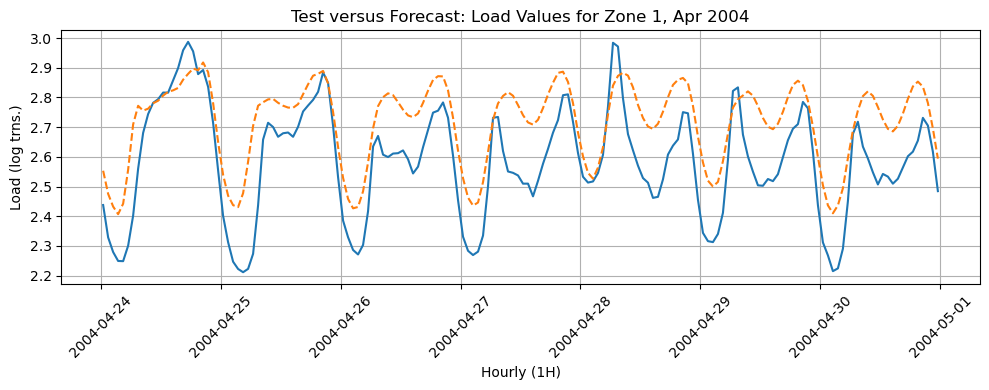

In [119]:
# Predicting 24*7 steps ahead
forecast_apr04 = SARIMA_model_fit.get_forecast(
    steps=24*7, 
    exog = load_long_z1_2004_apr_test[["HDK", "CDK", "holiday", "trend", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h')
).predicted_mean

# Fit on the test data
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=load_long_z1_2004_apr_test, x=load_long_z1_2004_apr_test.index, y=load_long_z1_2004_apr_test.log_load_rs.asfreq('h'), ax=ax)
sns.lineplot(forecast_apr04, linestyle = '--')
ax.set_title("Test versus Forecast: Load Values for Zone 1, Apr 2004")
ax.set_xlabel("Hourly (1H)")
ax.set_ylabel("Load (log trns.)")
ax.grid(True)
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

In [120]:
# Performance on test set

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print(f"R2 score: {r2_score(load_long_z1_2004_apr_test.log_load_rs, forecast_apr04)}")
print(f'MSE score: {mean_squared_error(load_long_z1_2004_apr_test.log_load_rs, forecast_apr04)}')
print(f'MAE score: {mean_absolute_error(load_long_z1_2004_apr_test.log_load_rs, forecast_apr04)}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_2004_apr_test.log_load_rs, forecast_apr04)}')

R2 score: 0.22805800208620863
MSE score: 0.026405113274968545
MAE score: 0.14250197844627077
MAPE score: 0.05684049551141075


##### Testing on Last Week of Jul 2004 (Zone 1)
Last week of Jul 2004 is used for testing. Multiple SARIMAX models are evaluated and compared. 

In [121]:
# Creating training data
load_long_z1_2004_jul_train = mul_df.loc[mul_df.month == 7,:]
load_long_z1_2004_jul_train = load_long_z1_2004_jul_train.set_index("timestamp")
load_long_z1_2004_jul_train = load_long_z1_2004_jul_train[:'2004-07-24 23:30:00']
load_long_z1_2004_jul_train.index = pd.to_datetime(load_long_z1_2004_jul_train.index)
load_long_z1_2004_jul_train.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-07-01 00:30:00  2004      7    1  00:30     2.658230      67.152732   
2004-07-01 01:30:00  2004      7    1  01:30     2.548507      66.148285   
2004-07-01 02:30:00  2004      7    1  02:30     2.482404      65.687669   
2004-07-01 03:30:00  2004      7    1  03:30     2.447464      64.515455   
2004-07-01 04:30:00  2004      7    1  04:30     2.430626      64.517938   

                     holiday  HDK       CDK  
timestamp                                    
2004-07-01 00:30:00        0  0.0  2.152732  
2004-07-01 01:30:00        0  0.0  1.148285  
2004-07-01 02:30:00        0  0.0  0.687669  
2004-07-01 03:30:00        0  0.0  0.000000  
2004-07-01 04:30:00        0  0.0  0.000000

In [122]:
# Defining the sine wave
dp = DeterministicProcess(
    index=load_long_z1_2004_jul_train.index,
    period=None,         # It's not defined so that frequency can be read from the index
    constant=False,      # Let regression model define this intercept later on
    order=1,             
    seasonal=False,      # no seasonal dummies
    additional_terms=[periodicity], # 2 seperate waves will be generated
    drop=True            # if perfect collinearity exists, the terms can be dropped
)

waves = dp.in_sample()

# Combining fourier terms with other variables
load_long_z1_2004_jul_train = load_long_z1_2004_jul_train.merge(waves, on='timestamp', how='left')
load_long_z1_2004_jul_train.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-07-01 00:30:00  2004      7    1  00:30     2.658230      67.152732   
2004-07-01 01:30:00  2004      7    1  01:30     2.548507      66.148285   
2004-07-01 02:30:00  2004      7    1  02:30     2.482404      65.687669   
2004-07-01 03:30:00  2004      7    1  03:30     2.447464      64.515455   
2004-07-01 04:30:00  2004      7    1  04:30     2.430626      64.517938   

                     holiday  HDK       CDK  trend  sin(1,24)  cos(1,24)  \
timestamp                                                                  
2004-07-01 00:30:00        0  0.0  2.152732    1.0   0.000000   1.000000   
2004-07-01 01:30:00        0  0.0  1.148285    2.0   0.258819   0.965926   
2004-07-01 02:30:00        0  0.0  0.687669    3.0   0.500000   0.866025   
2004-07-01 03:30:00        0  0.0  0.000000    4.0   0.707107   0.707107   
2004-07-01 04:30:00        0  0.0  0.000000    5.0   0.866025   0.500000   

                     sin(2,24)     cos(2,24)  
timestamp                                     
2004-07-01 00:30:00   0.000000  1.000000e+00  
2004-07-01 01:30:00   0.500000  8.660254e-01  
2004-07-01 02:30:00   0.866025  5.000000e-01  
2004-07-01 03:30:00   1.000000  6.123234e-17  
2004-07-01 04:30:00   0.866025 -5.000000e-01

In [123]:
# Comparing models - auto_arima (no differencing)

smodel_jul = pm.auto_arima(y = load_long_z1_2004_jul_train["log_load_rs"].asfreq('h'), 
                           X = load_long_z1_2004_jul_train[["HDK", "CDK", "holiday", "trend", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h'),
                           start_p=0, start_q=0,test='adf',
                           max_p=3, max_q=3, m=24,
                           start_P=0, start_Q=0, max_P=2, max_Q=2, seasonal=True,
                           d=0, D=0, trace=True,
                           trend='c',
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=-867.715, Time=0.65 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=6.61 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=inf, Time=7.46 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=-867.715, Time=0.67 sec
 ARIMA(0,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=5.65 sec
 ARIMA(0,0,0)(0,0,1)[24] intercept   : AIC=inf, Time=5.47 sec
 ARIMA(0,0,0)(1,0,1)[24] intercept   : AIC=-582.525, Time=6.62 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=-2337.461, Time=0.72 sec
 ARIMA(1,0,0)(0,0,1)[24] intercept   : AIC=-2320.745, Time=6.49 sec
 ARIMA(1,0,0)(1,0,1)[24] intercept   : AIC=-2483.624, Time=8.10 sec
 ARIMA(1,0,0)(2,0,1)[24] intercept   : AIC=-2285.178, Time=18.58 sec
 ARIMA(1,0,0)(1,0,2)[24] intercept   : AIC=-1952.662, Time=18.32 sec
 ARIMA(1,0,0)(0,0,2)[24] intercept   : AIC=inf, Time=17.35 sec
 ARIMA(1,0,0)(2,0,0)[24] intercept   : AIC=inf, Time=20.05 sec
 ARIMA(1,0,0)(2,0,2)[24] intercept   : A

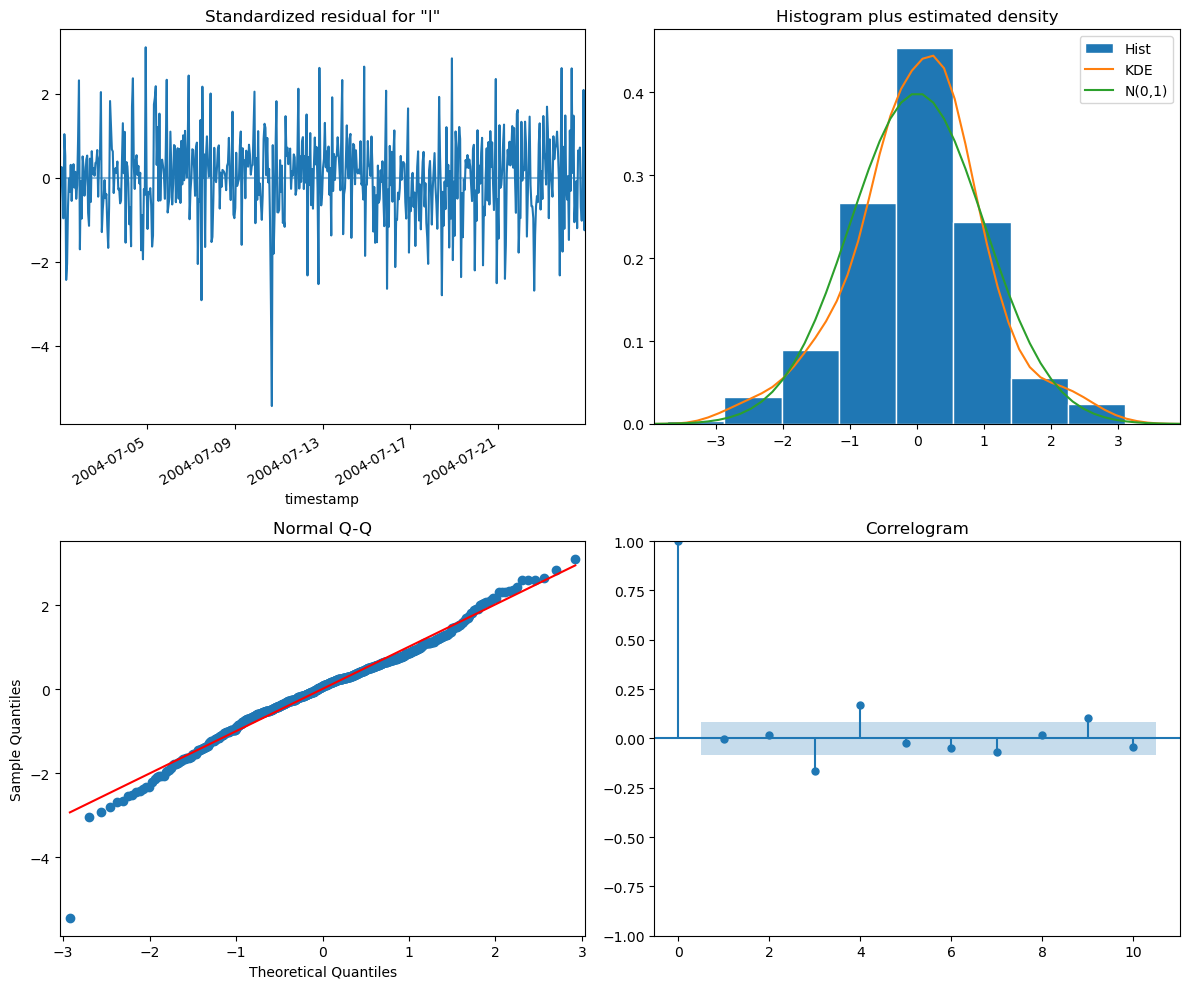

In [124]:
# Diagnostics (for (1,1,0,0)) - no differencing

SARIMA_model = sm.tsa.statespace.SARIMAX(
        endog = load_long_z1_2004_jul_train["log_load_rs"].asfreq('h'), 
        exog = load_long_z1_2004_jul_train[["HDK", "CDK", "holiday", "trend", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h'), 
        order=(1,0,1),  # non-seasonal: with no differencing
        seasonal_order=(0,0,0,24), # seasonal: with no seasonal differencing
        trend='c'
        )

SARIMA_model_fit = SARIMA_model.fit(disp=False, maxiter=500)
SARIMA_model_fit.plot_diagnostics(figsize=(12,10))
plt.tight_layout()
plt.show()

In [125]:
# Creating test data
load_long_z1_2004_jul_test = mul_df.loc[mul_df.month == 7,:]
load_long_z1_2004_jul_test = load_long_z1_2004_jul_test.set_index("timestamp")
load_long_z1_2004_jul_test = load_long_z1_2004_jul_test['2004-07-25 00:30:00':]
load_long_z1_2004_jul_test.index = pd.to_datetime(load_long_z1_2004_jul_test.index)
load_long_z1_2004_jul_test.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-07-25 00:30:00  2004      7   25  00:30     2.669517      70.616043   
2004-07-25 01:30:00  2004      7   25  01:30     2.551552      70.893317   
2004-07-25 02:30:00  2004      7   25  02:30     2.486073      70.710504   
2004-07-25 03:30:00  2004      7   25  03:30     2.441738      70.526899   
2004-07-25 04:30:00  2004      7   25  04:30     2.429834      70.527349   

                     holiday  HDK       CDK  
timestamp                                    
2004-07-25 00:30:00        0  0.0  5.616043  
2004-07-25 01:30:00        0  0.0  5.893317  
2004-07-25 02:30:00        0  0.0  5.710504  
2004-07-25 03:30:00        0  0.0  5.526899  
2004-07-25 04:30:00        0  0.0  5.527349

In [126]:
# Defining the sine wave
dp = DeterministicProcess(
    index=load_long_z1_2004_jul_test.index,
    period=None,         # It's not defined so that frequency can be read from the index
    constant=False,      # Let regression model define this intercept later on
    order=1,              
    seasonal=False,      # no seasonal dummies
    additional_terms=[periodicity], # 2 seperate waves will be generated
    drop=True            # if perfect collinearity exists, the terms can be dropped
)

waves = dp.in_sample()

# Combining fourier terms with other variables - test set
load_long_z1_2004_jul_test = load_long_z1_2004_jul_test.merge(waves, on='timestamp', how='left')
load_long_z1_2004_jul_test.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-07-25 00:30:00  2004      7   25  00:30     2.669517      70.616043   
2004-07-25 01:30:00  2004      7   25  01:30     2.551552      70.893317   
2004-07-25 02:30:00  2004      7   25  02:30     2.486073      70.710504   
2004-07-25 03:30:00  2004      7   25  03:30     2.441738      70.526899   
2004-07-25 04:30:00  2004      7   25  04:30     2.429834      70.527349   

                     holiday  HDK       CDK  trend  sin(1,24)  cos(1,24)  \
timestamp                                                                  
2004-07-25 00:30:00        0  0.0  5.616043    1.0   0.000000   1.000000   
2004-07-25 01:30:00        0  0.0  5.893317    2.0   0.258819   0.965926   
2004-07-25 02:30:00        0  0.0  5.710504    3.0   0.500000   0.866025   
2004-07-25 03:30:00        0  0.0  5.526899    4.0   0.707107   0.707107   
2004-07-25 04:30:00        0  0.0  5.527349    5.0   0.866025   0.500000   

                     sin(2,24)     cos(2,24)  
timestamp                                     
2004-07-25 00:30:00   0.000000  1.000000e+00  
2004-07-25 01:30:00   0.500000  8.660254e-01  
2004-07-25 02:30:00   0.866025  5.000000e-01  
2004-07-25 03:30:00   1.000000  6.123234e-17  
2004-07-25 04:30:00   0.866025 -5.000000e-01

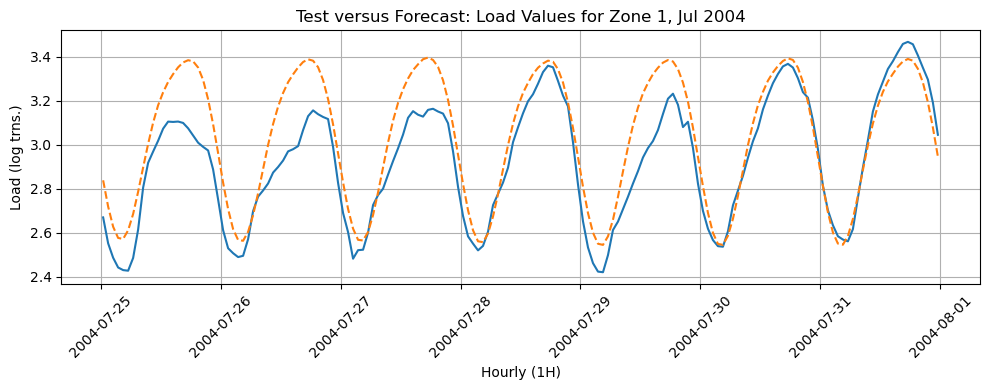

In [127]:
# Predicting 24*7 steps ahead
forecast_jul04 = SARIMA_model_fit.get_forecast(
    steps=24*7, 
    exog = load_long_z1_2004_jul_test[["HDK", "CDK", "holiday", "trend", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h')
).predicted_mean

# Fit on the test data
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=load_long_z1_2004_jul_test, x=load_long_z1_2004_jul_test.index, y=load_long_z1_2004_jul_test.log_load_rs.asfreq('h'), ax=ax)
sns.lineplot(forecast_jul04, linestyle = '--')
ax.set_title("Test versus Forecast: Load Values for Zone 1, Jul 2004")
ax.set_xlabel("Hourly (1H)")
ax.set_ylabel("Load (log trns.)")
ax.grid(True)
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

In [128]:
# Performance on test set

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print(f"R2 score: {r2_score(load_long_z1_2004_jul_test.log_load_rs, forecast_jul04)}")
print(f'MSE score: {mean_squared_error(load_long_z1_2004_jul_test.log_load_rs, forecast_jul04)}')
print(f'MAE score: {mean_absolute_error(load_long_z1_2004_jul_test.log_load_rs, forecast_jul04)}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_2004_jul_test.log_load_rs, forecast_jul04)}')

R2 score: 0.704947128067944
MSE score: 0.02330201832840338
MAE score: 0.12318974429976484
MAPE score: 0.0422411831395949


##### Testing on Last Week of Oct 2004 (Zone 1)
Last week of Oct 2004 is used for testing. Multiple SARIMAX models are evaluated and compared. 

In [129]:
# Creating training data
load_long_z1_2004_oct_train = mul_df.loc[mul_df.month == 10,:]
load_long_z1_2004_oct_train = load_long_z1_2004_oct_train.set_index("timestamp")
load_long_z1_2004_oct_train = load_long_z1_2004_oct_train[:'2004-10-24 23:30:00']
load_long_z1_2004_oct_train.index = pd.to_datetime(load_long_z1_2004_oct_train.index)
load_long_z1_2004_oct_train.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-10-01 00:30:00  2004     10    1  00:30     2.410093      60.792180   
2004-10-01 01:30:00  2004     10    1  01:30     2.324444      60.513850   
2004-10-01 02:30:00  2004     10    1  02:30     2.293544      60.152501   
2004-10-01 03:30:00  2004     10    1  03:30     2.289399      59.693854   
2004-10-01 04:30:00  2004     10    1  04:30     2.303684      59.417333   

                     holiday  HDK  CDK  
timestamp                               
2004-10-01 00:30:00        0  0.0  0.0  
2004-10-01 01:30:00        0  0.0  0.0  
2004-10-01 02:30:00        0  0.0  0.0  
2004-10-01 03:30:00        0  0.0  0.0  
2004-10-01 04:30:00        0  0.0  0.0

In [130]:
# Defining the sine wave
dp = DeterministicProcess(
    index=load_long_z1_2004_oct_train.index,
    period=None,         # It's not defined so that frequency can be read from the index
    constant=False,      # Let regression model define this intercept later on
    order=1,             
    seasonal=False,      # no seasonal dummies
    additional_terms=[periodicity], # 2 seperate waves will be generated
    drop=True            # if perfect collinearity exists, the terms can be dropped
)

waves = dp.in_sample()

# Combining fourier terms with other variables
load_long_z1_2004_oct_train = load_long_z1_2004_oct_train.merge(waves, on='timestamp', how='left')
load_long_z1_2004_oct_train.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-10-01 00:30:00  2004     10    1  00:30     2.410093      60.792180   
2004-10-01 01:30:00  2004     10    1  01:30     2.324444      60.513850   
2004-10-01 02:30:00  2004     10    1  02:30     2.293544      60.152501   
2004-10-01 03:30:00  2004     10    1  03:30     2.289399      59.693854   
2004-10-01 04:30:00  2004     10    1  04:30     2.303684      59.417333   

                     holiday  HDK  CDK  trend  sin(1,24)  cos(1,24)  \
timestamp                                                             
2004-10-01 00:30:00        0  0.0  0.0    1.0   0.000000   1.000000   
2004-10-01 01:30:00        0  0.0  0.0    2.0   0.258819   0.965926   
2004-10-01 02:30:00        0  0.0  0.0    3.0   0.500000   0.866025   
2004-10-01 03:30:00        0  0.0  0.0    4.0   0.707107   0.707107   
2004-10-01 04:30:00        0  0.0  0.0    5.0   0.866025   0.500000   

                     sin(2,24)     cos(2,24)  
timestamp                                     
2004-10-01 00:30:00   0.000000  1.000000e+00  
2004-10-01 01:30:00   0.500000  8.660254e-01  
2004-10-01 02:30:00   0.866025  5.000000e-01  
2004-10-01 03:30:00   1.000000  6.123234e-17  
2004-10-01 04:30:00   0.866025 -5.000000e-01

In [131]:
# Comparing models - auto_arima (no differencing since regr residuals are stationary)

smodel_oct = pm.auto_arima(y = load_long_z1_2004_oct_train["log_load_rs"].asfreq('h'), 
                           X = load_long_z1_2004_oct_train[["HDK", "CDK", "holiday", "trend", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h'),
                           start_p=0, start_q=0,test='adf',
                           max_p=3, max_q=3, m=24,
                           start_P=0, start_Q=0, max_P=2, max_Q=2, seasonal=True,
                           d=0, D=0, trace=True,
                           trend='c',
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=-390.996, Time=0.67 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=-2191.397, Time=7.26 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=-1268.069, Time=6.94 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=-390.996, Time=0.66 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=-2043.748, Time=0.68 sec
 ARIMA(1,0,0)(2,0,0)[24] intercept   : AIC=-2202.477, Time=18.23 sec
 ARIMA(1,0,0)(2,0,1)[24] intercept   : AIC=-2175.491, Time=18.96 sec
 ARIMA(1,0,0)(1,0,1)[24] intercept   : AIC=-2197.506, Time=7.36 sec
 ARIMA(0,0,0)(2,0,0)[24] intercept   : AIC=inf, Time=13.69 sec
 ARIMA(2,0,0)(2,0,0)[24] intercept   : AIC=-2299.843, Time=21.22 sec
 ARIMA(2,0,0)(1,0,0)[24] intercept   : AIC=-2310.706, Time=7.99 sec
 ARIMA(2,0,0)(0,0,0)[24] intercept   : AIC=-2147.819, Time=1.00 sec
 ARIMA(2,0,0)(1,0,1)[24] intercept   : AIC=-2259.307, Time=7.63 sec
 ARIMA(2,0,0)(0,0,1)[24] intercept   : AIC=-2310.521, Time=7.32 sec
 ARIMA(2,

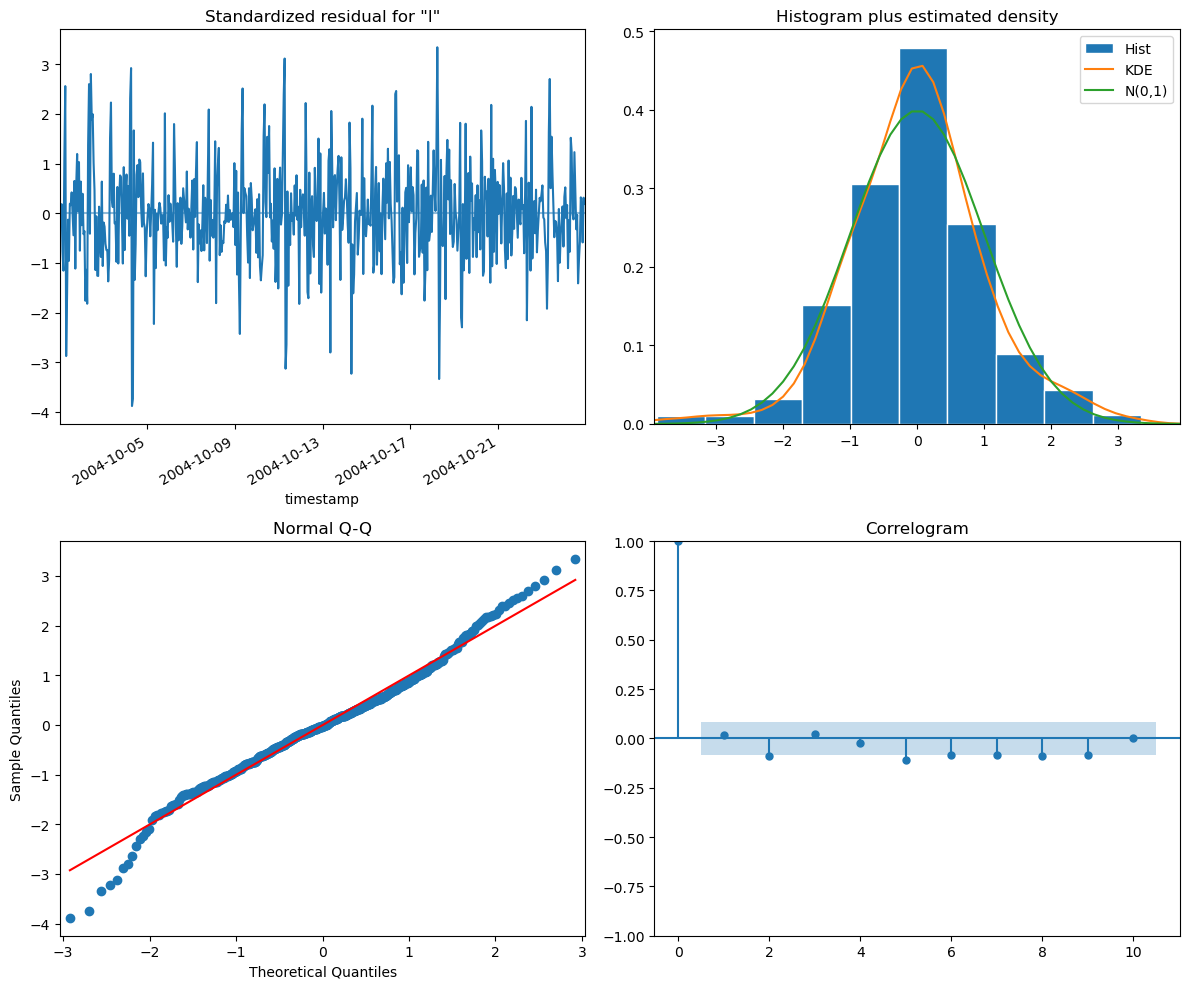

In [132]:
# Diagnostics (for (3,0,1,0)) - no differencing

SARIMA_model = sm.tsa.statespace.SARIMAX(
        endog = load_long_z1_2004_oct_train["log_load_rs"].asfreq('h'), 
        exog = load_long_z1_2004_oct_train[["HDK", "CDK", "holiday", "trend", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h'), 
        order=(3,0,0),  # non-seasonal: with no differencing
        seasonal_order=(1,0,0,24), # seasonal: with no seasonal differencing
        trend='c'
        )

SARIMA_model_fit = SARIMA_model.fit(disp=False, maxiter=500)
SARIMA_model_fit.plot_diagnostics(figsize=(12,10))
plt.tight_layout()
plt.show()

In [133]:
# Creating test data
load_long_z1_2004_oct_test = mul_df.loc[mul_df.month == 10,:]
load_long_z1_2004_oct_test = load_long_z1_2004_oct_test.set_index("timestamp")
load_long_z1_2004_oct_test = load_long_z1_2004_oct_test['2004-10-25 00:30:00':]
load_long_z1_2004_oct_test.index = pd.to_datetime(load_long_z1_2004_oct_test.index)
load_long_z1_2004_oct_test.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-10-25 00:30:00  2004     10   25  00:30     2.449970      50.290127   
2004-10-25 01:30:00  2004     10   25  01:30     2.407305      50.291859   
2004-10-25 02:30:00  2004     10   25  02:30     2.395164      50.658222   
2004-10-25 03:30:00  2004     10   25  03:30     2.396531      50.571048   
2004-10-25 04:30:00  2004     10   25  04:30     2.434403      50.467636   

                     holiday       HDK  CDK  
timestamp                                    
2004-10-25 00:30:00        0  4.709873  0.0  
2004-10-25 01:30:00        0  4.708141  0.0  
2004-10-25 02:30:00        0  4.341778  0.0  
2004-10-25 03:30:00        0  4.428952  0.0  
2004-10-25 04:30:00        0  4.532364  0.0

In [134]:
# Defining the sine wave
dp = DeterministicProcess(
    index=load_long_z1_2004_oct_test.index,
    period=None,         # It's not defined so that frequency can be read from the index
    constant=False,      # Let regression model define this intercept later on
    order=1,              
    seasonal=False,      # no seasonal dummies
    additional_terms=[periodicity], # 2 seperate waves will be generated
    drop=True            # if perfect collinearity exists, the terms can be dropped
)

waves = dp.in_sample()

# Combining fourier terms with other variables - test set
load_long_z1_2004_oct_test = load_long_z1_2004_oct_test.merge(waves, on='timestamp', how='left')
load_long_z1_2004_oct_test.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-10-25 00:30:00  2004     10   25  00:30     2.449970      50.290127   
2004-10-25 01:30:00  2004     10   25  01:30     2.407305      50.291859   
2004-10-25 02:30:00  2004     10   25  02:30     2.395164      50.658222   
2004-10-25 03:30:00  2004     10   25  03:30     2.396531      50.571048   
2004-10-25 04:30:00  2004     10   25  04:30     2.434403      50.467636   

                     holiday       HDK  CDK  trend  sin(1,24)  cos(1,24)  \
timestamp                                                                  
2004-10-25 00:30:00        0  4.709873  0.0    1.0   0.000000   1.000000   
2004-10-25 01:30:00        0  4.708141  0.0    2.0   0.258819   0.965926   
2004-10-25 02:30:00        0  4.341778  0.0    3.0   0.500000   0.866025   
2004-10-25 03:30:00        0  4.428952  0.0    4.0   0.707107   0.707107   
2004-10-25 04:30:00        0  4.532364  0.0    5.0   0.866025   0.500000   

                     sin(2,24)     cos(2,24)  
timestamp                                     
2004-10-25 00:30:00   0.000000  1.000000e+00  
2004-10-25 01:30:00   0.500000  8.660254e-01  
2004-10-25 02:30:00   0.866025  5.000000e-01  
2004-10-25 03:30:00   1.000000  6.123234e-17  
2004-10-25 04:30:00   0.866025 -5.000000e-01

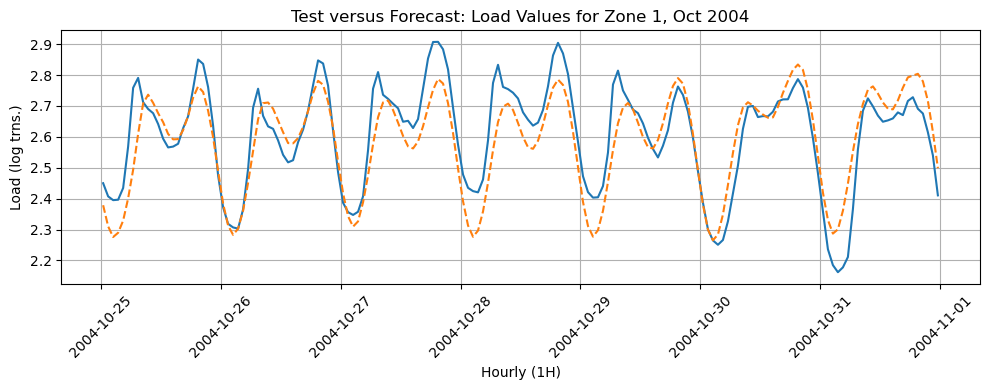

In [135]:
# Predicting 24*7 steps ahead
forecast_oct04 = SARIMA_model_fit.get_forecast(
    steps=24*7, 
    exog = load_long_z1_2004_oct_test[["HDK", "CDK", "holiday", "trend", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h')
).predicted_mean

# Fit on the test data
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=load_long_z1_2004_oct_test, x=load_long_z1_2004_oct_test.index, y=load_long_z1_2004_oct_test.log_load_rs.asfreq('h'), ax=ax)
sns.lineplot(forecast_oct04, linestyle = '--')
ax.set_title("Test versus Forecast: Load Values for Zone 1, Oct 2004")
ax.set_xlabel("Hourly (1H)")
ax.set_ylabel("Load (log trns.)")
ax.grid(True)
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

In [136]:
# Performance on test set

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print(f"R2 score: {r2_score(load_long_z1_2004_oct_test.log_load_rs, forecast_oct04)}")
print(f'MSE score: {mean_squared_error(load_long_z1_2004_oct_test.log_load_rs, forecast_oct04)}')
print(f'MAE score: {mean_absolute_error(load_long_z1_2004_oct_test.log_load_rs, forecast_oct04)}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_2004_oct_test.log_load_rs, forecast_oct04)}')

R2 score: 0.7315967926407376
MSE score: 0.0075790507555279565
MAE score: 0.0697411687746062
MAPE score: 0.02685797170209337


##### Testing on Last Week of Dec 2004 (Zone 1)
Last week of Dec 2004 is used for testing. Multiple SARIMAX models are evaluated and compared. 

In [137]:
# Creating training data
load_long_z1_2004_dec_train = mul_df.loc[mul_df.month == 12,:]
load_long_z1_2004_dec_train = load_long_z1_2004_dec_train.set_index("timestamp")
load_long_z1_2004_dec_train = load_long_z1_2004_dec_train[:'2004-12-24 23:30:00']
load_long_z1_2004_dec_train.index = pd.to_datetime(load_long_z1_2004_dec_train.index)
load_long_z1_2004_dec_train.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-12-01 00:30:00  2004     12    1  00:30     2.650774      47.965991   
2004-12-01 01:30:00  2004     12    1  01:30     2.609481      48.609925   
2004-12-01 02:30:00  2004     12    1  02:30     2.608304      49.154281   
2004-12-01 03:30:00  2004     12    1  03:30     2.617177      50.252969   
2004-12-01 04:30:00  2004     12    1  04:30     2.646104      51.607521   

                     holiday       HDK  CDK  
timestamp                                    
2004-12-01 00:30:00        0  7.034009  0.0  
2004-12-01 01:30:00        0  6.390075  0.0  
2004-12-01 02:30:00        0  5.845719  0.0  
2004-12-01 03:30:00        0  4.747031  0.0  
2004-12-01 04:30:00        0  3.392479  0.0

In [138]:
# Defining the sine wave
dp = DeterministicProcess(
    index=load_long_z1_2004_dec_train.index,
    period=None,         # It's not defined so that frequency can be read from the index
    constant=False,      # Let regression model define this intercept later on
    order=1,             
    seasonal=False,      # no seasonal dummies
    additional_terms=[periodicity], # 2 seperate waves will be generated
    drop=True            # if perfect collinearity exists, the terms can be dropped
)

waves = dp.in_sample()

# Combining fourier terms with other variables
load_long_z1_2004_dec_train = load_long_z1_2004_dec_train.merge(waves, on='timestamp', how='left')
load_long_z1_2004_dec_train.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-12-01 00:30:00  2004     12    1  00:30     2.650774      47.965991   
2004-12-01 01:30:00  2004     12    1  01:30     2.609481      48.609925   
2004-12-01 02:30:00  2004     12    1  02:30     2.608304      49.154281   
2004-12-01 03:30:00  2004     12    1  03:30     2.617177      50.252969   
2004-12-01 04:30:00  2004     12    1  04:30     2.646104      51.607521   

                     holiday       HDK  CDK  trend  sin(1,24)  cos(1,24)  \
timestamp                                                                  
2004-12-01 00:30:00        0  7.034009  0.0    1.0   0.000000   1.000000   
2004-12-01 01:30:00        0  6.390075  0.0    2.0   0.258819   0.965926   
2004-12-01 02:30:00        0  5.845719  0.0    3.0   0.500000   0.866025   
2004-12-01 03:30:00        0  4.747031  0.0    4.0   0.707107   0.707107   
2004-12-01 04:30:00        0  3.392479  0.0    5.0   0.866025   0.500000   

                     sin(2,24)     cos(2,24)  
timestamp                                     
2004-12-01 00:30:00   0.000000  1.000000e+00  
2004-12-01 01:30:00   0.500000  8.660254e-01  
2004-12-01 02:30:00   0.866025  5.000000e-01  
2004-12-01 03:30:00   1.000000  6.123234e-17  
2004-12-01 04:30:00   0.866025 -5.000000e-01

In [139]:
# Comparing models - auto_arima (no differencing)

smodel_dec = pm.auto_arima(y = load_long_z1_2004_dec_train["log_load_rs"].asfreq('h'), 
                           X = load_long_z1_2004_dec_train[["HDK", "CDK", "holiday", "trend", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h'),
                           start_p=0, start_q=0,test='adf',
                           max_p=3, max_q=3, m=24,
                           start_P=0, start_Q=0, max_P=2, max_Q=2, seasonal=True,
                           d=0, D=0, trace=True,
                           trend='c',
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=266.509, Time=0.94 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=-2220.798, Time=6.97 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=inf, Time=7.90 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=266.509, Time=0.92 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=-2097.397, Time=0.64 sec
 ARIMA(1,0,0)(2,0,0)[24] intercept   : AIC=-2220.645, Time=19.32 sec
 ARIMA(1,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=7.19 sec
 ARIMA(1,0,0)(0,0,1)[24] intercept   : AIC=-2136.802, Time=6.27 sec
 ARIMA(1,0,0)(2,0,1)[24] intercept   : AIC=inf, Time=17.34 sec
 ARIMA(0,0,0)(1,0,0)[24] intercept   : AIC=-78.850, Time=5.62 sec
 ARIMA(2,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=7.78 sec
 ARIMA(1,0,1)(1,0,0)[24] intercept   : AIC=-1690.242, Time=7.35 sec
 ARIMA(0,0,1)(1,0,0)[24] intercept   : AIC=inf, Time=6.21 sec
 ARIMA(2,0,1)(1,0,0)[24] intercept   : AIC=inf, Time=8.07 sec
 ARIMA(1,0,0)(1,0,0)[24]             : AIC=-2

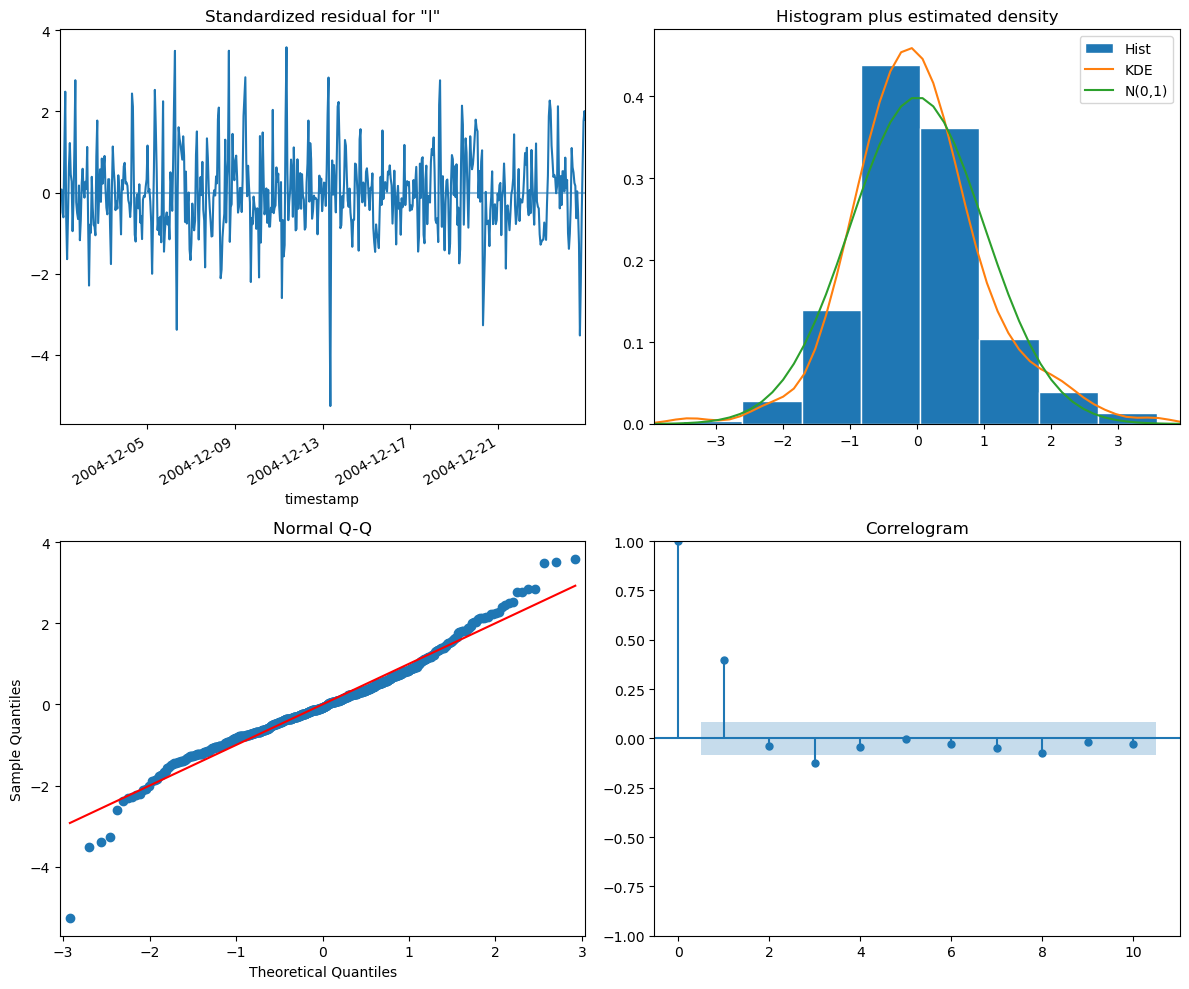

In [140]:
# Diagnostics (for (1,0,1,0)) - no differencing

SARIMA_model = sm.tsa.statespace.SARIMAX(
        endog = load_long_z1_2004_dec_train["log_load_rs"].asfreq('h'), 
        exog = load_long_z1_2004_dec_train[["HDK", "CDK", "holiday", "trend", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h'), 
        order=(1,0,0),  # non-seasonal: with no differencing
        seasonal_order=(1,0,0,24), # seasonal: with seasonal differencing
        trend='c'
        )

SARIMA_model_fit = SARIMA_model.fit(disp=False, maxiter=500)
SARIMA_model_fit.plot_diagnostics(figsize=(12,10))
plt.tight_layout()
plt.show()

In [141]:
# Creating test data
load_long_z1_2004_dec_test = mul_df.loc[mul_df.month == 12,:]
load_long_z1_2004_dec_test = load_long_z1_2004_dec_test.set_index("timestamp")
load_long_z1_2004_dec_test = load_long_z1_2004_dec_test['2004-12-25 00:30:00':]
load_long_z1_2004_dec_test.index = pd.to_datetime(load_long_z1_2004_dec_test.index)
load_long_z1_2004_dec_test.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-12-25 00:30:00  2004     12   25  00:30     3.270443      25.586955   
2004-12-25 01:30:00  2004     12   25  01:30     3.272530      24.675567   
2004-12-25 02:30:00  2004     12   25  02:30     3.290191      24.681275   
2004-12-25 03:30:00  2004     12   25  03:30     3.314804      24.588997   
2004-12-25 04:30:00  2004     12   25  04:30     3.350676      24.320518   

                     holiday        HDK  CDK  
timestamp                                     
2004-12-25 00:30:00        0  29.413045  0.0  
2004-12-25 01:30:00        0  30.324433  0.0  
2004-12-25 02:30:00        0  30.318725  0.0  
2004-12-25 03:30:00        0  30.411003  0.0  
2004-12-25 04:30:00        0  30.679482  0.0

In [142]:
# Defining the sine wave
dp = DeterministicProcess(
    index=load_long_z1_2004_dec_test.index,
    period=None,         # It's not defined so that frequency can be read from the index
    constant=False,      # Let regression model define this intercept later on
    order=1,              
    seasonal=False,      # no seasonal dummies
    additional_terms=[periodicity], # 2 seperate waves will be generated
    drop=True            # if perfect collinearity exists, the terms can be dropped
)

waves = dp.in_sample()

# Combining fourier terms with other variables - test set
load_long_z1_2004_dec_test = load_long_z1_2004_dec_test.merge(waves, on='timestamp', how='left')
load_long_z1_2004_dec_test.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-12-25 00:30:00  2004     12   25  00:30     3.270443      25.586955   
2004-12-25 01:30:00  2004     12   25  01:30     3.272530      24.675567   
2004-12-25 02:30:00  2004     12   25  02:30     3.290191      24.681275   
2004-12-25 03:30:00  2004     12   25  03:30     3.314804      24.588997   
2004-12-25 04:30:00  2004     12   25  04:30     3.350676      24.320518   

                     holiday        HDK  CDK  trend  sin(1,24)  cos(1,24)  \
timestamp                                                                   
2004-12-25 00:30:00        0  29.413045  0.0    1.0   0.000000   1.000000   
2004-12-25 01:30:00        0  30.324433  0.0    2.0   0.258819   0.965926   
2004-12-25 02:30:00        0  30.318725  0.0    3.0   0.500000   0.866025   
2004-12-25 03:30:00        0  30.411003  0.0    4.0   0.707107   0.707107   
2004-12-25 04:30:00        0  30.679482  0.0    5.0   0.866025   0.500000   

                     sin(2,24)     cos(2,24)  
timestamp                                     
2004-12-25 00:30:00   0.000000  1.000000e+00  
2004-12-25 01:30:00   0.500000  8.660254e-01  
2004-12-25 02:30:00   0.866025  5.000000e-01  
2004-12-25 03:30:00   1.000000  6.123234e-17  
2004-12-25 04:30:00   0.866025 -5.000000e-01

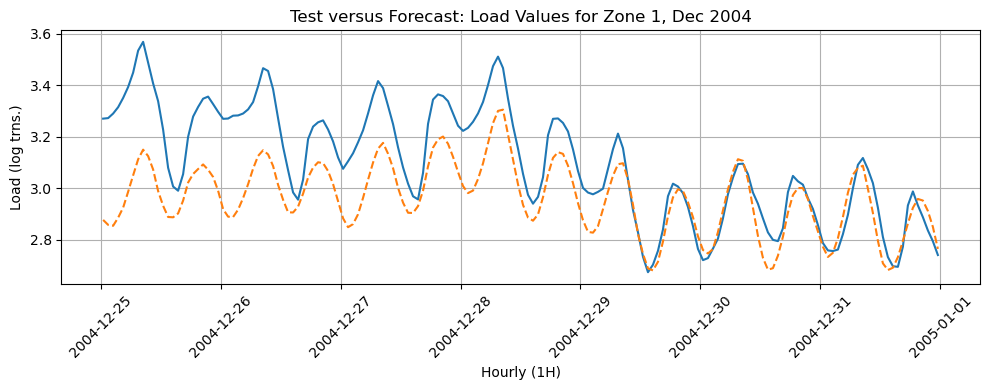

In [143]:
# Predicting 24*7 steps ahead
forecast_dec04 = SARIMA_model_fit.get_forecast(
    steps=24*7, 
    exog = load_long_z1_2004_dec_test[["HDK", "CDK", "holiday", "trend", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h')
).predicted_mean

# Fit on the test data
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=load_long_z1_2004_dec_test, x=load_long_z1_2004_dec_test.index, y=load_long_z1_2004_dec_test.log_load_rs.asfreq('h'), ax=ax)
sns.lineplot(forecast_dec04, linestyle = '--')
ax.set_title("Test versus Forecast: Load Values for Zone 1, Dec 2004")
ax.set_xlabel("Hourly (1H)")
ax.set_ylabel("Load (log trns.)")
ax.grid(True)
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

In [144]:
# Performance on test set

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print(f"R2 score: {r2_score(load_long_z1_2004_dec_test.log_load_rs, forecast_dec04)}")
print(f'MSE score: {mean_squared_error(load_long_z1_2004_dec_test.log_load_rs, forecast_dec04)}')
print(f'MAE score: {mean_absolute_error(load_long_z1_2004_dec_test.log_load_rs, forecast_dec04)}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_2004_dec_test.log_load_rs, forecast_dec04)}')

R2 score: 0.24279871826611998
MSE score: 0.035530611001268295
MAE score: 0.14783133017715436
MAPE score: 0.0458316332778004


> What is found here is very interesting:
>> Defining P and Q (seasonal components) in the SARIMAX model actually led to SARIMA errors actually competing with fourier terms to explain seasonality.
>> This competition between the two actually led to poor model performance.
>> Setting P,Q =0 led to only fourier terms explaining the seasonal part with p,q (non-seasonal components) taking charge for explaining non-seasonal autocorrelation.

> Testing alternative cases:
>> - Remove fourier terms and only allow SARIMAX to explain seasonality
>> - Let SARIMAX only explain the non-seasonal autocorrelation and only let fourier terms explain seasonal variation. 

## Combining Fourier Terms with non-seasonal SARIMAX
The model combines regressors in addition to fourier terms, as used in time series regression. Together thez make all exogenous regressors. This is then combined with non-seasonal SARIMAX, where seasonal AR\MA components are deliberately set to 0, so that SARIMA only explains the non-seasonal autocorrelation.

##### Testing on Last Week of Jan 2004 (Zone 1)
Last week of Jan 2004 is used for testing. Multiple SARIMAX models are evaluated and compared. 

In [145]:
# Creating training data
load_long_z1_2004_jan_train = mul_df.loc[mul_df.month == 1,:]
load_long_z1_2004_jan_train = load_long_z1_2004_jan_train.set_index("timestamp")
load_long_z1_2004_jan_train = load_long_z1_2004_jan_train[:'2004-01-24 23:30:00']
load_long_z1_2004_jan_train.index = pd.to_datetime(load_long_z1_2004_jan_train.index)
load_long_z1_2004_jan_train.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-01-01 00:30:00  2004      1    1  00:30     2.824529      42.338937   
2004-01-01 01:30:00  2004      1    1  01:30     2.800325      41.239284   
2004-01-01 02:30:00  2004      1    1  02:30     2.804390      39.591442   
2004-01-01 03:30:00  2004      1    1  03:30     2.825715      36.243296   
2004-01-01 04:30:00  2004      1    1  04:30     2.836971      34.600850   

                     holiday        HDK  CDK  
timestamp                                     
2004-01-01 00:30:00        1  12.661063  0.0  
2004-01-01 01:30:00        1  13.760716  0.0  
2004-01-01 02:30:00        1  15.408558  0.0  
2004-01-01 03:30:00        1  18.756704  0.0  
2004-01-01 04:30:00        1  20.399150  0.0

From time series regression notebook, 2 harmonics with daily periodicity were found to be appropriate.

In [146]:
# Adding periodicities
from statsmodels.tsa.deterministic import Fourier
from statsmodels.tsa.deterministic import DeterministicProcess
periodicity = Fourier(period=24, order=2) # daily cycle i.e. 24 hours, 2 harmonics

# Defining the sine wave
dp = DeterministicProcess(
    index=load_long_z1_2004_jan_train.index,
    period=None,         # It's not defined so that frequency can be read from the index
    constant=False,      # Let regression model define this intercept later on
    order=1,             # allows trend to be included so that the level of the wave is allowed to change with time, linearly 
    seasonal=False,      # no seasonal dummies
    additional_terms=[periodicity], # 2 seperate waves will be generated
    drop=True            # if perfect collinearity exists, the terms can be dropped
)

waves = dp.in_sample()
waves.head()

trend  sin(1,24)  cos(1,24)  sin(2,24)     cos(2,24)
timestamp                                                                
2004-01-01 00:30:00    1.0   0.000000   1.000000   0.000000  1.000000e+00
2004-01-01 01:30:00    2.0   0.258819   0.965926   0.500000  8.660254e-01
2004-01-01 02:30:00    3.0   0.500000   0.866025   0.866025  5.000000e-01
2004-01-01 03:30:00    4.0   0.707107   0.707107   1.000000  6.123234e-17
2004-01-01 04:30:00    5.0   0.866025   0.500000   0.866025 -5.000000e-01

In [147]:
# Combining fourier terms with other variables
load_long_z1_2004_jan_train = load_long_z1_2004_jan_train.merge(waves, on='timestamp', how='left')
load_long_z1_2004_jan_train.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-01-01 00:30:00  2004      1    1  00:30     2.824529      42.338937   
2004-01-01 01:30:00  2004      1    1  01:30     2.800325      41.239284   
2004-01-01 02:30:00  2004      1    1  02:30     2.804390      39.591442   
2004-01-01 03:30:00  2004      1    1  03:30     2.825715      36.243296   
2004-01-01 04:30:00  2004      1    1  04:30     2.836971      34.600850   

                     holiday        HDK  CDK  trend  sin(1,24)  cos(1,24)  \
timestamp                                                                   
2004-01-01 00:30:00        1  12.661063  0.0    1.0   0.000000   1.000000   
2004-01-01 01:30:00        1  13.760716  0.0    2.0   0.258819   0.965926   
2004-01-01 02:30:00        1  15.408558  0.0    3.0   0.500000   0.866025   
2004-01-01 03:30:00        1  18.756704  0.0    4.0   0.707107   0.707107   
2004-01-01 04:30:00        1  20.399150  0.0    5.0   0.866025   0.500000   

                     sin(2,24)     cos(2,24)  
timestamp                                     
2004-01-01 00:30:00   0.000000  1.000000e+00  
2004-01-01 01:30:00   0.500000  8.660254e-01  
2004-01-01 02:30:00   0.866025  5.000000e-01  
2004-01-01 03:30:00   1.000000  6.123234e-17  
2004-01-01 04:30:00   0.866025 -5.000000e-01

In [148]:
# Comparing models - auto_arima (no differencing)

import pmdarima as pm
smodel_jan = pm.auto_arima(y = load_long_z1_2004_jan_train["log_load_rs"].asfreq('h'), 
                           X = load_long_z1_2004_jan_train[["HDK", "CDK", "holiday", "trend", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h'),
                           start_p=0, start_q=0,test='adf',
                           max_p=3, max_q=3, m=24,
                           start_P=0, start_Q=0, max_P=0, max_Q=0, seasonal=True,
                           d=0, D=0, trace=True,
                           error_action='ignore',
                           trend="c",
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=-1025.223, Time=0.62 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=-1954.016, Time=0.66 sec
 ARIMA(0,0,1)(0,0,0)[24] intercept   : AIC=-1333.402, Time=1.26 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=-1025.223, Time=0.82 sec
 ARIMA(2,0,0)(0,0,0)[24] intercept   : AIC=-2002.437, Time=1.22 sec
 ARIMA(3,0,0)(0,0,0)[24] intercept   : AIC=-2028.044, Time=1.09 sec
 ARIMA(3,0,1)(0,0,0)[24] intercept   : AIC=-2015.932, Time=0.98 sec
 ARIMA(2,0,1)(0,0,0)[24] intercept   : AIC=-2048.256, Time=0.89 sec
 ARIMA(1,0,1)(0,0,0)[24] intercept   : AIC=-2049.279, Time=0.86 sec
 ARIMA(1,0,2)(0,0,0)[24] intercept   : AIC=-2052.524, Time=1.05 sec
 ARIMA(0,0,2)(0,0,0)[24] intercept   : AIC=-1133.285, Time=1.08 sec
 ARIMA(2,0,2)(0,0,0)[24] intercept   : AIC=-2026.814, Time=1.14 sec
 ARIMA(1,0,3)(0,0,0)[24] intercept   : AIC=-2063.202, Time=1.12 sec
 ARIMA(0,0,3)(0,0,0)[24] intercept   : AIC=-723.189, Time=1.19 sec
 ARIMA

The order of the seasonal and non-seasonal AR/MA components has now changed, compared to the case of using SARIMAX without external regressors.

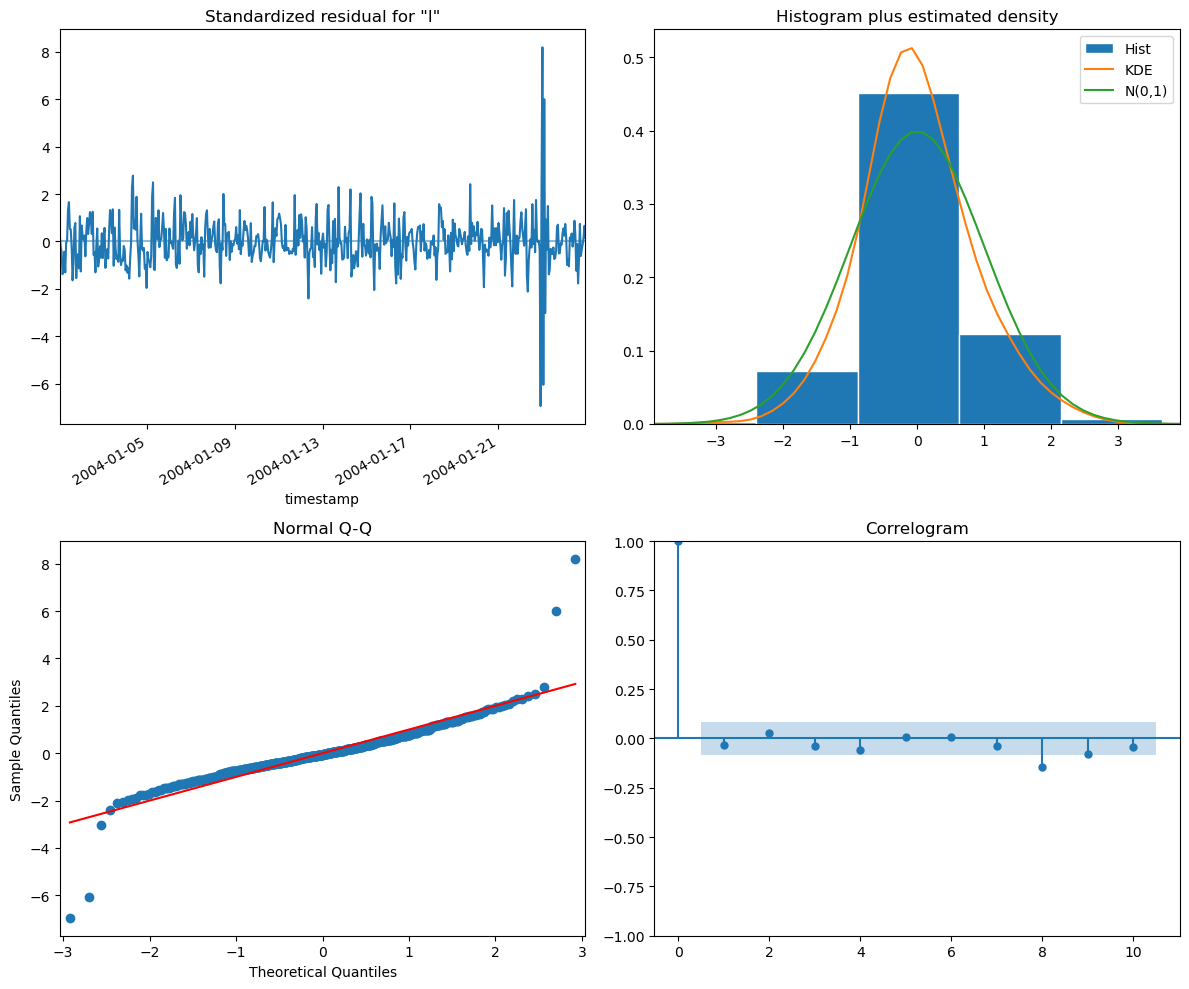

In [149]:
# Diagnostics (for (1,3,0,0))

import statsmodels.api as sm
SARIMA_model = sm.tsa.statespace.SARIMAX(
        endog = load_long_z1_2004_jan_train["log_load_rs"].asfreq('h'), 
        exog = load_long_z1_2004_jan_train[["HDK", "CDK", "holiday", "trend", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h'), 
        order=(1,0,3),  # non-seasonal: with no differencing
        seasonal_order=(0,0,0,24), # seasonal: with no seasonal differencing
        trend="c"
        )

SARIMA_model_fit = SARIMA_model.fit(disp=False, maxiter=500)
SARIMA_model_fit.plot_diagnostics(figsize=(12,10))
plt.tight_layout()
plt.show()

Residual plot appears to have slightly improved, but deviation is still heavy at tails.
> Distribution more similar to Gaussian dist.

In [150]:
# Creating test data
load_long_z1_2004_jan_test = mul_df.loc[mul_df.month == 1,:]
load_long_z1_2004_jan_test = load_long_z1_2004_jan_test.set_index("timestamp")
load_long_z1_2004_jan_test = load_long_z1_2004_jan_test['2004-01-25 00:30:00':]
load_long_z1_2004_jan_test.index = pd.to_datetime(load_long_z1_2004_jan_test.index)
load_long_z1_2004_jan_test.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-01-25 00:30:00  2004      1   25  00:30     3.094174      21.155292   
2004-01-25 01:30:00  2004      1   25  01:30     3.101713      20.058817   
2004-01-25 02:30:00  2004      1   25  02:30     3.144626      19.051006   
2004-01-25 03:30:00  2004      1   25  03:30     3.160441      18.246300   
2004-01-25 04:30:00  2004      1   25  04:30     3.197407      17.700175   

                     holiday        HDK  CDK  
timestamp                                     
2004-01-25 00:30:00        0  33.844708  0.0  
2004-01-25 01:30:00        0  34.941183  0.0  
2004-01-25 02:30:00        0  35.948994  0.0  
2004-01-25 03:30:00        0  36.753700  0.0  
2004-01-25 04:30:00        0  37.299825  0.0

In [151]:
# Defining the sine wave
dp = DeterministicProcess(
    index=load_long_z1_2004_jan_test.index,
    period=None,         # It's not defined so that frequency can be read from the index
    constant=False,      # Let regression model define this intercept later on
    order=1,             # allows trend to be included so that the level of the wave is allowed to change with time, linearly 
    seasonal=False,      # no seasonal dummies
    additional_terms=[periodicity], # 2 seperate waves will be generated
    drop=True            # if perfect collinearity exists, the terms can be dropped
)

waves = dp.in_sample()
waves.head()

trend  sin(1,24)  cos(1,24)  sin(2,24)     cos(2,24)
timestamp                                                                
2004-01-25 00:30:00    1.0   0.000000   1.000000   0.000000  1.000000e+00
2004-01-25 01:30:00    2.0   0.258819   0.965926   0.500000  8.660254e-01
2004-01-25 02:30:00    3.0   0.500000   0.866025   0.866025  5.000000e-01
2004-01-25 03:30:00    4.0   0.707107   0.707107   1.000000  6.123234e-17
2004-01-25 04:30:00    5.0   0.866025   0.500000   0.866025 -5.000000e-01

In [152]:
# Combining fourier terms with other variables - test set
load_long_z1_2004_jan_test = load_long_z1_2004_jan_test.merge(waves, on='timestamp', how='left')
load_long_z1_2004_jan_test.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-01-25 00:30:00  2004      1   25  00:30     3.094174      21.155292   
2004-01-25 01:30:00  2004      1   25  01:30     3.101713      20.058817   
2004-01-25 02:30:00  2004      1   25  02:30     3.144626      19.051006   
2004-01-25 03:30:00  2004      1   25  03:30     3.160441      18.246300   
2004-01-25 04:30:00  2004      1   25  04:30     3.197407      17.700175   

                     holiday        HDK  CDK  trend  sin(1,24)  cos(1,24)  \
timestamp                                                                   
2004-01-25 00:30:00        0  33.844708  0.0    1.0   0.000000   1.000000   
2004-01-25 01:30:00        0  34.941183  0.0    2.0   0.258819   0.965926   
2004-01-25 02:30:00        0  35.948994  0.0    3.0   0.500000   0.866025   
2004-01-25 03:30:00        0  36.753700  0.0    4.0   0.707107   0.707107   
2004-01-25 04:30:00        0  37.299825  0.0    5.0   0.866025   0.500000   

                     sin(2,24)     cos(2,24)  
timestamp                                     
2004-01-25 00:30:00   0.000000  1.000000e+00  
2004-01-25 01:30:00   0.500000  8.660254e-01  
2004-01-25 02:30:00   0.866025  5.000000e-01  
2004-01-25 03:30:00   1.000000  6.123234e-17  
2004-01-25 04:30:00   0.866025 -5.000000e-01

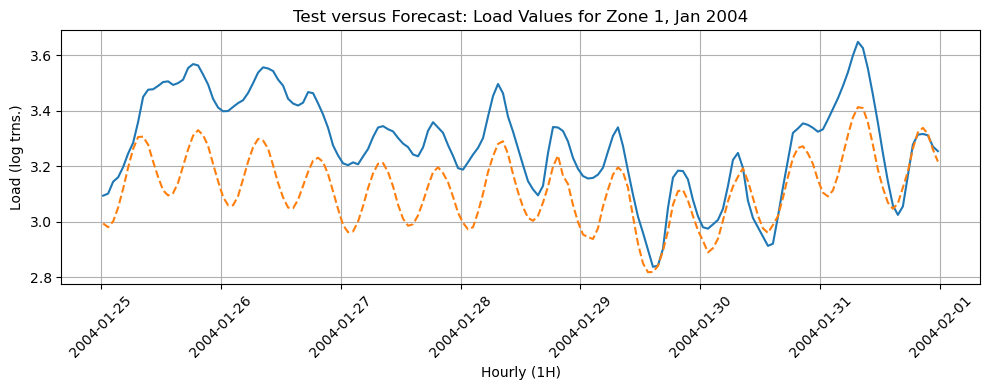

In [153]:
# Predicting 24*7 steps ahead
forecast_jan04 = SARIMA_model_fit.get_forecast(
    steps=24*7, 
    exog = load_long_z1_2004_jan_test[["HDK", "CDK", "holiday", "trend", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h')
).predicted_mean

# Fit on the test data
import seaborn as sns
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=load_long_z1_2004_jan_test, x=load_long_z1_2004_jan_test.index, y=load_long_z1_2004_jan_test["log_load_rs"].asfreq('h'), ax=ax)
sns.lineplot(forecast_jan04, linestyle = '--')
ax.set_title("Test versus Forecast: Load Values for Zone 1, Jan 2004")
ax.set_xlabel("Hourly (1H)")
ax.set_ylabel("Load (log trns.)")
ax.grid(True)
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

In [154]:
# Performance on test set

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print(f"R2 score: {r2_score(load_long_z1_2004_jan_test.log_load_rs, forecast_jan04)}")
print(f'MSE score: {mean_squared_error(load_long_z1_2004_jan_test.log_load_rs, forecast_jan04)}')
print(f'MAE score: {mean_absolute_error(load_long_z1_2004_jan_test.log_load_rs, forecast_jan04)}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_2004_jan_test.log_load_rs, forecast_jan04)}')

R2 score: -0.23131463719646295
MSE score: 0.03760624430728527
MAE score: 0.1658821346127938
MAPE score: 0.04953984290440757


##### Testing on Last Week of Apr 2004 (Zone 1)
Last week of Apr 2004 is used for testing. Multiple SARIMAX models are evaluated and compared. 

In [155]:
# Creating training data
load_long_z1_2004_apr_train = mul_df.loc[mul_df.month == 4,:]
load_long_z1_2004_apr_train = load_long_z1_2004_apr_train.set_index("timestamp")
load_long_z1_2004_apr_train = load_long_z1_2004_apr_train[:'2004-04-23 23:30:00']
load_long_z1_2004_apr_train.index = pd.to_datetime(load_long_z1_2004_apr_train.index)
load_long_z1_2004_apr_train.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-04-01 00:30:00  2004      4    1  00:30     2.645820      45.453562   
2004-04-01 01:30:00  2004      4    1  01:30     2.633901      45.547368   
2004-04-01 02:30:00  2004      4    1  02:30     2.633039      45.454863   
2004-04-01 03:30:00  2004      4    1  03:30     2.646246      45.454863   
2004-04-01 04:30:00  2004      4    1  04:30     2.688528      45.191047   

                     holiday       HDK  CDK  
timestamp                                    
2004-04-01 00:30:00        0  9.546438  0.0  
2004-04-01 01:30:00        0  9.452632  0.0  
2004-04-01 02:30:00        0  9.545137  0.0  
2004-04-01 03:30:00        0  9.545137  0.0  
2004-04-01 04:30:00        0  9.808953  0.0

In [156]:
# Defining the sine wave
dp = DeterministicProcess(
    index=load_long_z1_2004_apr_train.index,
    period=None,         # It's not defined so that frequency can be read from the index
    constant=False,      # Let regression model define this intercept later on
    order=1,             # SARIMAX includes differencing, so trend would be redundant
    seasonal=False,      # no seasonal dummies
    additional_terms=[periodicity], # 2 seperate waves will be generated
    drop=True            # if perfect collinearity exists, the terms can be dropped
)

waves = dp.in_sample()

# Combining fourier terms with other variables
load_long_z1_2004_apr_train = load_long_z1_2004_apr_train.merge(waves, on='timestamp', how='left')
load_long_z1_2004_apr_train.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-04-01 00:30:00  2004      4    1  00:30     2.645820      45.453562   
2004-04-01 01:30:00  2004      4    1  01:30     2.633901      45.547368   
2004-04-01 02:30:00  2004      4    1  02:30     2.633039      45.454863   
2004-04-01 03:30:00  2004      4    1  03:30     2.646246      45.454863   
2004-04-01 04:30:00  2004      4    1  04:30     2.688528      45.191047   

                     holiday       HDK  CDK  trend  sin(1,24)  cos(1,24)  \
timestamp                                                                  
2004-04-01 00:30:00        0  9.546438  0.0    1.0   0.000000   1.000000   
2004-04-01 01:30:00        0  9.452632  0.0    2.0   0.258819   0.965926   
2004-04-01 02:30:00        0  9.545137  0.0    3.0   0.500000   0.866025   
2004-04-01 03:30:00        0  9.545137  0.0    4.0   0.707107   0.707107   
2004-04-01 04:30:00        0  9.808953  0.0    5.0   0.866025   0.500000   

                     sin(2,24)     cos(2,24)  
timestamp                                     
2004-04-01 00:30:00   0.000000  1.000000e+00  
2004-04-01 01:30:00   0.500000  8.660254e-01  
2004-04-01 02:30:00   0.866025  5.000000e-01  
2004-04-01 03:30:00   1.000000  6.123234e-17  
2004-04-01 04:30:00   0.866025 -5.000000e-01

In [157]:
# Comparing models - auto_arima

smodel_apr = pm.auto_arima(y = load_long_z1_2004_apr_train["log_load_rs"].asfreq('h'), 
                           X = load_long_z1_2004_apr_train[["HDK", "CDK", "holiday", "trend", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h'),
                           start_p=0, start_q=0,test='adf',
                           max_p=3, max_q=3, m=24,
                           start_P=0, start_Q=0, max_P=0, max_Q=0, seasonal=True,
                           d=0, D=0, trace=True,
                           trend="c",
                           error_action='trace',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=-834.394, Time=0.95 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=-1736.556, Time=0.66 sec
 ARIMA(0,0,1)(0,0,0)[24] intercept   : AIC=-633.186, Time=0.89 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=-834.394, Time=0.89 sec
 ARIMA(2,0,0)(0,0,0)[24] intercept   : AIC=-1860.205, Time=0.74 sec
 ARIMA(3,0,0)(0,0,0)[24] intercept   : AIC=-1868.166, Time=0.93 sec
 ARIMA(3,0,1)(0,0,0)[24] intercept   : AIC=-1941.874, Time=1.14 sec
 ARIMA(2,0,1)(0,0,0)[24] intercept   : AIC=-1928.419, Time=0.96 sec
 ARIMA(3,0,2)(0,0,0)[24] intercept   : AIC=-1896.742, Time=1.07 sec
 ARIMA(2,0,2)(0,0,0)[24] intercept   : AIC=-1954.835, Time=1.00 sec
 ARIMA(1,0,2)(0,0,0)[24] intercept   : AIC=-1986.229, Time=0.92 sec
 ARIMA(0,0,2)(0,0,0)[24] intercept   : AIC=-1204.420, Time=1.02 sec
 ARIMA(1,0,1)(0,0,0)[24] intercept   : AIC=-1979.910, Time=0.66 sec
 ARIMA(1,0,3)(0,0,0)[24] intercept   : AIC=-1919.401, Time=0.99 sec
 ARIMA(0

The best order for AR/MA components (seasonal and non-seasonal) has again changed, compared to SARIMAX without external regressors.

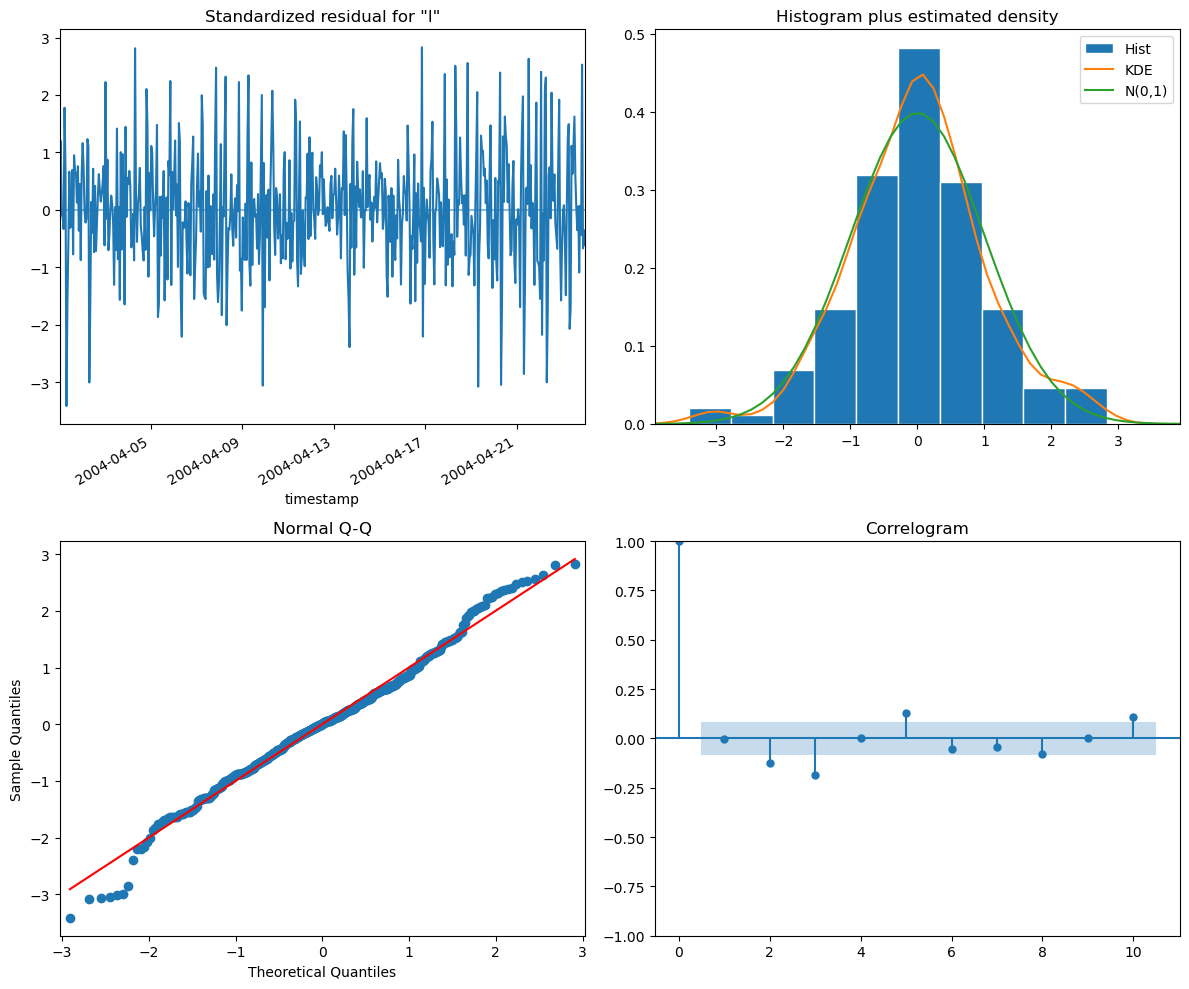

In [159]:
# Diagnostics (for (1,2,0,0))

import statsmodels.api as sm
SARIMA_model = sm.tsa.statespace.SARIMAX(
        endog = load_long_z1_2004_apr_train["log_load_rs"].asfreq('h'), 
        exog = load_long_z1_2004_apr_train[["HDK", "CDK", "holiday", "trend", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h'), 
        order=(1,0,2),  # non-seasonal: with no differencing
        seasonal_order=(0,0,0,24), # seasonal: with seasonal differencing
        trend="c")

SARIMA_model_fit = SARIMA_model.fit(disp=False, maxiter=500)
SARIMA_model_fit.plot_diagnostics(figsize=(12,10))
plt.tight_layout()
plt.show()

In [160]:
# Creating test data
load_long_z1_2004_apr_test = mul_df.loc[mul_df.month == 4,:]
load_long_z1_2004_apr_test = load_long_z1_2004_apr_test.set_index("timestamp")
load_long_z1_2004_apr_test = load_long_z1_2004_apr_test['2004-04-24 00:30:00':]
load_long_z1_2004_apr_test.index = pd.to_datetime(load_long_z1_2004_apr_test.index)
load_long_z1_2004_apr_test.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-04-24 00:30:00  2004      4   24  00:30     2.437728      62.266565   
2004-04-24 01:30:00  2004      4   24  01:30     2.328643      62.708075   
2004-04-24 02:30:00  2004      4   24  02:30     2.279316      61.449205   
2004-04-24 03:30:00  2004      4   24  03:30     2.249290      60.634717   
2004-04-24 04:30:00  2004      4   24  04:30     2.248657      59.824237   

                     holiday  HDK  CDK  
timestamp                               
2004-04-24 00:30:00        0  0.0  0.0  
2004-04-24 01:30:00        0  0.0  0.0  
2004-04-24 02:30:00        0  0.0  0.0  
2004-04-24 03:30:00        0  0.0  0.0  
2004-04-24 04:30:00        0  0.0  0.0

In [161]:
# Defining the sine wave
dp = DeterministicProcess(
    index=load_long_z1_2004_apr_test.index,
    period=None,         # It's not defined so that frequency can be read from the index
    constant=False,      # Let regression model define this intercept later on
    order=1,             # allows trend to be included so that the level of the wave is allowed to change with time, linearly 
    seasonal=False,      # no seasonal dummies
    additional_terms=[periodicity], # 2 seperate waves will be generated
    drop=True            # if perfect collinearity exists, the terms can be dropped
)

waves = dp.in_sample()

# Combining fourier terms with other variables - test set
load_long_z1_2004_apr_test = load_long_z1_2004_apr_test.merge(waves, on='timestamp', how='left')
load_long_z1_2004_apr_test.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-04-24 00:30:00  2004      4   24  00:30     2.437728      62.266565   
2004-04-24 01:30:00  2004      4   24  01:30     2.328643      62.708075   
2004-04-24 02:30:00  2004      4   24  02:30     2.279316      61.449205   
2004-04-24 03:30:00  2004      4   24  03:30     2.249290      60.634717   
2004-04-24 04:30:00  2004      4   24  04:30     2.248657      59.824237   

                     holiday  HDK  CDK  trend  sin(1,24)  cos(1,24)  \
timestamp                                                             
2004-04-24 00:30:00        0  0.0  0.0    1.0   0.000000   1.000000   
2004-04-24 01:30:00        0  0.0  0.0    2.0   0.258819   0.965926   
2004-04-24 02:30:00        0  0.0  0.0    3.0   0.500000   0.866025   
2004-04-24 03:30:00        0  0.0  0.0    4.0   0.707107   0.707107   
2004-04-24 04:30:00        0  0.0  0.0    5.0   0.866025   0.500000   

                     sin(2,24)     cos(2,24)  
timestamp                                     
2004-04-24 00:30:00   0.000000  1.000000e+00  
2004-04-24 01:30:00   0.500000  8.660254e-01  
2004-04-24 02:30:00   0.866025  5.000000e-01  
2004-04-24 03:30:00   1.000000  6.123234e-17  
2004-04-24 04:30:00   0.866025 -5.000000e-01

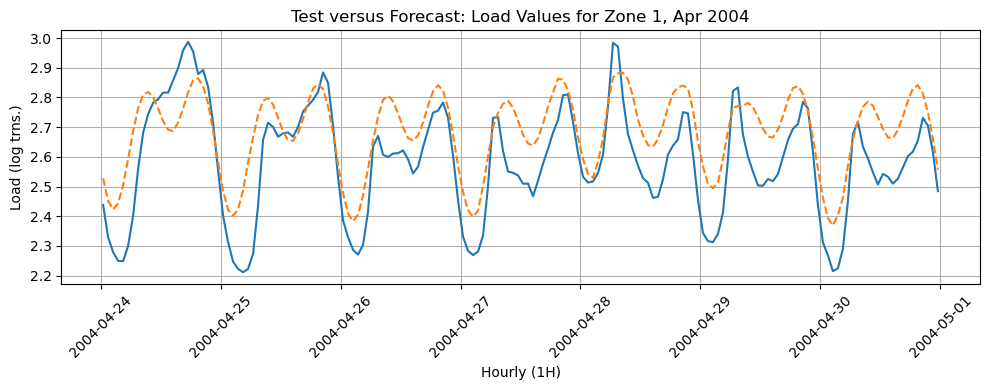

In [162]:
# Predicting 24*7 steps ahead
forecast_apr04 = SARIMA_model_fit.get_forecast(
    steps=24*7, 
    exog = load_long_z1_2004_apr_test[["HDK", "CDK", "holiday", "trend", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h')
).predicted_mean

# Fit on the test data
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=load_long_z1_2004_apr_test, x=load_long_z1_2004_apr_test.index, y=load_long_z1_2004_apr_test.log_load_rs.asfreq('h'), ax=ax)
sns.lineplot(forecast_apr04, linestyle = '--')
ax.set_title("Test versus Forecast: Load Values for Zone 1, Apr 2004")
ax.set_xlabel("Hourly (1H)")
ax.set_ylabel("Load (log trns.)")
ax.grid(True)
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

In [163]:
# Performance on test set

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print(f"R2 score: {r2_score(load_long_z1_2004_apr_test.log_load_rs, forecast_apr04)}")
print(f'MSE score: {mean_squared_error(load_long_z1_2004_apr_test.log_load_rs, forecast_apr04)}')
print(f'MAE score: {mean_absolute_error(load_long_z1_2004_apr_test.log_load_rs, forecast_apr04)}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_2004_apr_test.log_load_rs, forecast_apr04)}')

R2 score: 0.40713156123420646
MSE score: 0.020279707963904325
MAE score: 0.12225306087033136
MAPE score: 0.04867670467368603


##### Testing on Last Week of Jul 2004 (Zone 1)
Last week of Jul 2004 is used for testing. Multiple SARIMAX models are evaluated and compared. 

In [164]:
# Creating training data
load_long_z1_2004_jul_train = mul_df.loc[mul_df.month == 7,:]
load_long_z1_2004_jul_train = load_long_z1_2004_jul_train.set_index("timestamp")
load_long_z1_2004_jul_train = load_long_z1_2004_jul_train[:'2004-07-24 23:30:00']
load_long_z1_2004_jul_train.index = pd.to_datetime(load_long_z1_2004_jul_train.index)
load_long_z1_2004_jul_train.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-07-01 00:30:00  2004      7    1  00:30     2.658230      67.152732   
2004-07-01 01:30:00  2004      7    1  01:30     2.548507      66.148285   
2004-07-01 02:30:00  2004      7    1  02:30     2.482404      65.687669   
2004-07-01 03:30:00  2004      7    1  03:30     2.447464      64.515455   
2004-07-01 04:30:00  2004      7    1  04:30     2.430626      64.517938   

                     holiday  HDK       CDK  
timestamp                                    
2004-07-01 00:30:00        0  0.0  2.152732  
2004-07-01 01:30:00        0  0.0  1.148285  
2004-07-01 02:30:00        0  0.0  0.687669  
2004-07-01 03:30:00        0  0.0  0.000000  
2004-07-01 04:30:00        0  0.0  0.000000

In [165]:
# Defining the sine wave
dp = DeterministicProcess(
    index=load_long_z1_2004_jul_train.index,
    period=None,         # It's not defined so that frequency can be read from the index
    constant=False,      # Let regression model define this intercept later on
    order=1,             
    seasonal=False,      # no seasonal dummies
    additional_terms=[periodicity], # 2 seperate waves will be generated
    drop=True            # if perfect collinearity exists, the terms can be dropped
)

waves = dp.in_sample()

# Combining fourier terms with other variables
load_long_z1_2004_jul_train = load_long_z1_2004_jul_train.merge(waves, on='timestamp', how='left')
load_long_z1_2004_jul_train.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-07-01 00:30:00  2004      7    1  00:30     2.658230      67.152732   
2004-07-01 01:30:00  2004      7    1  01:30     2.548507      66.148285   
2004-07-01 02:30:00  2004      7    1  02:30     2.482404      65.687669   
2004-07-01 03:30:00  2004      7    1  03:30     2.447464      64.515455   
2004-07-01 04:30:00  2004      7    1  04:30     2.430626      64.517938   

                     holiday  HDK       CDK  trend  sin(1,24)  cos(1,24)  \
timestamp                                                                  
2004-07-01 00:30:00        0  0.0  2.152732    1.0   0.000000   1.000000   
2004-07-01 01:30:00        0  0.0  1.148285    2.0   0.258819   0.965926   
2004-07-01 02:30:00        0  0.0  0.687669    3.0   0.500000   0.866025   
2004-07-01 03:30:00        0  0.0  0.000000    4.0   0.707107   0.707107   
2004-07-01 04:30:00        0  0.0  0.000000    5.0   0.866025   0.500000   

                     sin(2,24)     cos(2,24)  
timestamp                                     
2004-07-01 00:30:00   0.000000  1.000000e+00  
2004-07-01 01:30:00   0.500000  8.660254e-01  
2004-07-01 02:30:00   0.866025  5.000000e-01  
2004-07-01 03:30:00   1.000000  6.123234e-17  
2004-07-01 04:30:00   0.866025 -5.000000e-01

In [166]:
# Comparing models - auto_arima (no differencing)

smodel_jul = pm.auto_arima(y = load_long_z1_2004_jul_train["log_load_rs"].asfreq('h'), 
                           X = load_long_z1_2004_jul_train[["HDK", "CDK", "holiday", "trend", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h'),
                           start_p=0, start_q=0,test='adf',
                           max_p=3, max_q=3, m=24,
                           start_P=0, start_Q=0, max_P=0, max_Q=0, seasonal=True,
                           d=0, D=0, trace=True,
                           trend="c",
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=-867.715, Time=0.65 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=-2337.461, Time=0.72 sec
 ARIMA(0,0,1)(0,0,0)[24] intercept   : AIC=48.838, Time=0.75 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=-867.715, Time=0.65 sec
 ARIMA(2,0,0)(0,0,0)[24] intercept   : AIC=-2381.776, Time=1.02 sec
 ARIMA(3,0,0)(0,0,0)[24] intercept   : AIC=-2085.150, Time=1.12 sec
 ARIMA(2,0,1)(0,0,0)[24] intercept   : AIC=-2099.630, Time=0.98 sec
 ARIMA(1,0,1)(0,0,0)[24] intercept   : AIC=-2549.686, Time=0.81 sec
 ARIMA(1,0,2)(0,0,0)[24] intercept   : AIC=-2392.616, Time=1.33 sec
 ARIMA(0,0,2)(0,0,0)[24] intercept   : AIC=-1205.812, Time=0.97 sec
 ARIMA(2,0,2)(0,0,0)[24] intercept   : AIC=-2296.134, Time=1.16 sec
 ARIMA(1,0,1)(0,0,0)[24]             : AIC=-2549.686, Time=0.80 sec

Best model:  ARIMA(1,0,1)(0,0,0)[24]          
Total fit time: 10.948 seconds


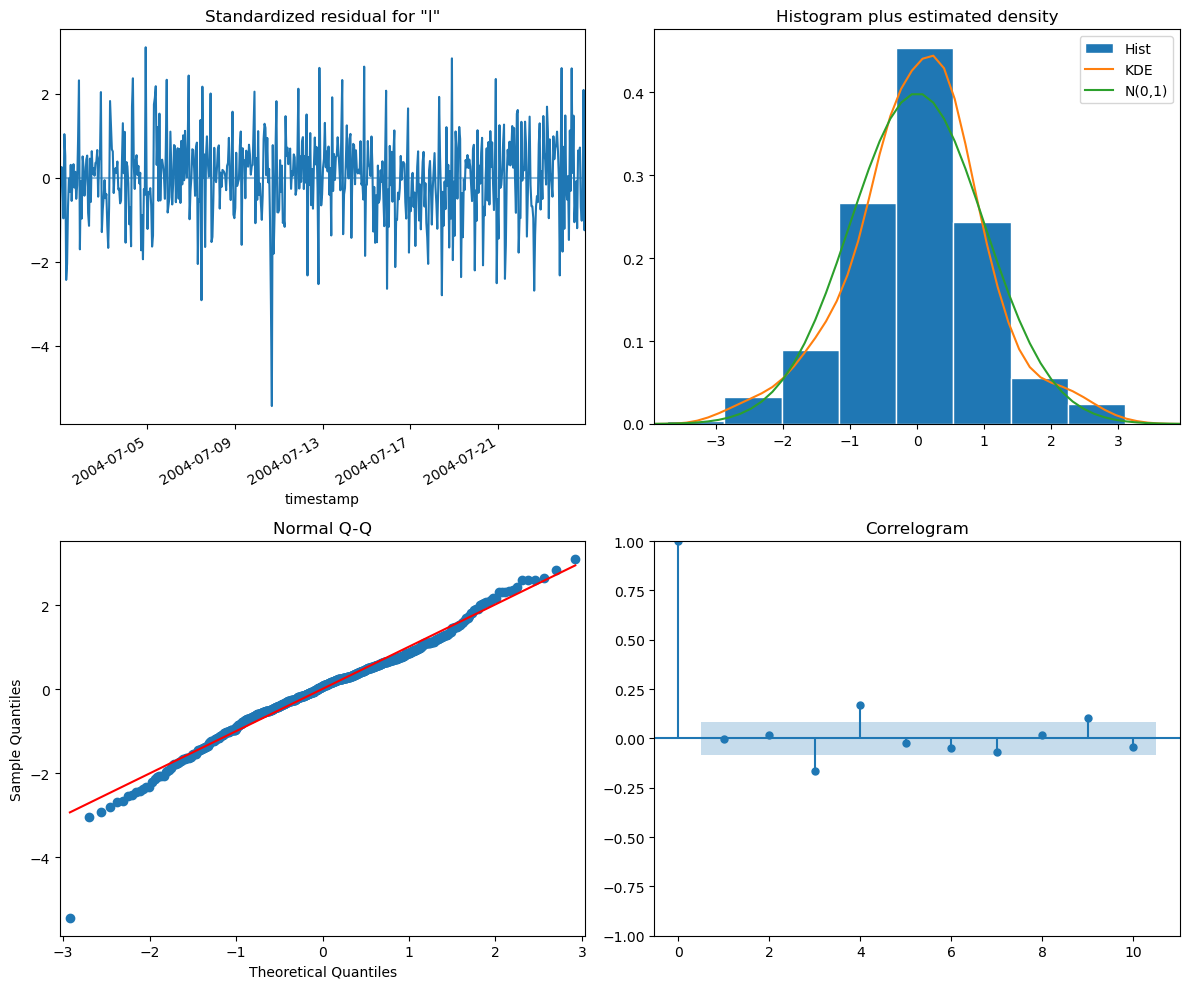

In [167]:
# Diagnostics (for (1,1,0,0))

SARIMA_model = sm.tsa.statespace.SARIMAX(
        endog = load_long_z1_2004_jul_train["log_load_rs"].asfreq('h'), 
        exog = load_long_z1_2004_jul_train[["HDK", "CDK", "holiday", "trend", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h'), 
        order=(1,0,1),  # non-seasonal: with no differencing
        seasonal_order=(0,0,0,24), # seasonal: with no seasonal differencing
        trend="c")

SARIMA_model_fit = SARIMA_model.fit(disp=False, maxiter=500)
SARIMA_model_fit.plot_diagnostics(figsize=(12,10))
plt.tight_layout()
plt.show()

In [168]:
# Creating test data
load_long_z1_2004_jul_test = mul_df.loc[mul_df.month == 7,:]
load_long_z1_2004_jul_test = load_long_z1_2004_jul_test.set_index("timestamp")
load_long_z1_2004_jul_test = load_long_z1_2004_jul_test['2004-07-25 00:30:00':]
load_long_z1_2004_jul_test.index = pd.to_datetime(load_long_z1_2004_jul_test.index)
load_long_z1_2004_jul_test.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-07-25 00:30:00  2004      7   25  00:30     2.669517      70.616043   
2004-07-25 01:30:00  2004      7   25  01:30     2.551552      70.893317   
2004-07-25 02:30:00  2004      7   25  02:30     2.486073      70.710504   
2004-07-25 03:30:00  2004      7   25  03:30     2.441738      70.526899   
2004-07-25 04:30:00  2004      7   25  04:30     2.429834      70.527349   

                     holiday  HDK       CDK  
timestamp                                    
2004-07-25 00:30:00        0  0.0  5.616043  
2004-07-25 01:30:00        0  0.0  5.893317  
2004-07-25 02:30:00        0  0.0  5.710504  
2004-07-25 03:30:00        0  0.0  5.526899  
2004-07-25 04:30:00        0  0.0  5.527349

In [169]:
# Defining the sine wave
dp = DeterministicProcess(
    index=load_long_z1_2004_jul_test.index,
    period=None,         # It's not defined so that frequency can be read from the index
    constant=False,      # Let regression model define this intercept later on
    order=1,              
    seasonal=False,      # no seasonal dummies
    additional_terms=[periodicity], # 2 seperate waves will be generated
    drop=True            # if perfect collinearity exists, the terms can be dropped
)

waves = dp.in_sample()

# Combining fourier terms with other variables - test set
load_long_z1_2004_jul_test = load_long_z1_2004_jul_test.merge(waves, on='timestamp', how='left')
load_long_z1_2004_jul_test.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-07-25 00:30:00  2004      7   25  00:30     2.669517      70.616043   
2004-07-25 01:30:00  2004      7   25  01:30     2.551552      70.893317   
2004-07-25 02:30:00  2004      7   25  02:30     2.486073      70.710504   
2004-07-25 03:30:00  2004      7   25  03:30     2.441738      70.526899   
2004-07-25 04:30:00  2004      7   25  04:30     2.429834      70.527349   

                     holiday  HDK       CDK  trend  sin(1,24)  cos(1,24)  \
timestamp                                                                  
2004-07-25 00:30:00        0  0.0  5.616043    1.0   0.000000   1.000000   
2004-07-25 01:30:00        0  0.0  5.893317    2.0   0.258819   0.965926   
2004-07-25 02:30:00        0  0.0  5.710504    3.0   0.500000   0.866025   
2004-07-25 03:30:00        0  0.0  5.526899    4.0   0.707107   0.707107   
2004-07-25 04:30:00        0  0.0  5.527349    5.0   0.866025   0.500000   

                     sin(2,24)     cos(2,24)  
timestamp                                     
2004-07-25 00:30:00   0.000000  1.000000e+00  
2004-07-25 01:30:00   0.500000  8.660254e-01  
2004-07-25 02:30:00   0.866025  5.000000e-01  
2004-07-25 03:30:00   1.000000  6.123234e-17  
2004-07-25 04:30:00   0.866025 -5.000000e-01

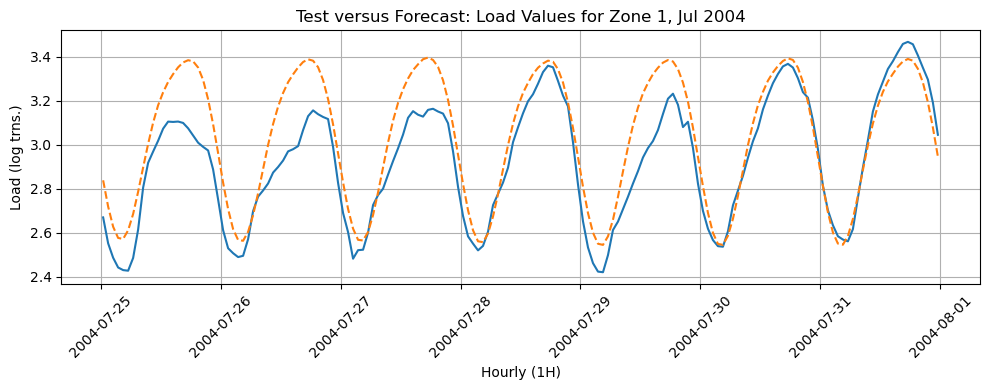

In [170]:
# Predicting 24*7 steps ahead
forecast_jul04 = SARIMA_model_fit.get_forecast(
    steps=24*7, 
    exog = load_long_z1_2004_jul_test[["HDK", "CDK", "holiday", "trend", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h')
).predicted_mean

# Fit on the test data
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=load_long_z1_2004_jul_test, x=load_long_z1_2004_jul_test.index, y=load_long_z1_2004_jul_test.log_load_rs.asfreq('h'), ax=ax)
sns.lineplot(forecast_jul04, linestyle = '--')
ax.set_title("Test versus Forecast: Load Values for Zone 1, Jul 2004")
ax.set_xlabel("Hourly (1H)")
ax.set_ylabel("Load (log trns.)")
ax.grid(True)
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

In [171]:
# Performance on test set

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print(f"R2 score: {r2_score(load_long_z1_2004_jul_test.log_load_rs, forecast_jul04)}")
print(f'MSE score: {mean_squared_error(load_long_z1_2004_jul_test.log_load_rs, forecast_jul04)}')
print(f'MAE score: {mean_absolute_error(load_long_z1_2004_jul_test.log_load_rs, forecast_jul04)}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_2004_jul_test.log_load_rs, forecast_jul04)}')

R2 score: 0.704947128067944
MSE score: 0.02330201832840338
MAE score: 0.12318974429976484
MAPE score: 0.0422411831395949


##### Testing on Last Week of Oct 2004 (Zone 1)
Last week of Oct 2004 is used for testing. Multiple SARIMAX models are evaluated and compared. 

In [172]:
# Creating training data
load_long_z1_2004_oct_train = mul_df.loc[mul_df.month == 10,:]
load_long_z1_2004_oct_train = load_long_z1_2004_oct_train.set_index("timestamp")
load_long_z1_2004_oct_train = load_long_z1_2004_oct_train[:'2004-10-24 23:30:00']
load_long_z1_2004_oct_train.index = pd.to_datetime(load_long_z1_2004_oct_train.index)
load_long_z1_2004_oct_train.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-10-01 00:30:00  2004     10    1  00:30     2.410093      60.792180   
2004-10-01 01:30:00  2004     10    1  01:30     2.324444      60.513850   
2004-10-01 02:30:00  2004     10    1  02:30     2.293544      60.152501   
2004-10-01 03:30:00  2004     10    1  03:30     2.289399      59.693854   
2004-10-01 04:30:00  2004     10    1  04:30     2.303684      59.417333   

                     holiday  HDK  CDK  
timestamp                               
2004-10-01 00:30:00        0  0.0  0.0  
2004-10-01 01:30:00        0  0.0  0.0  
2004-10-01 02:30:00        0  0.0  0.0  
2004-10-01 03:30:00        0  0.0  0.0  
2004-10-01 04:30:00        0  0.0  0.0

In [173]:
# Defining the sine wave
dp = DeterministicProcess(
    index=load_long_z1_2004_oct_train.index,
    period=None,         # It's not defined so that frequency can be read from the index
    constant=False,      # Let regression model define this intercept later on
    order=1,             
    seasonal=False,      # no seasonal dummies
    additional_terms=[periodicity], # 2 seperate waves will be generated
    drop=True            # if perfect collinearity exists, the terms can be dropped
)

waves = dp.in_sample()

# Combining fourier terms with other variables
load_long_z1_2004_oct_train = load_long_z1_2004_oct_train.merge(waves, on='timestamp', how='left')
load_long_z1_2004_oct_train.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-10-01 00:30:00  2004     10    1  00:30     2.410093      60.792180   
2004-10-01 01:30:00  2004     10    1  01:30     2.324444      60.513850   
2004-10-01 02:30:00  2004     10    1  02:30     2.293544      60.152501   
2004-10-01 03:30:00  2004     10    1  03:30     2.289399      59.693854   
2004-10-01 04:30:00  2004     10    1  04:30     2.303684      59.417333   

                     holiday  HDK  CDK  trend  sin(1,24)  cos(1,24)  \
timestamp                                                             
2004-10-01 00:30:00        0  0.0  0.0    1.0   0.000000   1.000000   
2004-10-01 01:30:00        0  0.0  0.0    2.0   0.258819   0.965926   
2004-10-01 02:30:00        0  0.0  0.0    3.0   0.500000   0.866025   
2004-10-01 03:30:00        0  0.0  0.0    4.0   0.707107   0.707107   
2004-10-01 04:30:00        0  0.0  0.0    5.0   0.866025   0.500000   

                     sin(2,24)     cos(2,24)  
timestamp                                     
2004-10-01 00:30:00   0.000000  1.000000e+00  
2004-10-01 01:30:00   0.500000  8.660254e-01  
2004-10-01 02:30:00   0.866025  5.000000e-01  
2004-10-01 03:30:00   1.000000  6.123234e-17  
2004-10-01 04:30:00   0.866025 -5.000000e-01

In [174]:
# Comparing models - auto_arima (no differencing)

smodel_jul = pm.auto_arima(y = load_long_z1_2004_oct_train["log_load_rs"].asfreq('h'), 
                           X = load_long_z1_2004_oct_train[["HDK", "CDK", "holiday", "trend", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h'),
                           start_p=0, start_q=0,test='adf',
                           max_p=3, max_q=3, m=24,
                           start_P=0, start_Q=0, max_P=0, max_Q=0, seasonal=True,
                           d=0, D=0, trace=True,
                           trend="c",
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=-390.996, Time=0.64 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=-2043.748, Time=0.69 sec
 ARIMA(0,0,1)(0,0,0)[24] intercept   : AIC=-644.384, Time=0.95 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=-390.996, Time=0.65 sec
 ARIMA(2,0,0)(0,0,0)[24] intercept   : AIC=-2147.819, Time=1.04 sec
 ARIMA(3,0,0)(0,0,0)[24] intercept   : AIC=-2104.567, Time=1.09 sec
 ARIMA(2,0,1)(0,0,0)[24] intercept   : AIC=-2176.615, Time=1.05 sec
 ARIMA(1,0,1)(0,0,0)[24] intercept   : AIC=-2208.591, Time=1.04 sec
 ARIMA(1,0,2)(0,0,0)[24] intercept   : AIC=-2220.415, Time=1.10 sec
 ARIMA(0,0,2)(0,0,0)[24] intercept   : AIC=-147.288, Time=0.97 sec
 ARIMA(2,0,2)(0,0,0)[24] intercept   : AIC=-2137.466, Time=1.15 sec
 ARIMA(1,0,3)(0,0,0)[24] intercept   : AIC=-2191.213, Time=1.13 sec
 ARIMA(0,0,3)(0,0,0)[24] intercept   : AIC=-940.830, Time=1.10 sec
 ARIMA(2,0,3)(0,0,0)[24] intercept   : AIC=-2158.307, Time=1.17 sec
 ARIMA(1,0

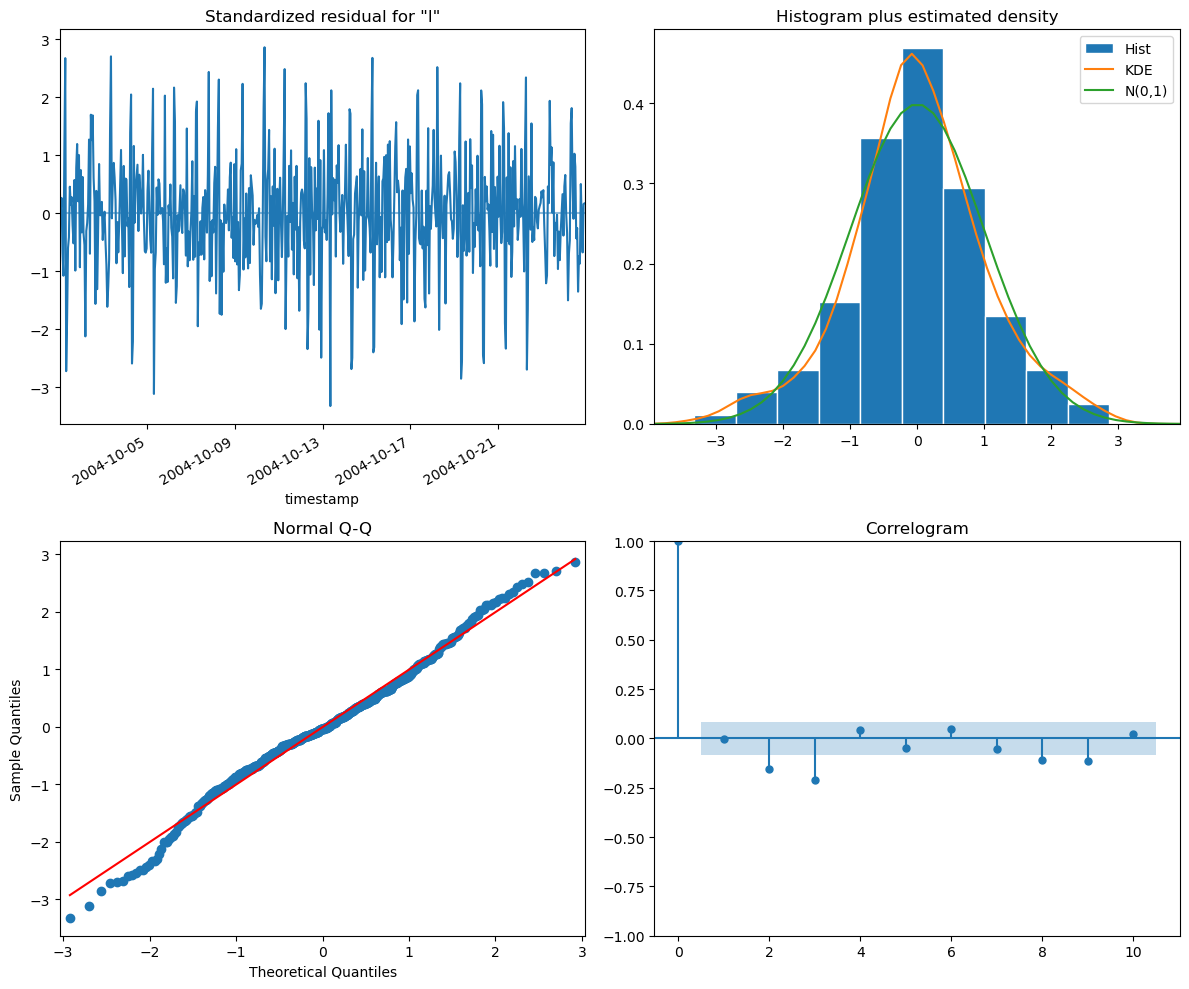

In [175]:
# Diagnostics (for (1,2,0,0)) - no differencing

SARIMA_model = sm.tsa.statespace.SARIMAX(
        endog = load_long_z1_2004_oct_train["log_load_rs"].asfreq('h'), 
        exog = load_long_z1_2004_oct_train[["HDK", "CDK", "holiday", "trend", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h'), 
        order=(1,0,2),  # non-seasonal: with no differencing
        seasonal_order=(0,0,0,24), # seasonal: with seasonal differencing
        trend="c")

SARIMA_model_fit = SARIMA_model.fit(disp=False, maxiter=500)
SARIMA_model_fit.plot_diagnostics(figsize=(12,10))
plt.tight_layout()
plt.show()

In [176]:
# Creating test data
load_long_z1_2004_oct_test = mul_df.loc[mul_df.month == 10,:]
load_long_z1_2004_oct_test = load_long_z1_2004_oct_test.set_index("timestamp")
load_long_z1_2004_oct_test = load_long_z1_2004_oct_test['2004-10-25 00:30:00':]
load_long_z1_2004_oct_test.index = pd.to_datetime(load_long_z1_2004_oct_test.index)
load_long_z1_2004_oct_test.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-10-25 00:30:00  2004     10   25  00:30     2.449970      50.290127   
2004-10-25 01:30:00  2004     10   25  01:30     2.407305      50.291859   
2004-10-25 02:30:00  2004     10   25  02:30     2.395164      50.658222   
2004-10-25 03:30:00  2004     10   25  03:30     2.396531      50.571048   
2004-10-25 04:30:00  2004     10   25  04:30     2.434403      50.467636   

                     holiday       HDK  CDK  
timestamp                                    
2004-10-25 00:30:00        0  4.709873  0.0  
2004-10-25 01:30:00        0  4.708141  0.0  
2004-10-25 02:30:00        0  4.341778  0.0  
2004-10-25 03:30:00        0  4.428952  0.0  
2004-10-25 04:30:00        0  4.532364  0.0

In [177]:
# Defining the sine wave
dp = DeterministicProcess(
    index=load_long_z1_2004_oct_test.index,
    period=None,         # It's not defined so that frequency can be read from the index
    constant=False,      # Let regression model define this intercept later on
    order=1,              
    seasonal=False,      # no seasonal dummies
    additional_terms=[periodicity], # 2 seperate waves will be generated
    drop=True            # if perfect collinearity exists, the terms can be dropped
)

waves = dp.in_sample()

# Combining fourier terms with other variables - test set
load_long_z1_2004_oct_test = load_long_z1_2004_oct_test.merge(waves, on='timestamp', how='left')
load_long_z1_2004_oct_test.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-10-25 00:30:00  2004     10   25  00:30     2.449970      50.290127   
2004-10-25 01:30:00  2004     10   25  01:30     2.407305      50.291859   
2004-10-25 02:30:00  2004     10   25  02:30     2.395164      50.658222   
2004-10-25 03:30:00  2004     10   25  03:30     2.396531      50.571048   
2004-10-25 04:30:00  2004     10   25  04:30     2.434403      50.467636   

                     holiday       HDK  CDK  trend  sin(1,24)  cos(1,24)  \
timestamp                                                                  
2004-10-25 00:30:00        0  4.709873  0.0    1.0   0.000000   1.000000   
2004-10-25 01:30:00        0  4.708141  0.0    2.0   0.258819   0.965926   
2004-10-25 02:30:00        0  4.341778  0.0    3.0   0.500000   0.866025   
2004-10-25 03:30:00        0  4.428952  0.0    4.0   0.707107   0.707107   
2004-10-25 04:30:00        0  4.532364  0.0    5.0   0.866025   0.500000   

                     sin(2,24)     cos(2,24)  
timestamp                                     
2004-10-25 00:30:00   0.000000  1.000000e+00  
2004-10-25 01:30:00   0.500000  8.660254e-01  
2004-10-25 02:30:00   0.866025  5.000000e-01  
2004-10-25 03:30:00   1.000000  6.123234e-17  
2004-10-25 04:30:00   0.866025 -5.000000e-01

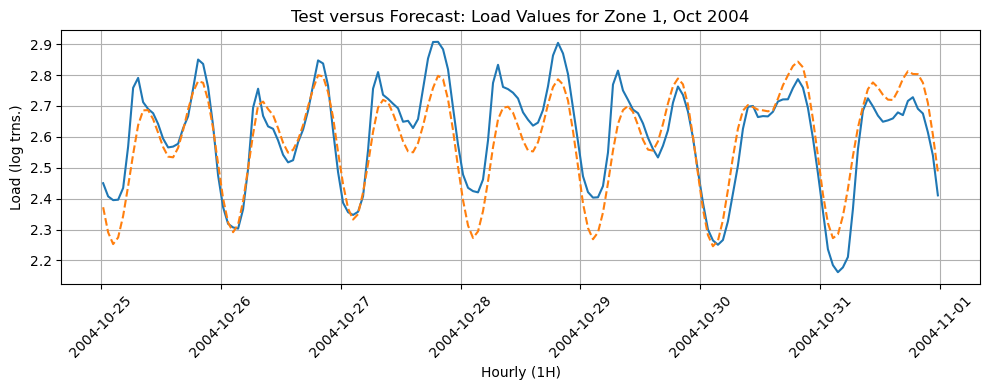

In [178]:
# Predicting 24*7 steps ahead
forecast_oct04 = SARIMA_model_fit.get_forecast(
    steps=24*7, 
    exog = load_long_z1_2004_oct_test[["HDK", "CDK", "holiday", "trend", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h')
).predicted_mean

# Fit on the test data
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=load_long_z1_2004_oct_test, x=load_long_z1_2004_oct_test.index, y=load_long_z1_2004_oct_test.log_load_rs.asfreq('h'), ax=ax)
sns.lineplot(forecast_oct04, linestyle = '--')
ax.set_title("Test versus Forecast: Load Values for Zone 1, Oct 2004")
ax.set_xlabel("Hourly (1H)")
ax.set_ylabel("Load (log trns.)")
ax.grid(True)
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

In [179]:
# Performance on test set

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print(f"R2 score: {r2_score(load_long_z1_2004_oct_test.log_load_rs, forecast_oct04)}")
print(f'MSE score: {mean_squared_error(load_long_z1_2004_oct_test.log_load_rs, forecast_oct04)}')
print(f'MAE score: {mean_absolute_error(load_long_z1_2004_oct_test.log_load_rs, forecast_oct04)}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_2004_oct_test.log_load_rs, forecast_oct04)}')

R2 score: 0.7574336035914353
MSE score: 0.006849482344319621
MAE score: 0.06732099463232112
MAPE score: 0.025941740654248813


##### Testing on Last Week of Dec 2004 (Zone 1)
Last week of Dec 2004 is used for testing. Multiple SARIMAX models are evaluated and compared. 

In [180]:
# Creating training data
load_long_z1_2004_dec_train = mul_df.loc[mul_df.month == 12,:]
load_long_z1_2004_dec_train = load_long_z1_2004_dec_train.set_index("timestamp")
load_long_z1_2004_dec_train = load_long_z1_2004_dec_train[:'2004-12-24 23:30:00']
load_long_z1_2004_dec_train.index = pd.to_datetime(load_long_z1_2004_dec_train.index)
load_long_z1_2004_dec_train.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-12-01 00:30:00  2004     12    1  00:30     2.650774      47.965991   
2004-12-01 01:30:00  2004     12    1  01:30     2.609481      48.609925   
2004-12-01 02:30:00  2004     12    1  02:30     2.608304      49.154281   
2004-12-01 03:30:00  2004     12    1  03:30     2.617177      50.252969   
2004-12-01 04:30:00  2004     12    1  04:30     2.646104      51.607521   

                     holiday       HDK  CDK  
timestamp                                    
2004-12-01 00:30:00        0  7.034009  0.0  
2004-12-01 01:30:00        0  6.390075  0.0  
2004-12-01 02:30:00        0  5.845719  0.0  
2004-12-01 03:30:00        0  4.747031  0.0  
2004-12-01 04:30:00        0  3.392479  0.0

In [181]:
# Defining the sine wave
dp = DeterministicProcess(
    index=load_long_z1_2004_dec_train.index,
    period=None,         # It's not defined so that frequency can be read from the index
    constant=False,      # Let regression model define this intercept later on
    order=1,             
    seasonal=False,      # no seasonal dummies
    additional_terms=[periodicity], # 2 seperate waves will be generated
    drop=True            # if perfect collinearity exists, the terms can be dropped
)

waves = dp.in_sample()

# Combining fourier terms with other variables
load_long_z1_2004_dec_train = load_long_z1_2004_dec_train.merge(waves, on='timestamp', how='left')
load_long_z1_2004_dec_train.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-12-01 00:30:00  2004     12    1  00:30     2.650774      47.965991   
2004-12-01 01:30:00  2004     12    1  01:30     2.609481      48.609925   
2004-12-01 02:30:00  2004     12    1  02:30     2.608304      49.154281   
2004-12-01 03:30:00  2004     12    1  03:30     2.617177      50.252969   
2004-12-01 04:30:00  2004     12    1  04:30     2.646104      51.607521   

                     holiday       HDK  CDK  trend  sin(1,24)  cos(1,24)  \
timestamp                                                                  
2004-12-01 00:30:00        0  7.034009  0.0    1.0   0.000000   1.000000   
2004-12-01 01:30:00        0  6.390075  0.0    2.0   0.258819   0.965926   
2004-12-01 02:30:00        0  5.845719  0.0    3.0   0.500000   0.866025   
2004-12-01 03:30:00        0  4.747031  0.0    4.0   0.707107   0.707107   
2004-12-01 04:30:00        0  3.392479  0.0    5.0   0.866025   0.500000   

                     sin(2,24)     cos(2,24)  
timestamp                                     
2004-12-01 00:30:00   0.000000  1.000000e+00  
2004-12-01 01:30:00   0.500000  8.660254e-01  
2004-12-01 02:30:00   0.866025  5.000000e-01  
2004-12-01 03:30:00   1.000000  6.123234e-17  
2004-12-01 04:30:00   0.866025 -5.000000e-01

In [182]:
# Comparing models - auto_arima (no differencing)

smodel_jul = pm.auto_arima(y = load_long_z1_2004_dec_train["log_load_rs"].asfreq('h'), 
                           X = load_long_z1_2004_dec_train[["HDK", "CDK", "holiday", "trend", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h'),
                           start_p=0, start_q=0,test='adf',
                           max_p=3, max_q=3, m=24,
                           start_P=0, start_Q=0, max_P=0, max_Q=0, seasonal=True,
                           d=0, D=0, trace=True,
                           trend="c",
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=266.509, Time=0.93 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=-2097.397, Time=0.67 sec
 ARIMA(0,0,1)(0,0,0)[24] intercept   : AIC=inf, Time=1.06 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=266.509, Time=0.98 sec
 ARIMA(2,0,0)(0,0,0)[24] intercept   : AIC=-1986.037, Time=0.91 sec
 ARIMA(1,0,1)(0,0,0)[24] intercept   : AIC=-2206.860, Time=0.94 sec
 ARIMA(2,0,1)(0,0,0)[24] intercept   : AIC=-681.713, Time=0.96 sec
 ARIMA(1,0,2)(0,0,0)[24] intercept   : AIC=-1934.533, Time=0.91 sec
 ARIMA(0,0,2)(0,0,0)[24] intercept   : AIC=-538.454, Time=1.11 sec
 ARIMA(2,0,2)(0,0,0)[24] intercept   : AIC=-1840.786, Time=1.11 sec
 ARIMA(1,0,1)(0,0,0)[24]             : AIC=-2206.860, Time=0.87 sec

Best model:  ARIMA(1,0,1)(0,0,0)[24]          
Total fit time: 10.462 seconds


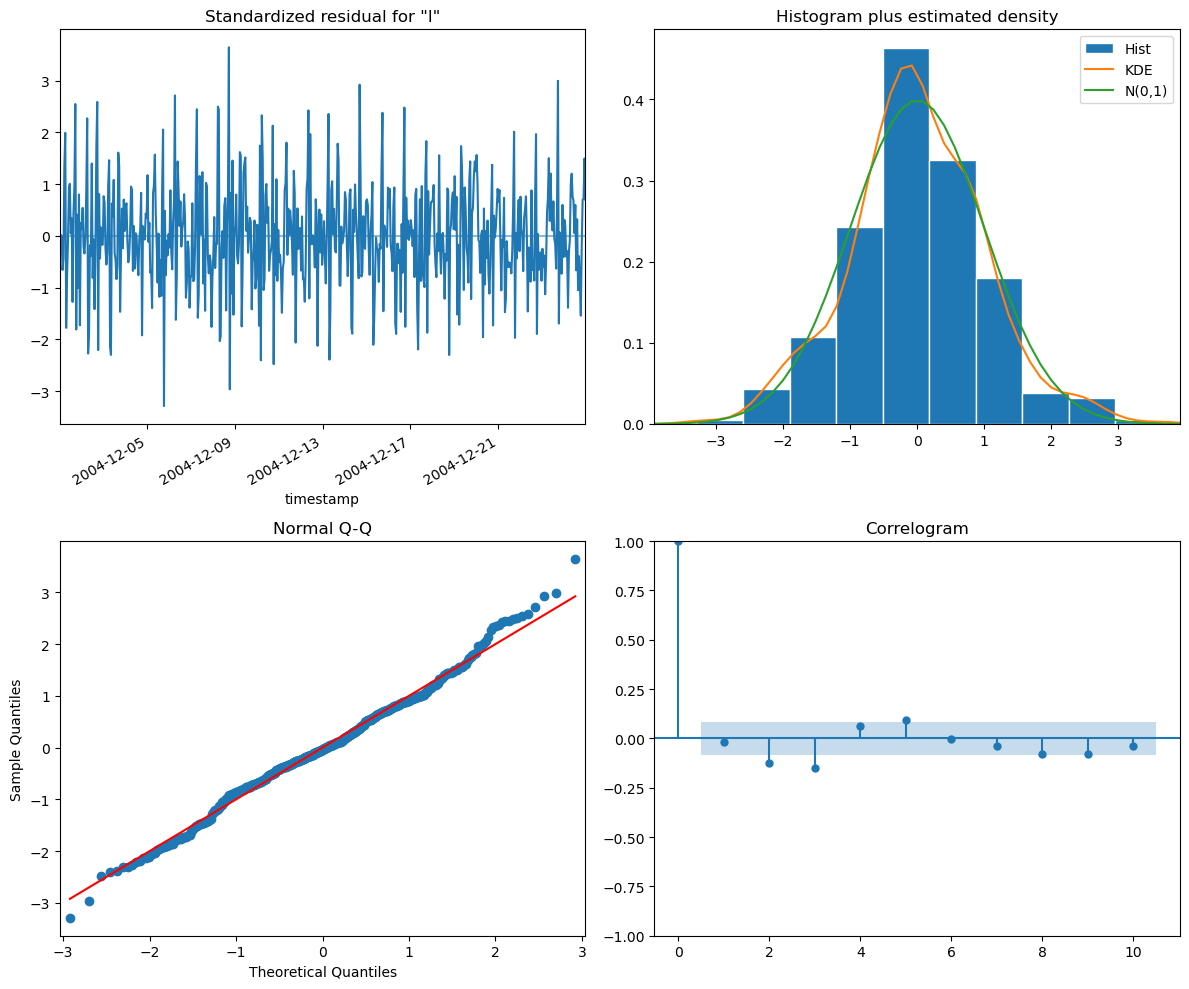

In [183]:
# Diagnostics (for (1,1,0,0))

SARIMA_model = sm.tsa.statespace.SARIMAX(
        endog = load_long_z1_2004_dec_train["log_load_rs"].asfreq('h'), 
        exog = load_long_z1_2004_dec_train[["HDK", "CDK", "holiday", "trend", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h'), 
        order=(1,0,1),  # non-seasonal: with no differencing
        seasonal_order=(0,0,0,24), # seasonal: with no seasonal differencing
        trend="c")

SARIMA_model_fit = SARIMA_model.fit(disp=False, maxiter=500)
SARIMA_model_fit.plot_diagnostics(figsize=(12,10))
plt.tight_layout()
plt.show()

In [184]:
# Creating test data
load_long_z1_2004_dec_test = mul_df.loc[mul_df.month == 12,:]
load_long_z1_2004_dec_test = load_long_z1_2004_dec_test.set_index("timestamp")
load_long_z1_2004_dec_test = load_long_z1_2004_dec_test['2004-12-25 00:30:00':]
load_long_z1_2004_dec_test.index = pd.to_datetime(load_long_z1_2004_dec_test.index)
load_long_z1_2004_dec_test.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-12-25 00:30:00  2004     12   25  00:30     3.270443      25.586955   
2004-12-25 01:30:00  2004     12   25  01:30     3.272530      24.675567   
2004-12-25 02:30:00  2004     12   25  02:30     3.290191      24.681275   
2004-12-25 03:30:00  2004     12   25  03:30     3.314804      24.588997   
2004-12-25 04:30:00  2004     12   25  04:30     3.350676      24.320518   

                     holiday        HDK  CDK  
timestamp                                     
2004-12-25 00:30:00        0  29.413045  0.0  
2004-12-25 01:30:00        0  30.324433  0.0  
2004-12-25 02:30:00        0  30.318725  0.0  
2004-12-25 03:30:00        0  30.411003  0.0  
2004-12-25 04:30:00        0  30.679482  0.0

In [185]:
# Defining the sine wave
dp = DeterministicProcess(
    index=load_long_z1_2004_dec_test.index,
    period=None,         # It's not defined so that frequency can be read from the index
    constant=False,      # Let regression model define this intercept later on
    order=1,              
    seasonal=False,      # no seasonal dummies
    additional_terms=[periodicity], # 2 seperate waves will be generated
    drop=True            # if perfect collinearity exists, the terms can be dropped
)

waves = dp.in_sample()

# Combining fourier terms with other variables - test set
load_long_z1_2004_dec_test = load_long_z1_2004_dec_test.merge(waves, on='timestamp', how='left')
load_long_z1_2004_dec_test.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-12-25 00:30:00  2004     12   25  00:30     3.270443      25.586955   
2004-12-25 01:30:00  2004     12   25  01:30     3.272530      24.675567   
2004-12-25 02:30:00  2004     12   25  02:30     3.290191      24.681275   
2004-12-25 03:30:00  2004     12   25  03:30     3.314804      24.588997   
2004-12-25 04:30:00  2004     12   25  04:30     3.350676      24.320518   

                     holiday        HDK  CDK  trend  sin(1,24)  cos(1,24)  \
timestamp                                                                   
2004-12-25 00:30:00        0  29.413045  0.0    1.0   0.000000   1.000000   
2004-12-25 01:30:00        0  30.324433  0.0    2.0   0.258819   0.965926   
2004-12-25 02:30:00        0  30.318725  0.0    3.0   0.500000   0.866025   
2004-12-25 03:30:00        0  30.411003  0.0    4.0   0.707107   0.707107   
2004-12-25 04:30:00        0  30.679482  0.0    5.0   0.866025   0.500000   

                     sin(2,24)     cos(2,24)  
timestamp                                     
2004-12-25 00:30:00   0.000000  1.000000e+00  
2004-12-25 01:30:00   0.500000  8.660254e-01  
2004-12-25 02:30:00   0.866025  5.000000e-01  
2004-12-25 03:30:00   1.000000  6.123234e-17  
2004-12-25 04:30:00   0.866025 -5.000000e-01

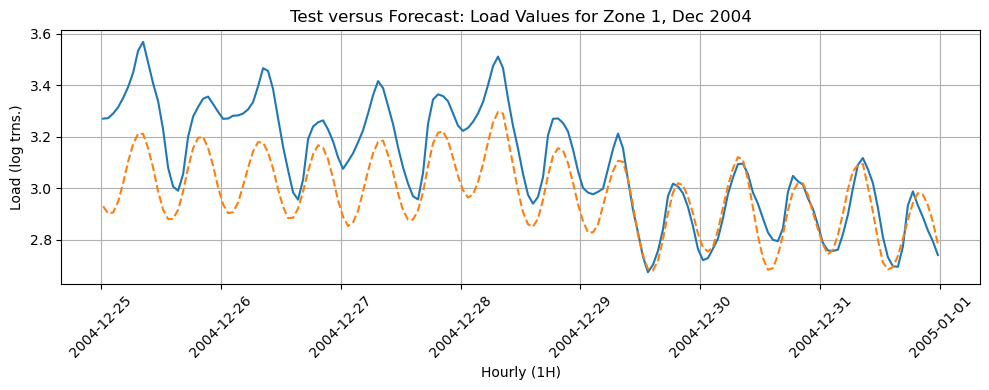

In [186]:
# Predicting 24*7 steps ahead
forecast_dec04 = SARIMA_model_fit.get_forecast(
    steps=24*7, 
    exog = load_long_z1_2004_dec_test[["HDK", "CDK", "holiday", "trend", "sin(1,24)", "cos(1,24)", "sin(2,24)", "cos(2,24)"]].asfreq('h')
).predicted_mean

# Fit on the test data
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=load_long_z1_2004_dec_test, x=load_long_z1_2004_dec_test.index, y=load_long_z1_2004_dec_test.log_load_rs.asfreq('h'), ax=ax)
sns.lineplot(forecast_dec04, linestyle = '--')
ax.set_title("Test versus Forecast: Load Values for Zone 1, Dec 2004")
ax.set_xlabel("Hourly (1H)")
ax.set_ylabel("Load (log trns.)")
ax.grid(True)
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

In [187]:
# Performance on test set

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print(f"R2 score: {r2_score(load_long_z1_2004_dec_test.log_load_rs, forecast_dec04)}")
print(f'MSE score: {mean_squared_error(load_long_z1_2004_dec_test.log_load_rs, forecast_dec04)}')
print(f'MAE score: {mean_absolute_error(load_long_z1_2004_dec_test.log_load_rs, forecast_dec04)}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_2004_dec_test.log_load_rs, forecast_dec04)}')

R2 score: 0.3664935903866733
MSE score: 0.029726402146651454
MAE score: 0.13806667229541028
MAPE score: 0.04298769304264708


## Removing Fourier Terms with SARIMAX
- The model removes fourier terms, as used in time series regression. This is then combined with SARIMAX, where seasonal AR\MA components are also defined.
- Since seasonality is likely uncaptured, seasonal differencing is done.
- A <i>trend</i> term (not associated with slope) is also added, since SARIMAX doesn't define an <b>intercept</b> by default.

##### Testing on Last Week of Jan 2004 (Zone 1)
Last week of Jan 2004 is used for testing. Multiple SARIMAX models are evaluated and compared. 

In [188]:
# Creating training data
load_long_z1_2004_jan_train = mul_df.loc[mul_df.month == 1,:]
load_long_z1_2004_jan_train = load_long_z1_2004_jan_train.set_index("timestamp")
load_long_z1_2004_jan_train = load_long_z1_2004_jan_train[:'2004-01-24 23:30:00']
load_long_z1_2004_jan_train.index = pd.to_datetime(load_long_z1_2004_jan_train.index)
load_long_z1_2004_jan_train.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-01-01 00:30:00  2004      1    1  00:30     2.824529      42.338937   
2004-01-01 01:30:00  2004      1    1  01:30     2.800325      41.239284   
2004-01-01 02:30:00  2004      1    1  02:30     2.804390      39.591442   
2004-01-01 03:30:00  2004      1    1  03:30     2.825715      36.243296   
2004-01-01 04:30:00  2004      1    1  04:30     2.836971      34.600850   

                     holiday        HDK  CDK  
timestamp                                     
2004-01-01 00:30:00        1  12.661063  0.0  
2004-01-01 01:30:00        1  13.760716  0.0  
2004-01-01 02:30:00        1  15.408558  0.0  
2004-01-01 03:30:00        1  18.756704  0.0  
2004-01-01 04:30:00        1  20.399150  0.0

In [203]:
# Comparing models - auto_arima

import pmdarima as pm
smodel_jan = pm.auto_arima(y = load_long_z1_2004_jan_train["log_load_rs"].asfreq('h'), 
                           X = load_long_z1_2004_jan_train[["HDK", "CDK", "holiday"]].asfreq('h'),
                           start_p=0, start_q=0,test='adf',
                           max_p=3, max_q=3, m=24,
                           start_P=0, start_Q=0, max_P=2, max_Q=2, seasonal=True,
                           d=0, D=1, trace=True,
                           error_action='ignore',
                           trend="c",
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[24] intercept   : AIC=-906.791, Time=0.88 sec
 ARIMA(1,0,0)(1,1,0)[24] intercept   : AIC=-1867.026, Time=8.51 sec
 ARIMA(0,0,1)(0,1,1)[24] intercept   : AIC=inf, Time=9.08 sec
 ARIMA(0,0,0)(0,1,0)[24]             : AIC=-906.791, Time=0.84 sec
 ARIMA(1,0,0)(0,1,0)[24] intercept   : AIC=-1801.256, Time=2.85 sec
 ARIMA(1,0,0)(2,1,0)[24] intercept   : AIC=-1916.808, Time=19.93 sec
 ARIMA(1,0,0)(2,1,1)[24] intercept   : AIC=inf, Time=22.65 sec
 ARIMA(1,0,0)(1,1,1)[24] intercept   : AIC=inf, Time=10.68 sec
 ARIMA(0,0,0)(2,1,0)[24] intercept   : AIC=-973.349, Time=16.18 sec
 ARIMA(2,0,0)(2,1,0)[24] intercept   : AIC=-1977.783, Time=20.62 sec
 ARIMA(2,0,0)(1,1,0)[24] intercept   : AIC=-1932.994, Time=9.60 sec
 ARIMA(2,0,0)(2,1,1)[24] intercept   : AIC=inf, Time=24.01 sec
 ARIMA(2,0,0)(1,1,1)[24] intercept   : AIC=-2000.761, Time=11.21 sec
 ARIMA(2,0,0)(0,1,1)[24] intercept   : AIC=inf, Time=11.40 sec
 ARIMA(2,0,0)(1,1,2)[24] inter

The order of the seasonal and non-seasonal AR/MA components has now changed, compared to the case of using SARIMAX without external regressors.

In [1]:
# Diagnostics (for (2,0,1,1))

import statsmodels.api as sm
SARIMA_model = sm.tsa.statespace.SARIMAX(
        endog = load_long_z1_2004_jan_train["log_load_rs"].asfreq('h'), 
        exog = load_long_z1_2004_jan_train[["HDK", "CDK", "holiday"]].asfreq('h'), 
        order=(2,0,0),  # non-seasonal: with no differencing
        seasonal_order=(1,1,1,24), # seasonal: with seasonal differencing
        trend = "c")

SARIMA_model_fit = SARIMA_model.fit(disp=False, maxiter=500)
SARIMA_model_fit.plot_diagnostics(figsize=(12,10))
plt.tight_layout()
plt.show()

NameError: name 'load_long_z1_2004_jan_train' is not defined

Residual plot appears to have slightly improved, but deviation is still heavy at tails.
> Distribution more similar to Gaussian dist.

In [205]:
# Creating test data
load_long_z1_2004_jan_test = mul_df.loc[mul_df.month == 1,:]
load_long_z1_2004_jan_test = load_long_z1_2004_jan_test.set_index("timestamp")
load_long_z1_2004_jan_test = load_long_z1_2004_jan_test['2004-01-25 00:30:00':]
load_long_z1_2004_jan_test.index = pd.to_datetime(load_long_z1_2004_jan_test.index)
load_long_z1_2004_jan_test.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-01-25 00:30:00  2004      1   25  00:30     3.094174      21.155292   
2004-01-25 01:30:00  2004      1   25  01:30     3.101713      20.058817   
2004-01-25 02:30:00  2004      1   25  02:30     3.144626      19.051006   
2004-01-25 03:30:00  2004      1   25  03:30     3.160441      18.246300   
2004-01-25 04:30:00  2004      1   25  04:30     3.197407      17.700175   

                     holiday        HDK  CDK  
timestamp                                     
2004-01-25 00:30:00        0  33.844708  0.0  
2004-01-25 01:30:00        0  34.941183  0.0  
2004-01-25 02:30:00        0  35.948994  0.0  
2004-01-25 03:30:00        0  36.753700  0.0  
2004-01-25 04:30:00        0  37.299825  0.0

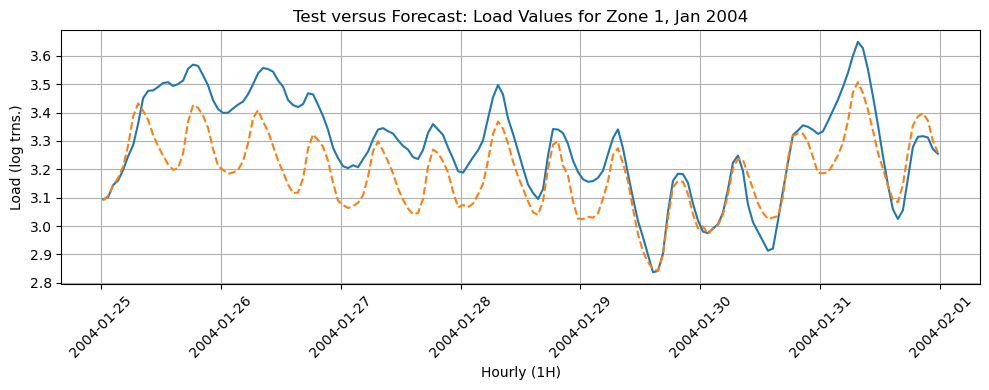

In [206]:
# Predicting 24*7 steps ahead
forecast_jan04 = SARIMA_model_fit.get_forecast(
    steps=24*7, 
    exog = load_long_z1_2004_jan_test[["HDK", "CDK", "holiday"]].asfreq('h')
).predicted_mean

# Fit on the test data
import seaborn as sns
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=load_long_z1_2004_jan_test, x=load_long_z1_2004_jan_test.index, y=load_long_z1_2004_jan_test["log_load_rs"].asfreq('h'), ax=ax)
sns.lineplot(forecast_jan04, linestyle = '--')
ax.set_title("Test versus Forecast: Load Values for Zone 1, Jan 2004")
ax.set_xlabel("Hourly (1H)")
ax.set_ylabel("Load (log trns.)")
ax.grid(True)
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

In [207]:
# Performance on test set

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print(f"R2 score: {r2_score(load_long_z1_2004_jan_test.log_load_rs, forecast_jan04)}")
print(f'MSE score: {mean_squared_error(load_long_z1_2004_jan_test.log_load_rs, forecast_jan04)}')
print(f'MAE score: {mean_absolute_error(load_long_z1_2004_jan_test.log_load_rs, forecast_jan04)}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_2004_jan_test.log_load_rs, forecast_jan04)}')

R2 score: 0.4017677652354632
MSE score: 0.018270933271995894
MAE score: 0.11104385600284825
MAPE score: 0.03314105151439312


Performance improvement is significant and much better that ES.

##### Testing on Last Week of Apr 2004 (Zone 1)
Last week of Apr 2004 is used for testing. Multiple SARIMAX models are evaluated and compared. 

In [194]:
# Creating training data
load_long_z1_2004_apr_train = mul_df.loc[mul_df.month == 4,:]
load_long_z1_2004_apr_train = load_long_z1_2004_apr_train.set_index("timestamp")
load_long_z1_2004_apr_train = load_long_z1_2004_apr_train[:'2004-04-23 23:30:00']
load_long_z1_2004_apr_train.index = pd.to_datetime(load_long_z1_2004_apr_train.index)
load_long_z1_2004_apr_train.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-04-01 00:30:00  2004      4    1  00:30     2.645820      45.453562   
2004-04-01 01:30:00  2004      4    1  01:30     2.633901      45.547368   
2004-04-01 02:30:00  2004      4    1  02:30     2.633039      45.454863   
2004-04-01 03:30:00  2004      4    1  03:30     2.646246      45.454863   
2004-04-01 04:30:00  2004      4    1  04:30     2.688528      45.191047   

                     holiday       HDK  CDK  
timestamp                                    
2004-04-01 00:30:00        0  9.546438  0.0  
2004-04-01 01:30:00        0  9.452632  0.0  
2004-04-01 02:30:00        0  9.545137  0.0  
2004-04-01 03:30:00        0  9.545137  0.0  
2004-04-01 04:30:00        0  9.808953  0.0

In [208]:
# Comparing models - auto_arima

smodel_apr = pm.auto_arima(y = load_long_z1_2004_apr_train["log_load_rs"].asfreq('h'), 
                           X = load_long_z1_2004_apr_train[["HDK", "CDK", "holiday"]].asfreq('h'),
                           start_p=0, start_q=0,test='adf',
                           max_p=3, max_q=3, m=24,
                           start_P=0, start_Q=0, max_P=2, max_Q=2, seasonal=True,
                           d=0, D=1, trace=True,
                           error_action='trace',
                           trend="c",
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[24] intercept   : AIC=-835.371, Time=1.16 sec
 ARIMA(1,0,0)(1,1,0)[24] intercept   : AIC=-1893.224, Time=3.29 sec
 ARIMA(0,0,1)(0,1,1)[24] intercept   : AIC=-1444.188, Time=13.41 sec
 ARIMA(0,0,0)(0,1,0)[24]             : AIC=-835.371, Time=1.14 sec
 ARIMA(1,0,0)(0,1,0)[24] intercept   : AIC=-1881.792, Time=1.30 sec
 ARIMA(1,0,0)(2,1,0)[24] intercept   : AIC=-1909.787, Time=18.49 sec
 ARIMA(1,0,0)(2,1,1)[24] intercept   : AIC=inf, Time=21.96 sec
 ARIMA(1,0,0)(1,1,1)[24] intercept   : AIC=inf, Time=8.85 sec
 ARIMA(0,0,0)(2,1,0)[24] intercept   : AIC=-854.481, Time=8.54 sec
 ARIMA(2,0,0)(2,1,0)[24] intercept   : AIC=-2046.864, Time=24.81 sec
 ARIMA(2,0,0)(1,1,0)[24] intercept   : AIC=-2023.188, Time=11.59 sec
 ARIMA(2,0,0)(2,1,1)[24] intercept   : AIC=-2096.269, Time=24.27 sec
 ARIMA(2,0,0)(1,1,1)[24] intercept   : AIC=inf, Time=11.28 sec
 ARIMA(2,0,0)(2,1,2)[24] intercept   : AIC=inf, Time=27.49 sec
 ARIMA(2,0,0)(1,1,2)[24]

The best order for AR/MA components (seasonal and non-seasonal) has again changed, compared to SARIMAX without external regressors.

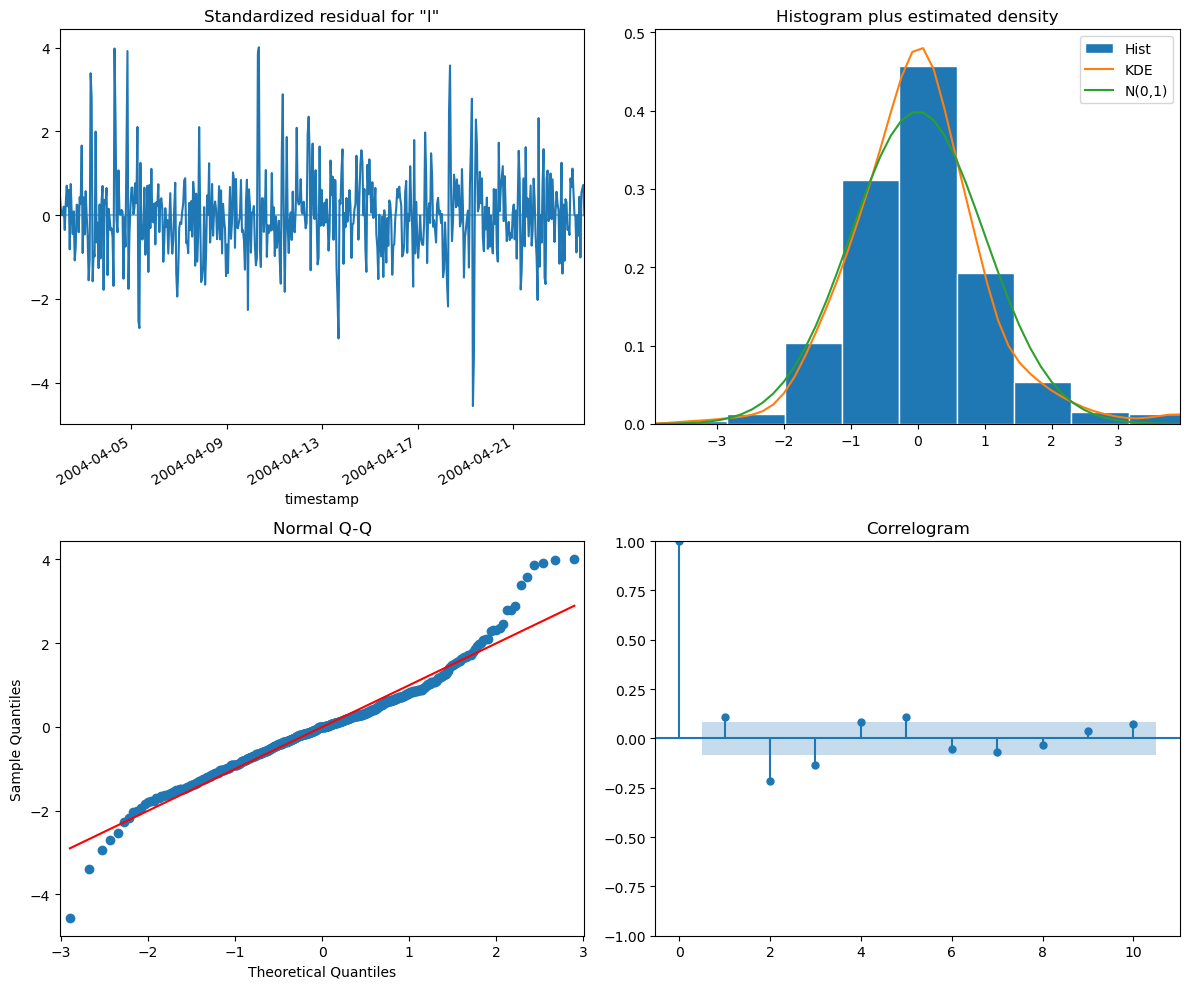

In [210]:
# Diagnostics (for (2,0,2,1))

import statsmodels.api as sm
SARIMA_model = sm.tsa.statespace.SARIMAX(
        endog = load_long_z1_2004_apr_train["log_load_rs"].asfreq('h'), 
        exog = load_long_z1_2004_apr_train[["HDK", "CDK", "holiday"]].asfreq('h'), 
        order=(2,0,0),  # non-seasonal: with no differencing
        seasonal_order=(2,1,1,24), # seasonal: with seasonal differencing
        trend="c")

SARIMA_model_fit = SARIMA_model.fit(disp=False, maxiter=500)
SARIMA_model_fit.plot_diagnostics(figsize=(12,10))
plt.tight_layout()
plt.show()

In [200]:
# Creating test data
load_long_z1_2004_apr_test = mul_df.loc[mul_df.month == 4,:]
load_long_z1_2004_apr_test = load_long_z1_2004_apr_test.set_index("timestamp")
load_long_z1_2004_apr_test = load_long_z1_2004_apr_test['2004-04-24 00:30:00':]
load_long_z1_2004_apr_test.index = pd.to_datetime(load_long_z1_2004_apr_test.index)
load_long_z1_2004_apr_test.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-04-24 00:30:00  2004      4   24  00:30     2.437728      62.266565   
2004-04-24 01:30:00  2004      4   24  01:30     2.328643      62.708075   
2004-04-24 02:30:00  2004      4   24  02:30     2.279316      61.449205   
2004-04-24 03:30:00  2004      4   24  03:30     2.249290      60.634717   
2004-04-24 04:30:00  2004      4   24  04:30     2.248657      59.824237   

                     holiday  HDK  CDK  
timestamp                               
2004-04-24 00:30:00        0  0.0  0.0  
2004-04-24 01:30:00        0  0.0  0.0  
2004-04-24 02:30:00        0  0.0  0.0  
2004-04-24 03:30:00        0  0.0  0.0  
2004-04-24 04:30:00        0  0.0  0.0

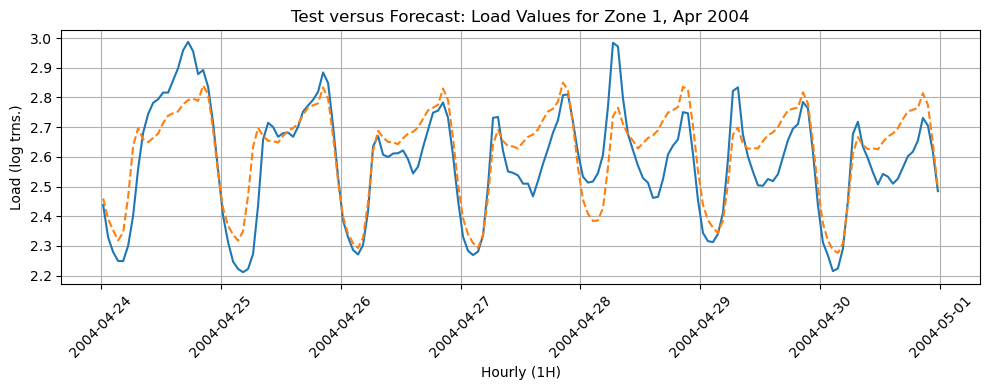

In [211]:
# Predicting 24*7 steps ahead
forecast_apr04 = SARIMA_model_fit.get_forecast(
    steps=24*7, 
    exog = load_long_z1_2004_apr_test[["HDK", "CDK", "holiday"]].asfreq('h')
).predicted_mean

# Fit on the test data
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=load_long_z1_2004_apr_test, x=load_long_z1_2004_apr_test.index, y=load_long_z1_2004_apr_test.log_load_rs.asfreq('h'), ax=ax)
sns.lineplot(forecast_apr04, linestyle = '--')
ax.set_title("Test versus Forecast: Load Values for Zone 1, Apr 2004")
ax.set_xlabel("Hourly (1H)")
ax.set_ylabel("Load (log trns.)")
ax.grid(True)
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

In [212]:
# Performance on test set

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print(f"R2 score: {r2_score(load_long_z1_2004_apr_test.log_load_rs, forecast_apr04)}")
print(f'MSE score: {mean_squared_error(load_long_z1_2004_apr_test.log_load_rs, forecast_apr04)}')
print(f'MAE score: {mean_absolute_error(load_long_z1_2004_apr_test.log_load_rs, forecast_apr04)}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_2004_apr_test.log_load_rs, forecast_apr04)}')

R2 score: 0.6721767129723315
MSE score: 0.011213551084837877
MAE score: 0.08420004134804004
MAPE score: 0.03281793461721744


##### Testing on Last Week of Jul 2004 (Zone 1)
Last week of Jul 2004 is used for testing. Multiple SARIMAX models are evaluated and compared. 

In [213]:
# Creating training data
load_long_z1_2004_jul_train = mul_df.loc[mul_df.month == 7,:]
load_long_z1_2004_jul_train = load_long_z1_2004_jul_train.set_index("timestamp")
load_long_z1_2004_jul_train = load_long_z1_2004_jul_train[:'2004-07-24 23:30:00']
load_long_z1_2004_jul_train.index = pd.to_datetime(load_long_z1_2004_jul_train.index)
load_long_z1_2004_jul_train.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-07-01 00:30:00  2004      7    1  00:30     2.658230      67.152732   
2004-07-01 01:30:00  2004      7    1  01:30     2.548507      66.148285   
2004-07-01 02:30:00  2004      7    1  02:30     2.482404      65.687669   
2004-07-01 03:30:00  2004      7    1  03:30     2.447464      64.515455   
2004-07-01 04:30:00  2004      7    1  04:30     2.430626      64.517938   

                     holiday  HDK       CDK  
timestamp                                    
2004-07-01 00:30:00        0  0.0  2.152732  
2004-07-01 01:30:00        0  0.0  1.148285  
2004-07-01 02:30:00        0  0.0  0.687669  
2004-07-01 03:30:00        0  0.0  0.000000  
2004-07-01 04:30:00        0  0.0  0.000000

In [214]:
# Comparing models - auto_arima

smodel_jul = pm.auto_arima(y = load_long_z1_2004_jul_train["log_load_rs"].asfreq('h'), 
                           X = load_long_z1_2004_jul_train[["HDK", "CDK", "holiday"]].asfreq('h'),
                           start_p=0, start_q=0,test='adf',
                           max_p=3, max_q=3, m=24,
                           start_P=0, start_Q=0, max_P=2, max_Q=2, seasonal=True,
                           d=0, D=1, trace=True,
                           trend="c",
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[24] intercept   : AIC=-965.339, Time=0.39 sec
 ARIMA(1,0,0)(1,1,0)[24] intercept   : AIC=-2271.740, Time=4.41 sec
 ARIMA(0,0,1)(0,1,1)[24] intercept   : AIC=inf, Time=9.19 sec
 ARIMA(0,0,0)(0,1,0)[24]             : AIC=-965.339, Time=0.37 sec
 ARIMA(1,0,0)(0,1,0)[24] intercept   : AIC=-2221.499, Time=1.85 sec
 ARIMA(1,0,0)(2,1,0)[24] intercept   : AIC=-2290.841, Time=21.84 sec
 ARIMA(1,0,0)(2,1,1)[24] intercept   : AIC=inf, Time=22.34 sec
 ARIMA(1,0,0)(1,1,1)[24] intercept   : AIC=inf, Time=8.96 sec
 ARIMA(0,0,0)(2,1,0)[24] intercept   : AIC=-1057.966, Time=9.92 sec
 ARIMA(2,0,0)(2,1,0)[24] intercept   : AIC=-2466.618, Time=23.12 sec
 ARIMA(2,0,0)(1,1,0)[24] intercept   : AIC=-2448.748, Time=10.83 sec
 ARIMA(2,0,0)(2,1,1)[24] intercept   : AIC=inf, Time=24.47 sec
 ARIMA(2,0,0)(1,1,1)[24] intercept   : AIC=inf, Time=10.84 sec
 ARIMA(3,0,0)(2,1,0)[24] intercept   : AIC=-2493.087, Time=25.99 sec
 ARIMA(3,0,0)(1,1,0)[24] inter

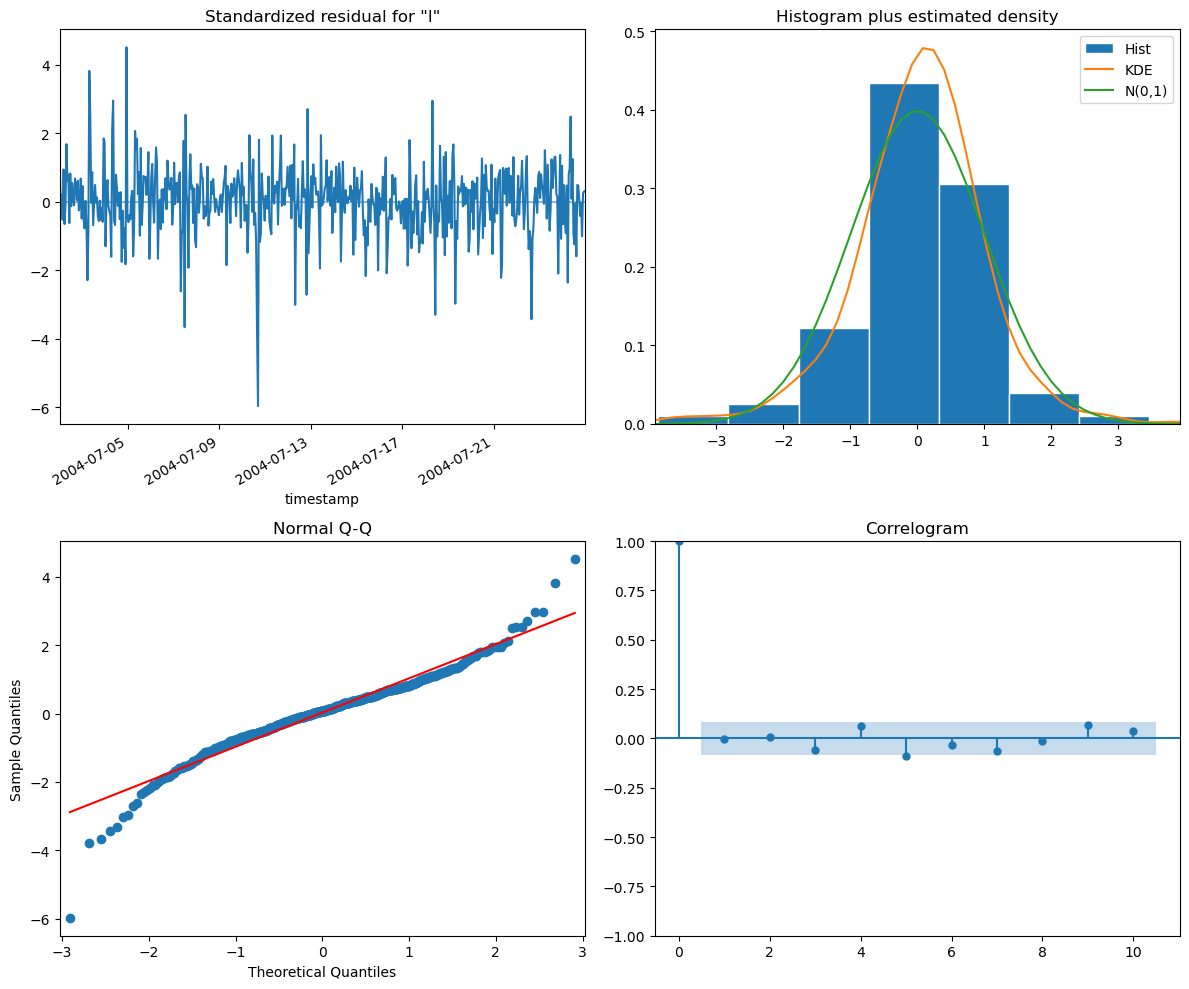

In [215]:
# Diagnostics (for (3,1,2,1))

SARIMA_model = sm.tsa.statespace.SARIMAX(
        endog = load_long_z1_2004_jul_train["log_load_rs"].asfreq('h'), 
        exog = load_long_z1_2004_jul_train[["HDK", "CDK", "holiday"]].asfreq('h'), 
        order=(3,0,1),  # non-seasonal: with no differencing
        seasonal_order=(2,1,1,24), # seasonal: with seasonal differencing
        trend="c")

SARIMA_model_fit = SARIMA_model.fit(disp=False, maxiter=500)
SARIMA_model_fit.plot_diagnostics(figsize=(12,10))
plt.tight_layout()
plt.show()

In [216]:
# Creating test data
load_long_z1_2004_jul_test = mul_df.loc[mul_df.month == 7,:]
load_long_z1_2004_jul_test = load_long_z1_2004_jul_test.set_index("timestamp")
load_long_z1_2004_jul_test = load_long_z1_2004_jul_test['2004-07-25 00:30:00':]
load_long_z1_2004_jul_test.index = pd.to_datetime(load_long_z1_2004_jul_test.index)
load_long_z1_2004_jul_test.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-07-25 00:30:00  2004      7   25  00:30     2.669517      70.616043   
2004-07-25 01:30:00  2004      7   25  01:30     2.551552      70.893317   
2004-07-25 02:30:00  2004      7   25  02:30     2.486073      70.710504   
2004-07-25 03:30:00  2004      7   25  03:30     2.441738      70.526899   
2004-07-25 04:30:00  2004      7   25  04:30     2.429834      70.527349   

                     holiday  HDK       CDK  
timestamp                                    
2004-07-25 00:30:00        0  0.0  5.616043  
2004-07-25 01:30:00        0  0.0  5.893317  
2004-07-25 02:30:00        0  0.0  5.710504  
2004-07-25 03:30:00        0  0.0  5.526899  
2004-07-25 04:30:00        0  0.0  5.527349

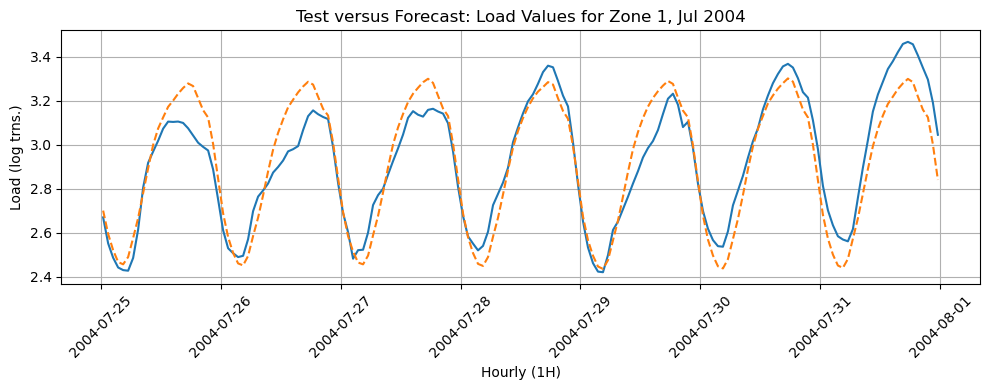

In [217]:
# Predicting 24*7 steps ahead
forecast_jul04 = SARIMA_model_fit.get_forecast(
    steps=24*7, 
    exog = load_long_z1_2004_jul_test[["HDK", "CDK", "holiday"]].asfreq('h')
).predicted_mean

# Fit on the test data
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=load_long_z1_2004_jul_test, x=load_long_z1_2004_jul_test.index, y=load_long_z1_2004_jul_test.log_load_rs.asfreq('h'), ax=ax)
sns.lineplot(forecast_jul04, linestyle = '--')
ax.set_title("Test versus Forecast: Load Values for Zone 1, Jul 2004")
ax.set_xlabel("Hourly (1H)")
ax.set_ylabel("Load (log trns.)")
ax.grid(True)
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

In [218]:
# Performance on test set

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print(f"R2 score: {r2_score(load_long_z1_2004_jul_test.log_load_rs, forecast_jul04)}")
print(f'MSE score: {mean_squared_error(load_long_z1_2004_jul_test.log_load_rs, forecast_jul04)}')
print(f'MAE score: {mean_absolute_error(load_long_z1_2004_jul_test.log_load_rs, forecast_jul04)}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_2004_jul_test.log_load_rs, forecast_jul04)}')

R2 score: 0.8585476248959829
MSE score: 0.011171305724585587
MAE score: 0.08713010289425913
MAPE score: 0.029442361011212143


##### Testing on Last Week of Oct 2004 (Zone 1)
Last week of Oct 2004 is used for testing. Multiple SARIMAX models are evaluated and compared. 

In [219]:
# Creating training data
load_long_z1_2004_oct_train = mul_df.loc[mul_df.month == 10,:]
load_long_z1_2004_oct_train = load_long_z1_2004_oct_train.set_index("timestamp")
load_long_z1_2004_oct_train = load_long_z1_2004_oct_train[:'2004-10-24 23:30:00']
load_long_z1_2004_oct_train.index = pd.to_datetime(load_long_z1_2004_oct_train.index)
load_long_z1_2004_oct_train.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-10-01 00:30:00  2004     10    1  00:30     2.410093      60.792180   
2004-10-01 01:30:00  2004     10    1  01:30     2.324444      60.513850   
2004-10-01 02:30:00  2004     10    1  02:30     2.293544      60.152501   
2004-10-01 03:30:00  2004     10    1  03:30     2.289399      59.693854   
2004-10-01 04:30:00  2004     10    1  04:30     2.303684      59.417333   

                     holiday  HDK  CDK  
timestamp                               
2004-10-01 00:30:00        0  0.0  0.0  
2004-10-01 01:30:00        0  0.0  0.0  
2004-10-01 02:30:00        0  0.0  0.0  
2004-10-01 03:30:00        0  0.0  0.0  
2004-10-01 04:30:00        0  0.0  0.0

In [220]:
# Comparing models - auto_arima

smodel_oct = pm.auto_arima(y = load_long_z1_2004_oct_train["log_load_rs"].asfreq('h'), 
                           X = load_long_z1_2004_oct_train[["HDK", "CDK", "holiday"]].asfreq('h'),
                           start_p=0, start_q=0,test='adf',
                           max_p=3, max_q=3, m=24,
                           start_P=0, start_Q=0, max_P=2, max_Q=2, seasonal=True,
                           d=0, D=1, trace=True,
                           trend="c",
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[24] intercept   : AIC=-1268.760, Time=0.69 sec
 ARIMA(1,0,0)(1,1,0)[24] intercept   : AIC=-2038.302, Time=4.48 sec
 ARIMA(0,0,1)(0,1,1)[24] intercept   : AIC=-1914.135, Time=9.05 sec
 ARIMA(0,0,0)(0,1,0)[24]             : AIC=-1268.760, Time=0.65 sec
 ARIMA(1,0,0)(0,1,0)[24] intercept   : AIC=-2032.130, Time=1.69 sec
 ARIMA(1,0,0)(2,1,0)[24] intercept   : AIC=-2107.178, Time=20.59 sec
 ARIMA(1,0,0)(2,1,1)[24] intercept   : AIC=inf, Time=21.68 sec
 ARIMA(1,0,0)(1,1,1)[24] intercept   : AIC=inf, Time=9.00 sec
 ARIMA(0,0,0)(2,1,0)[24] intercept   : AIC=-1343.403, Time=10.78 sec
 ARIMA(2,0,0)(2,1,0)[24] intercept   : AIC=-2254.341, Time=24.80 sec
 ARIMA(2,0,0)(1,1,0)[24] intercept   : AIC=-2201.116, Time=5.75 sec
 ARIMA(2,0,0)(2,1,1)[24] intercept   : AIC=inf, Time=26.59 sec
 ARIMA(2,0,0)(1,1,1)[24] intercept   : AIC=inf, Time=11.31 sec
 ARIMA(3,0,0)(2,1,0)[24] intercept   : AIC=-2290.770, Time=24.71 sec
 ARIMA(3,0,0)(1,1,0)[2

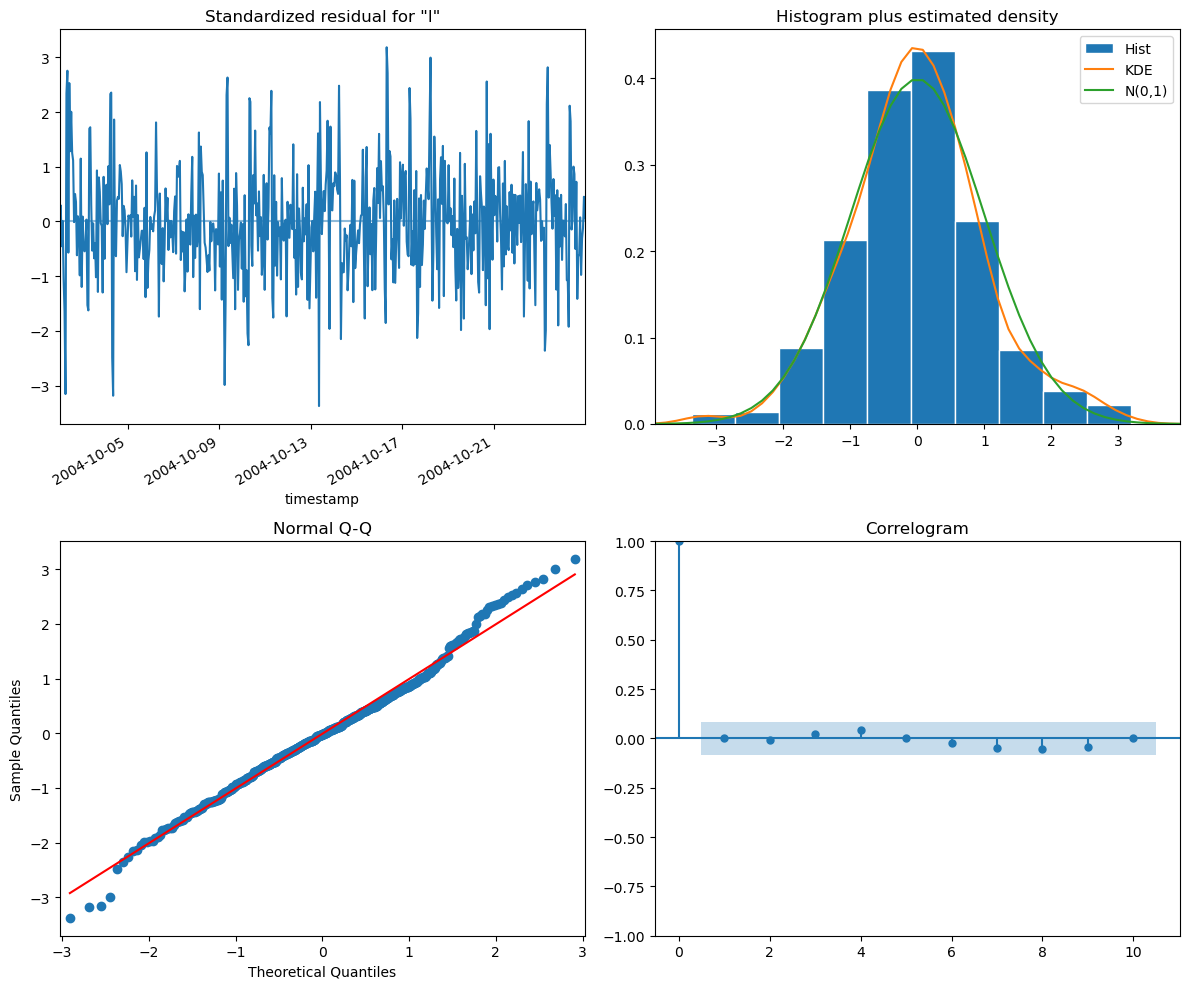

In [221]:
# Diagnostics (for (1,2,2,1))

SARIMA_model = sm.tsa.statespace.SARIMAX(
        endog = load_long_z1_2004_oct_train["log_load_rs"].asfreq('h'), 
        exog = load_long_z1_2004_oct_train[["HDK", "CDK", "holiday"]].asfreq('h'), 
        order=(1,0,2),  # non-seasonal: with no differencing
        seasonal_order=(2,1,1,24), # seasonal: with seasonal differencing
        trend = "c")

SARIMA_model_fit = SARIMA_model.fit(disp=False, maxiter=500)
SARIMA_model_fit.plot_diagnostics(figsize=(12,10))
plt.tight_layout()
plt.show()

In [222]:
# Creating test data
load_long_z1_2004_oct_test = mul_df.loc[mul_df.month == 10,:]
load_long_z1_2004_oct_test = load_long_z1_2004_oct_test.set_index("timestamp")
load_long_z1_2004_oct_test = load_long_z1_2004_oct_test['2004-10-25 00:30:00':]
load_long_z1_2004_oct_test.index = pd.to_datetime(load_long_z1_2004_oct_test.index)
load_long_z1_2004_oct_test.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-10-25 00:30:00  2004     10   25  00:30     2.449970      50.290127   
2004-10-25 01:30:00  2004     10   25  01:30     2.407305      50.291859   
2004-10-25 02:30:00  2004     10   25  02:30     2.395164      50.658222   
2004-10-25 03:30:00  2004     10   25  03:30     2.396531      50.571048   
2004-10-25 04:30:00  2004     10   25  04:30     2.434403      50.467636   

                     holiday       HDK  CDK  
timestamp                                    
2004-10-25 00:30:00        0  4.709873  0.0  
2004-10-25 01:30:00        0  4.708141  0.0  
2004-10-25 02:30:00        0  4.341778  0.0  
2004-10-25 03:30:00        0  4.428952  0.0  
2004-10-25 04:30:00        0  4.532364  0.0

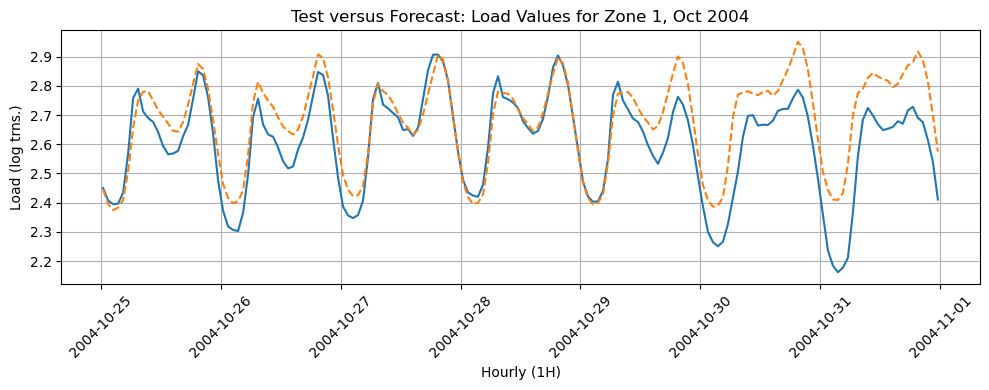

In [223]:
# Predicting 24*7 steps ahead
forecast_oct04 = SARIMA_model_fit.get_forecast(
    steps=24*7, 
    exog = load_long_z1_2004_oct_test[["HDK", "CDK", "holiday"]].asfreq('h')
).predicted_mean

# Fit on the test data
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=load_long_z1_2004_oct_test, x=load_long_z1_2004_oct_test.index, y=load_long_z1_2004_oct_test.log_load_rs.asfreq('h'), ax=ax)
sns.lineplot(forecast_oct04, linestyle = '--')
ax.set_title("Test versus Forecast: Load Values for Zone 1, Oct 2004")
ax.set_xlabel("Hourly (1H)")
ax.set_ylabel("Load (log trns.)")
ax.grid(True)
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

In [224]:
# Performance on test set

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print(f"R2 score: {r2_score(load_long_z1_2004_oct_test.log_load_rs, forecast_oct04)}")
print(f'MSE score: {mean_squared_error(load_long_z1_2004_oct_test.log_load_rs, forecast_oct04)}')
print(f'MAE score: {mean_absolute_error(load_long_z1_2004_oct_test.log_load_rs, forecast_oct04)}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_2004_oct_test.log_load_rs, forecast_oct04)}')

R2 score: 0.5814777989768904
MSE score: 0.011818044333664176
MAE score: 0.0845609336929992
MAPE score: 0.03323825351482755


##### Testing on Last Week of Dec 2004 (Zone 1)
Last week of Dec 2004 is used for testing. Multiple SARIMAX models are evaluated and compared. 

In [225]:
# Creating training data
load_long_z1_2004_dec_train = mul_df.loc[mul_df.month == 12,:]
load_long_z1_2004_dec_train = load_long_z1_2004_dec_train.set_index("timestamp")
load_long_z1_2004_dec_train = load_long_z1_2004_dec_train[:'2004-12-24 23:30:00']
load_long_z1_2004_dec_train.index = pd.to_datetime(load_long_z1_2004_dec_train.index)
load_long_z1_2004_dec_train.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-12-01 00:30:00  2004     12    1  00:30     2.650774      47.965991   
2004-12-01 01:30:00  2004     12    1  01:30     2.609481      48.609925   
2004-12-01 02:30:00  2004     12    1  02:30     2.608304      49.154281   
2004-12-01 03:30:00  2004     12    1  03:30     2.617177      50.252969   
2004-12-01 04:30:00  2004     12    1  04:30     2.646104      51.607521   

                     holiday       HDK  CDK  
timestamp                                    
2004-12-01 00:30:00        0  7.034009  0.0  
2004-12-01 01:30:00        0  6.390075  0.0  
2004-12-01 02:30:00        0  5.845719  0.0  
2004-12-01 03:30:00        0  4.747031  0.0  
2004-12-01 04:30:00        0  3.392479  0.0

In [226]:
# Comparing models - auto_arima

smodel_dec = pm.auto_arima(y = load_long_z1_2004_dec_train["log_load_rs"].asfreq('h'), 
                           X = load_long_z1_2004_dec_train[["HDK", "CDK", "holiday"]].asfreq('h'),
                           start_p=0, start_q=0,test='adf',
                           max_p=3, max_q=3, m=24,
                           start_P=0, start_Q=0, max_P=2, max_Q=2, seasonal=True,
                           d=0, D=1, trace=True,
                           trend="c",
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[24] intercept   : AIC=-943.294, Time=0.69 sec
 ARIMA(1,0,0)(1,1,0)[24] intercept   : AIC=-2185.311, Time=9.13 sec
 ARIMA(0,0,1)(0,1,1)[24] intercept   : AIC=inf, Time=8.90 sec
 ARIMA(0,0,0)(0,1,0)[24]             : AIC=-943.294, Time=0.57 sec
 ARIMA(1,0,0)(0,1,0)[24] intercept   : AIC=-2168.611, Time=3.10 sec
 ARIMA(1,0,0)(2,1,0)[24] intercept   : AIC=-2217.085, Time=20.83 sec
 ARIMA(1,0,0)(2,1,1)[24] intercept   : AIC=inf, Time=21.69 sec
 ARIMA(1,0,0)(1,1,1)[24] intercept   : AIC=inf, Time=9.53 sec
 ARIMA(0,0,0)(2,1,0)[24] intercept   : AIC=-1038.361, Time=23.01 sec
 ARIMA(2,0,0)(2,1,0)[24] intercept   : AIC=-2359.755, Time=20.85 sec
 ARIMA(2,0,0)(1,1,0)[24] intercept   : AIC=-2316.362, Time=9.31 sec
 ARIMA(2,0,0)(2,1,1)[24] intercept   : AIC=inf, Time=25.86 sec
 ARIMA(2,0,0)(1,1,1)[24] intercept   : AIC=inf, Time=11.18 sec
 ARIMA(3,0,0)(2,1,0)[24] intercept   : AIC=-2368.484, Time=27.25 sec
 ARIMA(3,0,0)(1,1,0)[24] inter

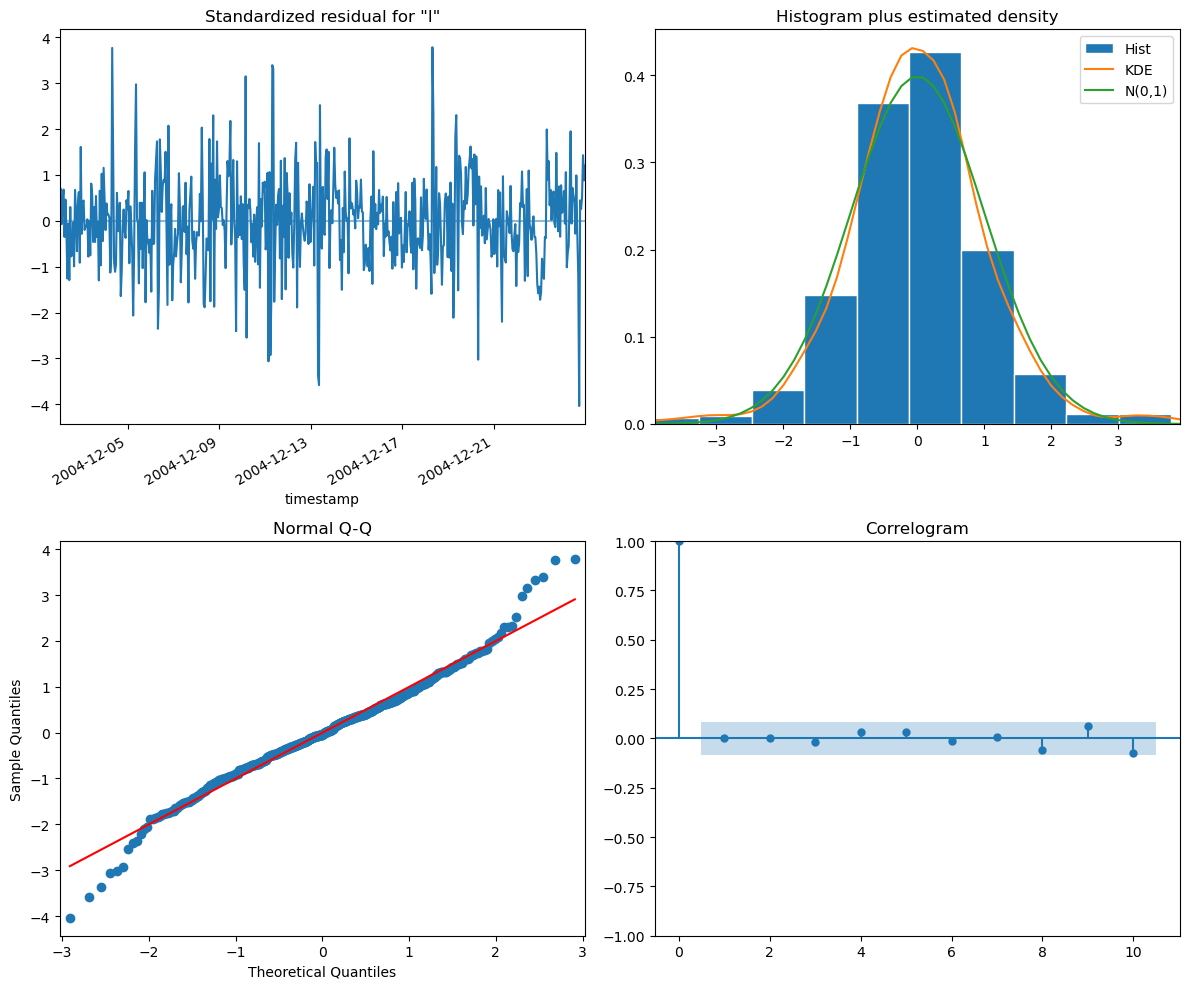

In [227]:
# Diagnostics (for (3,0,2,0))

SARIMA_model = sm.tsa.statespace.SARIMAX(
        endog = load_long_z1_2004_dec_train["log_load_rs"].asfreq('h'), 
        exog = load_long_z1_2004_dec_train[["HDK", "CDK", "holiday"]].asfreq('h'), 
        order=(3,0,0),  # non-seasonal: with no differencing
        seasonal_order=(2,1,0,24), # seasonal: with seasonal differencing
        trend="c")

SARIMA_model_fit = SARIMA_model.fit(disp=False, maxiter=500)
SARIMA_model_fit.plot_diagnostics(figsize=(12,10))
plt.tight_layout()
plt.show()

In [228]:
# Creating test data
load_long_z1_2004_dec_test = mul_df.loc[mul_df.month == 12,:]
load_long_z1_2004_dec_test = load_long_z1_2004_dec_test.set_index("timestamp")
load_long_z1_2004_dec_test = load_long_z1_2004_dec_test['2004-12-25 00:30:00':]
load_long_z1_2004_dec_test.index = pd.to_datetime(load_long_z1_2004_dec_test.index)
load_long_z1_2004_dec_test.head()

year  month  day   hour  log_load_rs  temp_weighted  \
timestamp                                                                  
2004-12-25 00:30:00  2004     12   25  00:30     3.270443      25.586955   
2004-12-25 01:30:00  2004     12   25  01:30     3.272530      24.675567   
2004-12-25 02:30:00  2004     12   25  02:30     3.290191      24.681275   
2004-12-25 03:30:00  2004     12   25  03:30     3.314804      24.588997   
2004-12-25 04:30:00  2004     12   25  04:30     3.350676      24.320518   

                     holiday        HDK  CDK  
timestamp                                     
2004-12-25 00:30:00        0  29.413045  0.0  
2004-12-25 01:30:00        0  30.324433  0.0  
2004-12-25 02:30:00        0  30.318725  0.0  
2004-12-25 03:30:00        0  30.411003  0.0  
2004-12-25 04:30:00        0  30.679482  0.0

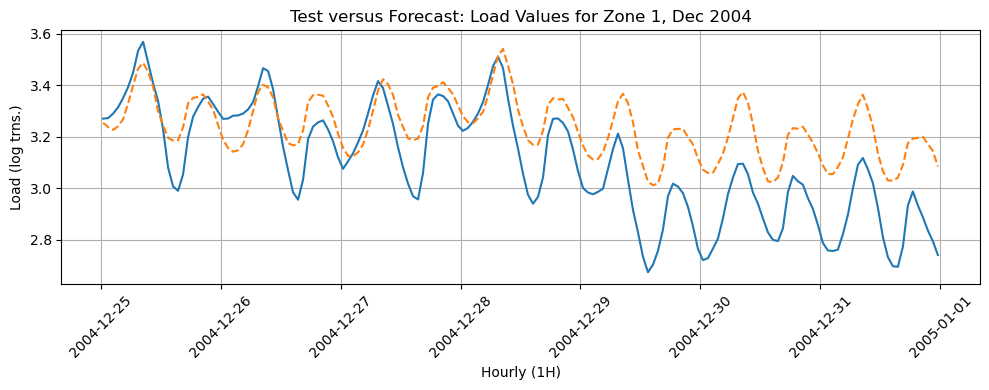

In [229]:
# Predicting 24*7 steps ahead
forecast_dec04 = SARIMA_model_fit.get_forecast(
    steps=24*7, 
    exog = load_long_z1_2004_dec_test[["HDK", "CDK", "holiday"]].asfreq('h')
).predicted_mean

# Fit on the test data
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=load_long_z1_2004_dec_test, x=load_long_z1_2004_dec_test.index, y=load_long_z1_2004_dec_test.log_load_rs.asfreq('h'), ax=ax)
sns.lineplot(forecast_dec04, linestyle = '--')
ax.set_title("Test versus Forecast: Load Values for Zone 1, Dec 2004")
ax.set_xlabel("Hourly (1H)")
ax.set_ylabel("Load (log trns.)")
ax.grid(True)
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

In [230]:
# Performance on test set

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print(f"R2 score: {r2_score(load_long_z1_2004_dec_test.log_load_rs, forecast_dec04)}")
print(f'MSE score: {mean_squared_error(load_long_z1_2004_dec_test.log_load_rs, forecast_dec04)}')
print(f'MAE score: {mean_absolute_error(load_long_z1_2004_dec_test.log_load_rs, forecast_dec04)}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_2004_dec_test.log_load_rs, forecast_dec04)}')

R2 score: 0.2244832474269175
MSE score: 0.03639003885142015
MAE score: 0.16104791439939056
MAPE score: 0.05430423915228778
